- https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#EDA
- https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python
- https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook
- https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook#EDA
- https://www.kaggle.com/code/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda/report#header
- https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard/notebook

In [313]:
import pandas as pd
import numpy as np
from scipy.stats import skew, boxcox_normmax, ttest_rel
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, FunctionTransformer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Ridge, Lasso, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from functools import partial
from sklearn import ensemble, metrics, model_selection
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from timeit import default_timer as timer

pd.set_option('display.max_columns', None)
sns.set()

In [314]:
train=pd.read_csv('train.csv')

# EDA

In [315]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [316]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

`Alley` and `PoolQC` may be dropped. 

In [317]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

Many right-skewed features, need to transform (log, box_cox, etc).

In [318]:
def miss_table(data):
    miss_table=data.isna().sum().to_frame(name='Count')
    miss_table['Percent']=miss_table['Count']/len(data)*100
    miss_table['Dtype']=data.dtypes[miss_table.index]
    miss_table['Count']=miss_table['Count'].replace({0: np.nan})
    miss_table=miss_table.dropna()
    print(f"There are {len(miss_table)}/{data.shape[1]} columns with missing values")
    print('Distribution by dtypes:')
    print(miss_table['Dtype'].value_counts())
    return miss_table.sort_values(by='Count', ascending=False)

mt=miss_table(train)
mt

There are 19/81 columns with missing values
Distribution by dtypes:
object     16
float64     3
Name: Dtype, dtype: int64


Count    Percent    Dtype
PoolQC        1453.0  99.520548   object
MiscFeature   1406.0  96.301370   object
Alley         1369.0  93.767123   object
Fence         1179.0  80.753425   object
FireplaceQu    690.0  47.260274   object
LotFrontage    259.0  17.739726  float64
GarageType      81.0   5.547945   object
GarageYrBlt     81.0   5.547945  float64
GarageFinish    81.0   5.547945   object
GarageQual      81.0   5.547945   object
GarageCond      81.0   5.547945   object
BsmtExposure    38.0   2.602740   object
BsmtFinType2    38.0   2.602740   object
BsmtFinType1    37.0   2.534247   object
BsmtCond        37.0   2.534247   object
BsmtQual        37.0   2.534247   object
MasVnrArea       8.0   0.547945  float64
MasVnrType       8.0   0.547945   object
Electrical       1.0   0.068493   object

First 3-4 features may be dropped entirely, too much NaNs.

In [319]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [320]:
train.select_dtypes('object').nunique().sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
BsmtFinType2      6
Heating           6
RoofStyle         6
SaleCondition     6
BsmtFinType1      6
GarageType        6
Foundation        6
Electrical        5
FireplaceQu       5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
ExterCond         5
BldgType          5
BsmtExposure      4
MiscFeature       4
Fence             4
LotShape          4
LandContour       4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
LandSlope         3
GarageFinish      3
PavedDrive        3
PoolQC            3
Utilities         2
CentralAir        2
Street            2
Alley             2
dtype: int64

`Neighborhood`, `Exterior2nd`, `Exterior1st` have highest cardinality out there. Not that much actually, OHE can be used.

mean=180921.196
std=79442.503
skewness=1.883
kurtosis=6.536


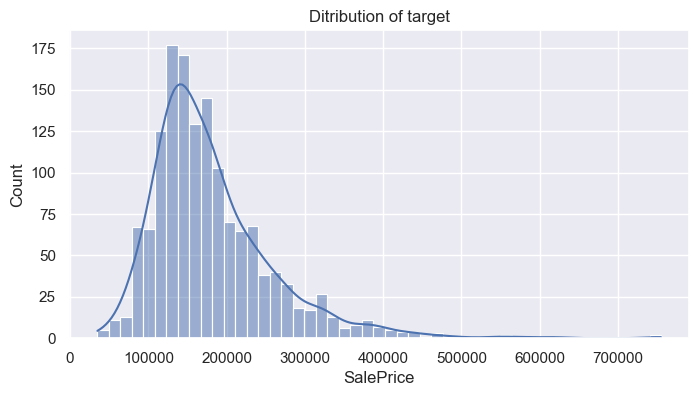

In [321]:
info=f'''mean={train["SalePrice"].mean():.3f}
std={train["SalePrice"].std():.3f}
skewness={train["SalePrice"].skew():.3f}
kurtosis={train["SalePrice"].kurt():.3f}'''
print(info)

fig, axes=plt.subplots(figsize=(8,4))
sns.histplot(train['SalePrice'], kde=True, ax=axes);
plt.title('Ditribution of target')
plt.show()

Right-skewed (some very high-price houses), high kurtosis (fat tails, some outliers). Need to transform, may help with performance.

In [322]:
def num_plot(data, pl_type='scatter'):
    nums=data.drop('Id', axis=1).select_dtypes(['number']).columns
    fig, axs = plt.subplots(int(np.round(len(list(data[nums]))/3)), 3, figsize=(12, 60))
    plt.subplots_adjust(right=1.5)
    plt.subplots_adjust(top=1.5)
    for i, feature in enumerate(list(data[nums])):
#         if(feature=='SalePrice'):
#             break
        if pl_type=='scatter':
            sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Reds', data=data, ax=axs[i//3, i%3])
        else:
            sns.histplot(x=feature, data=data, kde=True, ax=axs[i//3, i%3])


        plt.xlabel('{}'.format(feature), size=15, labelpad=1.5)
        plt.ylabel('SalePrice', size=15, labelpad=12.5)

        for j in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)

    plt.show()
    
# num_plot(train)

Eye-balled some outliers there, will remove them later.

In [323]:
# num_plot(train, 'hist')

In [324]:
def cat_plot(data, pl_type='box'):
    cats=train.select_dtypes(['object', 'category']).columns
    fig, axs = plt.subplots(int(np.ceil(len(list(data[cats]))/3)), 3, figsize=(12, 30))
    plt.subplots_adjust(right=1.5)
    plt.subplots_adjust(top=3)
    for i, feature in enumerate(list(data[cats])):
        if(feature=='SalePrice'):
            break
        if pl_type=='box':
            sns.boxplot(x=feature, y="SalePrice", data=data, ax=axs[i//3, i%3])
            axs[i//3, i%3].set_xticks(range(len(data[feature].dropna().unique())), 
                                      data[feature].dropna().unique(), rotation=45, ha='right')
        else:
            val_c=data[feature].value_counts().to_frame()
            sns.barplot(x=feature, y=val_c.index, data=val_c, ax=axs[i//3, i%3])


        plt.xlabel('{}'.format(feature), size=15, labelpad=1.5)
        plt.ylabel('SalePrice', size=15, labelpad=12.5)

        for j in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)

    plt.show()
    
# cat_plot(train)

In [325]:
# cat_plot(train, 'bar')

C:\Users\akim2\AppData\Local\Temp\ipykernel_17240\404622875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=train.corr()


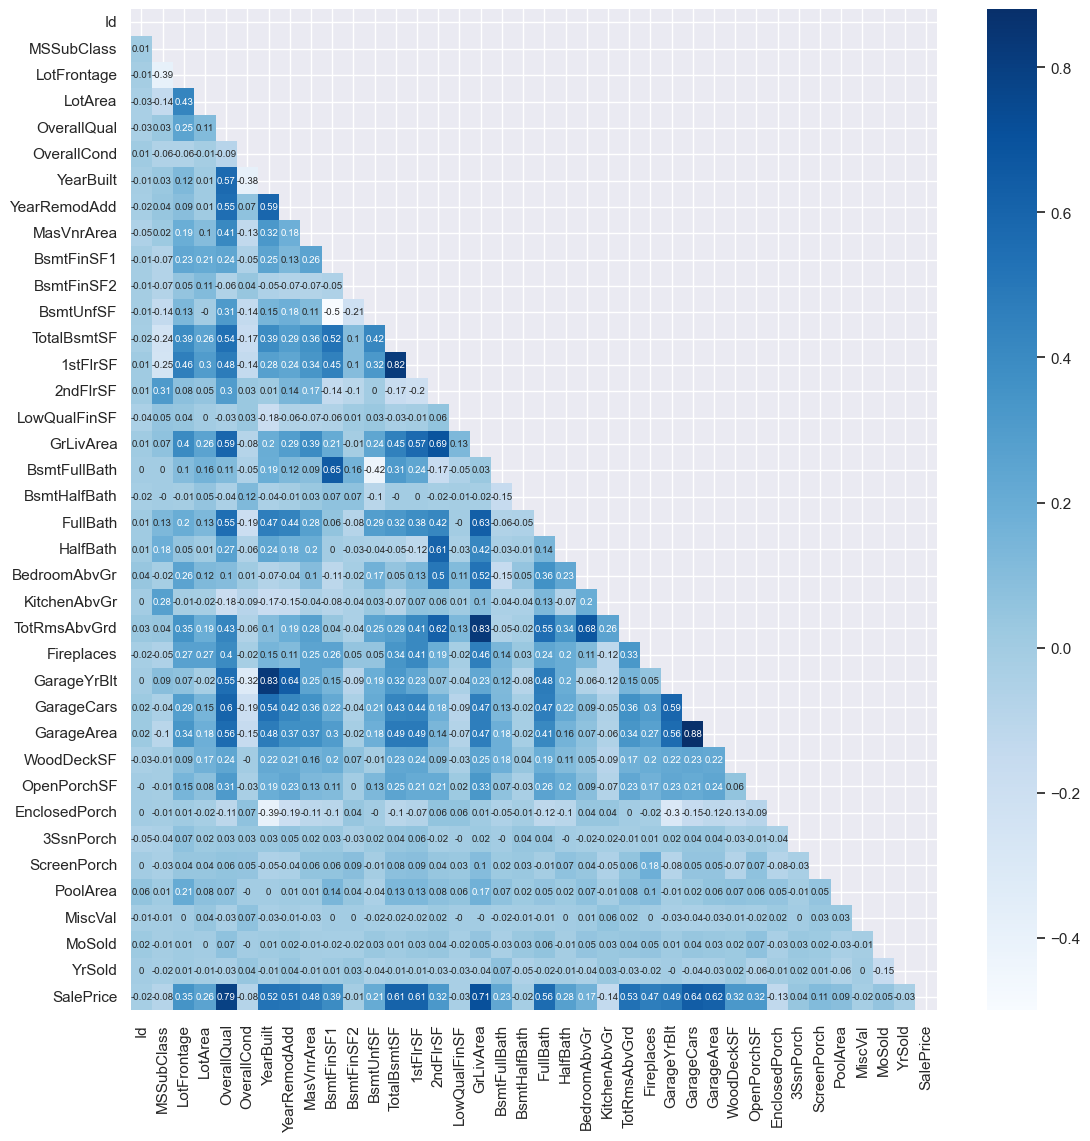

In [326]:
corr=train.corr()
mask=np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)]=True

plt.subplots(figsize=(13,13))
sns.heatmap(round(corr,2),
    cmap="Blues", mask=mask, annot=True, annot_kws={"size": 7});

There are some highly correlated variables (e.g., `GarageCars` and `GarageArea`). Should keep one of them.

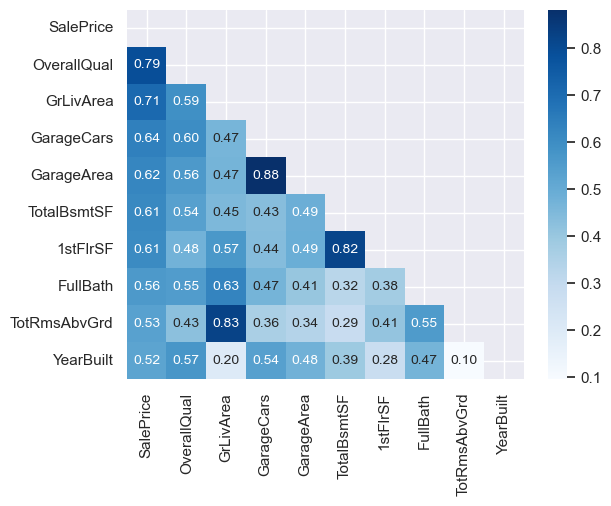

In [327]:
k=10
top_corrs=corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm=np.corrcoef(train[top_corrs].values.T)

mask=np.zeros_like(cm, dtype=bool)
mask[np.triu_indices_from(mask)]=True

# sns.set(font_scale=1.25)
hm=sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', cmap="Blues", 
                annot_kws={'size': 10}, yticklabels=top_corrs.values, xticklabels=top_corrs.values,
                mask=mask)
plt.show()

# Data Preprocessing

In [328]:
def drop_outliers(frame, drop_certain=False):
    to_drop=[]
    data=frame.copy()
    before_drop_shape=data.shape[0]
    print('0. Dropping Outliers')
    to_drop.append(data[data['SalePrice']>700000].index.values)
    to_drop.append(data[data['LotFrontage']>300].index.values)
    to_drop.append(data[data['LotArea']>150000].index.values)
    to_drop.append(data[(data['YearBuilt']<1900) & (data['SalePrice']>200000)].index.values)
    to_drop.append(data[data['MasVnrArea']>1400].index.values)
    to_drop.append(data[(data['BsmtFinSF2']>400) & (data['BsmtFinSF2']<600) & (data['SalePrice']>500000)].index.values)
    to_drop.append(data[data['1stFlrSF']>4000].index.values)
    to_drop.append(data[data['GrLivArea']>4000].index.values)
    to_drop.append(data[(data['GarageArea']>1200) & (data['SalePrice']<300000)].index.values)
    to_drop.append(data[data['OpenPorchSF']>400].index.values)
    to_drop.append(data[data['MiscVal']>8000].index.values)
    
    to_drop=set(np.concatenate(to_drop).ravel())
    if drop_certain:
        to_drop=to_drop.union(set([30, 88, 462, 631, 1322]))
    data=data.drop(to_drop)

    print(f'\t{len(to_drop)}/{before_drop_shape} samples are dropped')
    return data

In [329]:
train=drop_outliers(train, True)

0. Dropping Outliers
	27/1460 samples are dropped


In [330]:
def drop_cols(frame, to_drop):
    print('\n1. Dropping columns')
    before_drop_shape=frame.shape[1]
    data=frame.copy().drop(to_drop, axis=1)
    print(f'\tDropped {len(to_drop)}/{before_drop_shape} columns')
    return data

In [331]:
td=['Utilities', 'Street', 'PoolQC']
train=drop_cols(train, td)


1. Dropping columns
	Dropped 3/81 columns


In [332]:
def change_dtypes(frame):
    data=frame.copy()
    print('\n2. Changing dtypes')
    data['MSSubClass']=data['MSSubClass'].apply(str)
    data['YrSold']=data['YrSold'].apply(str)
    data['MoSold']=data['MoSold'].apply(str)
    return data

In [333]:
train=change_dtypes(train)


2. Changing dtypes


In [334]:
def handle_missing(frame):
    data=frame.copy()
    print('\n3. Handling missing')
    print(f'\tNo of missing before: {data.isna().sum().sum()}')
    data['Functional']=data['Functional'].fillna('Typ')
    data['Electrical']=data['Electrical'].fillna("SBrkr")
    data['KitchenQual']=data['KitchenQual'].fillna("TA")
    data['Exterior1st']=data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
    data['Exterior2nd']=data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
    data['SaleType']=data['SaleType'].fillna(data['SaleType'].mode()[0])    
    
    for c in data.select_dtypes('object').columns:
        data[c]=data.loc[:, c].fillna('None')
        
    data['LotFrontage']=data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    data['GarageYrBlt']=data['GarageYrBlt'].transform(lambda x: x.fillna(data['YearBuilt'].median()))
    
    for n in data.select_dtypes('number').columns:
        data[n]=data.loc[:, n].fillna(0)
    
    print(f'\tNo of missing after: {data.isna().sum().sum()}')
    return data

In [335]:
train=handle_missing(train)


3. Handling missing
	No of missing before: 5428
	No of missing after: 0


In [336]:
def manual_encoder(frame):
    data=frame.copy()
    print('\n4. Manual Encoding')
    qual_map={'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
    bsmt_exp_map={'Gd':4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
    bsmt_fin_type_map={'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    functional_map={'Typ':8, 'Min1':7, 'Maj1':6, 'Min2':5, 'Mod':4, 'Maj2':3, 'Sev':2, 'Sal':1, 'None':0}
    garage_finish_map={'Fin': 3, 'RFn': 2, 'Unf': 1, 'None':  0}
    paved_map={'Y': 3, 'P': 2, 'N': 1, 'None': 0}
#     lot_shape_map={'None':0, 'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4}
#     mansory_vnr_map={'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2}
    
    data['ExterQual']=data['ExterQual'].replace(qual_map)
    data['ExterCond']=data['ExterCond'].replace(qual_map)
    data['BsmtQual']=data['BsmtQual'].replace(qual_map)
    data['BsmtCond']=data['BsmtCond'].replace(qual_map)
    data['BsmtExposure']=data['BsmtExposure'].replace(bsmt_exp_map)
    data['BsmtFinType1']=data['BsmtFinType1'].replace(bsmt_fin_type_map)
    data['BsmtFinType2']=data['BsmtFinType2'].replace(bsmt_fin_type_map)
    data['HeatingQC']=data['HeatingQC'].replace(qual_map)
    data['KitchenQual']=data['KitchenQual'].replace(qual_map)
    data['Functional']=data['Functional'].replace(functional_map)
    data['FireplaceQu']=data['FireplaceQu'].replace(qual_map)
    data['GarageFinish']=data['GarageFinish'].replace(garage_finish_map)
    data['GarageQual']=data['GarageQual'].replace(qual_map)
    data['GarageCond']=data['GarageCond'].replace(qual_map)
    data['PavedDrive']=data['PavedDrive'].replace(paved_map)
#     data['LotShape']=data['LotShape'].replace(lot_shape_map)
#     data['MasVnrType']=data['MasVnrType'].replace(mansory_vnr_map)


    return data

In [337]:
train=manual_encoder(train)
train.head()


4. Manual Encoding


Id MSSubClass MSZoning  LotFrontage  LotArea Alley LotShape LandContour  \
0   1         60       RL         65.0     8450  None      Reg         Lvl   
1   2         20       RL         80.0     9600  None      Reg         Lvl   
2   3         60       RL         68.0    11250  None      IR1         Lvl   
3   4         70       RL         60.0     9550  None      IR1         Lvl   
4   5         60       RL         84.0    14260  None      IR1         Lvl   

  LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
1       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story   
2    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
3    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story   
4       FR2       Gtl      NoRidge       Norm       Norm     1Fam     2Story   

   OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
0            7            5       2003          2003     Gable  CompShg   
1            6            8       1976          1976     Gable  CompShg   
2            7            5       2001          2002     Gable  CompShg   
3            7            5       1915          1970     Gable  CompShg   
4            8            5       2000          2000     Gable  CompShg   

  Exterior1st Exterior2nd MasVnrType  MasVnrArea  ExterQual  ExterCond  \
0     VinylSd     VinylSd    BrkFace       196.0          4          3   
1     MetalSd     MetalSd       None         0.0          3          3   
2     VinylSd     VinylSd    BrkFace       162.0          4          3   
3     Wd Sdng     Wd Shng       None         0.0          3          3   
4     VinylSd     VinylSd    BrkFace       350.0          4          3   

  Foundation  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
0      PConc         4         3             1             6         706   
1     CBlock         4         3             4             5         978   
2      PConc         4         3             2             6         486   
3     BrkTil         3         4             1             5         216   
4      PConc         4         3             3             6         655   

   BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  HeatingQC  \
0             1           0        150          856    GasA          5   
1             1           0        284         1262    GasA          5   
2             1           0        434          920    GasA          5   
3             1           0        540          756    GasA          4   
4             1           0        490         1145    GasA          5   

  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0          Y      SBrkr       856       854             0       1710   
1          Y      SBrkr      1262         0             0       1262   
2          Y      SBrkr       920       866             0       1786   
3          Y      SBrkr       961       756             0       1717   
4          Y      SBrkr      1145      1053             0       2198   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0             1             0         2         1             3             1   
1             0             1         2         0             3             1   
2             1             0         2         1             3             1   
3             1             0         1         0             3             1   
4             1             0         2         1             4             1   

   KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu GarageType  \
0            4             8           8           0            0     Attchd   
1            3             6           8           1            3     Attchd   
2            4             6           8           1            3     Attchd   
3            4 

mean=12.020
std=0.389
skewness=0.128
kurtosis=0.528


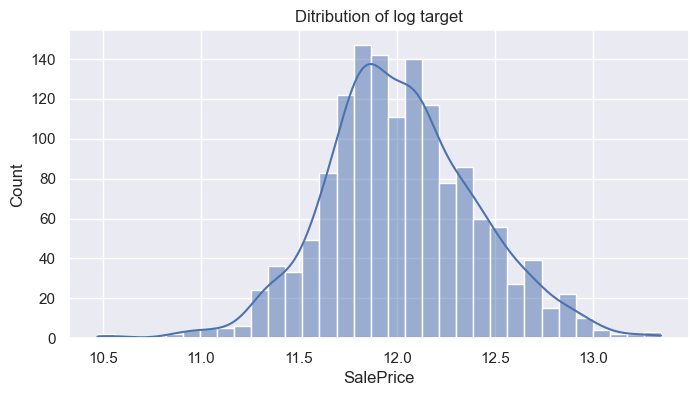

In [338]:
train["SalePrice"]=np.log1p(train["SalePrice"])

info=f'''mean={train["SalePrice"].mean():.3f}
std={train["SalePrice"].std():.3f}
skewness={train["SalePrice"].skew():.3f}
kurtosis={train["SalePrice"].kurt():.3f}'''
print(info)

fig, axes=plt.subplots(figsize=(8,4))
sns.histplot(train['SalePrice'], kde=True, ax=axes);
plt.title('Ditribution of log target');

# Feature Engineering

The dataset itself is not that much complicated, only around 15-20 features are added in a single function.

In [339]:
def generate_features(frame):
    data=frame.copy()
    print('\n5. Adding Features')
    print(f'\tShape before: {data.shape}')
    
    data['FullOverall']=data['OverallQual']+data['OverallCond']
    data['Condition1_2']=data['Condition1']+'_'+data['Condition2']
    data['YearBuildYearRemodDiff']=data['YearRemodAdd']-data['YearBuilt']
    data['IsRemod']=(data['YearRemodAdd']==data['YearBuilt']).astype(int)
    data['Exterior1st_2nd']=data['Exterior1st']+'_'+data['Exterior2nd']
    data['FullExter']=data['ExterQual']+data['ExterCond']
    data['FullBsmt']=data['BsmtQual']+data['BsmtCond']
    data['FullGarage']=data['GarageQual']+data['GarageCond']
    data['FullBsmtFinType']=data['BsmtFinType1']+data['BsmtFinType2']
    data['TotalSF']=data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['TotalScoreAll']=(data['FullOverall']+data['FullExter']+data['FullBsmt']+data['FullGarage']
                            +data['KitchenQual']+data['FireplaceQu']+data['HeatingQC'])
    data['Total_Bathrooms']=(data['FullBath'] + (0.5 * data['HalfBath']) +
                                   data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
    data['Total_porch_sf']=(data['OpenPorchSF'] + data['3SsnPorch'] +
                                  data['EnclosedPorch'] + data['ScreenPorch'] +
                                  data['WoodDeckSF'])
#     data['UnfBsmtRatio']=data['BsmtUnfSF']/data['TotalBsmtSF']
#     data['BsmtRatio']=data['TotalBsmtSF']/data['TotalSF']
    
    data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
#     aa=data.groupby('Neighborhood')['TotalSF'].mean().to_dict()
#     aa['None']=data['TotalSF'].mean()
#     data['SF_by_neigh']=data['TotalSF']/data['Neighborhood'].map(aa)
    print(f'\tShape after: {data.shape}')
    return data

In [340]:
train=generate_features(train)


5. Adding Features
	Shape before: (1433, 78)
	Shape after: (1433, 96)


I'll reskew highly skewed features using Box-Cox for all models except LGBM. I'll need to find and save lambdas beforehand, as I found `boxcox_normmax` must find optimal lambda on all data. Otherwise, it'll be very unstable.

In [341]:
lambda_dict={}
num_cols=train.drop(['Id', 'SalePrice'], axis=1).select_dtypes('number').columns
skew_cols=train[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew_cols=skew_cols[skew_cols>0.5].index

for i in high_skew_cols:
    lambda_dict[i]=boxcox_normmax(train[i]+1)

c:\Users\akim2\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\akim2\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


In [342]:
def deskew_col(frame, lambda_dict):
    data=frame.copy()
    print('\n6. Deskewing highly-skewed columns')
    for i in lambda_dict.keys():
        data[i]=boxcox1p(data[i], lambda_dict[i])
    return data

In [343]:
train=deskew_col(train, lambda_dict)
train.head()


6. Deskewing highly-skewed columns


Id MSSubClass MSZoning  LotFrontage    LotArea Alley LotShape LandContour  \
0   1         60       RL    25.531529  18.624467  None      Reg         Lvl   
1   2         20       RL    29.697690  19.099398  None      Reg         Lvl   
2   3         60       RL    26.385647  19.702081  None      IR1         Lvl   
3   4         70       RL    24.081725  19.079789  None      IR1         Lvl   
4   5         60       RL    30.768426  20.629137  None      IR1         Lvl   

  LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
1       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story   
2    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
3    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story   
4       FR2       Gtl      NoRidge       Norm       Norm     1Fam     2Story   

   OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
0            7     3.039490       2003          2003     Gable  CompShg   
1            6     4.246182       1976          1976     Gable  CompShg   
2            7     3.039490       2001          2002     Gable  CompShg   
3            7     3.039490       1915          1970     Gable  CompShg   
4            8     3.039490       2000          2000     Gable  CompShg   

  Exterior1st Exterior2nd MasVnrType  MasVnrArea  ExterQual  ExterCond  \
0     VinylSd     VinylSd    BrkFace   20.401107   1.552282   2.188889   
1     MetalSd     MetalSd       None    0.000000   1.343748   2.188889   
2     VinylSd     VinylSd    BrkFace   18.614454   1.552282   2.188889   
3     Wd Sdng     Wd Shng       None    0.000000   1.343748   2.188889   
4     VinylSd     VinylSd    BrkFace   26.845538   1.552282   2.188889   

  Foundation  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
0      PConc         4         3      0.662148             6  196.545010   
1     CBlock         4         3      1.448801             5  252.495296   
2      PConc         4         3      1.022100             6  147.450997   
3     BrkTil         3         4      0.662148             5   78.839042   
4      PConc         4         3      1.265967             6  185.530157   

   BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  HeatingQC  \
0      0.601769         0.0  30.451233          856    GasA          5   
1      0.601769         0.0  44.920862         1262    GasA          5   
2      0.601769         0.0  58.004195          920    GasA          5   
3      0.601769         0.0  66.127127          756    GasA          4   
4      0.601769         0.0  62.386761         1145    GasA          5   

  CentralAir Electrical  1stFlrSF     2ndFlrSF  LowQualFinSF  GrLivArea  \
0          Y      SBrkr  6.968916  1867.022645           0.0  13.892717   
1          Y      SBrkr  7.382472     0.000000           0.0  12.964781   
2          Y      SBrkr  7.045608  1896.791258           0.0  14.029122   
3          Y      SBrkr  7.092011  1626.077278           0.0  13.905493   
4          Y      SBrkr  7.278666  2367.469806           0.0  14.692938   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0      0.995815      0.000000         2  1.078326             3       0.71747   
1      0.000000      0.679635         2  0.000000             3       0.71747   
2      0.995815      0.000000         2  1.078326             3       0.71747   
3      0.995815      0.000000         1  0.000000             3       0.71747   
4      0.995815      0.000000         2  1.078326             4       0.71747   

   KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu GarageType  \
0            4      2.662493           8      0.0000            0     Attchd   
1            3      2.305379           8      0.9241            3     Attchd   
2            4      2.305379           8      0.9241            3

Now I'll put everything into a single feature pipeline, so one could get a model-ready feature set froma raw data by calling a single fit. Let's load the dataframe again and to test the pipeline

In [344]:
import gc 

gc.enable()
del train
gc.collect()

69787

In [345]:
df=pd.read_csv('train.csv')
df=drop_outliers(df, True)
df.shape

0. Dropping Outliers
	27/1460 samples are dropped


(1433, 81)

In [346]:
for_regression=make_pipeline(FunctionTransformer(deskew_col, kw_args={'lambda_dict': lambda_dict}), RobustScaler())
for_lgbm='passthrough'

feature_pipe=Pipeline([
    ('drop_columns', FunctionTransformer(drop_cols, kw_args={'to_drop': ['Utilities', 'Street', 'PoolQC']}))
    ,('change_dtypes', FunctionTransformer(change_dtypes))
    ,('handle_missing', FunctionTransformer(handle_missing))
    ,('manual_encoder', FunctionTransformer(manual_encoder))
    ,('generate_features', FunctionTransformer(generate_features))
    ,('column_transformer', ColumnTransformer([
                            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
                            ,()]))
])


In [347]:
sklearn_pipe=Pipeline(feature_pipe.steps)
sklearn_pipe.named_steps['column_transformer'].transformers[1]=('num', for_regression, make_column_selector(dtype_include=np.number))
sklearn_pipe

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_cols at 0x0000019A29BDDE10>,
                                     kw_args={'to_drop': ['Utilities', 'Street',
                                                          'PoolQC']})),
                ('change_dtypes',
                 FunctionTransformer(func=<function change_dtypes at 0x0000019A29BDE290>)),
                ('handle_missing',
                 FunctionTransformer(func=<function handle_missing at 0x0000019A26DA24D0>)),
                ('manual_encoder',
                 Fun...
                                                                                                                'OverallCond': 0.5457849983057812,
                                                                                                                'PoolArea': 0.46498931873764815,
                                                                                                                'ScreenPorch': 0.45107366269831445,
                                                                                                                'TotRmsAbvGrd': 0.16956899366662406,
                                                                                                                'TotalSF': 0.4546261073136812,
                                                                                                                'Total_porch_sf': 0.6531031354926107,
                                                                                                                'WoodDeckSF': 0.6583066872474849, ...}})),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019A25DB8DF0>)]))])

In [348]:
# gbm_pipe=Pipeline(feature_pipe.steps)
# gbm_pipe.named_steps['column_transformer'].transformers[1]=('num', for_lgbm, make_column_selector(dtype_include=np.number))
# gbm_pipe
# for some reason original feature_pipe is chanegd here, hence, column_transformer is changed too. 

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_cols at 0x0000019A29BDDE10>,
                                     kw_args={'to_drop': ['Utilities', 'Street',
                                                          'PoolQC']})),
                ('change_dtypes',
                 FunctionTransformer(func=<function change_dtypes at 0x0000019A29BDE290>)),
                ('handle_missing',
                 FunctionTransformer(func=<function handle_missing at 0x0000019A26DA24D0>)),
                ('manual_encoder',
                 Fun...
                 FunctionTransformer(func=<function generate_features at 0x0000019A1D5F1360>)),
                ('column_transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019A25DBB2E0>),
                                                 ('num', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019A25DB90C0>)]))])

In [349]:
df_sklearn=sklearn_pipe.fit_transform(df.drop(['Id', 'SalePrice'], axis=1))
df_sklearn.shape


1. Dropping columns
	Dropped 3/79 columns

2. Changing dtypes

3. Handling missing
	No of missing before: 5428
	No of missing after: 0

4. Manual Encoding

5. Adding Features
	Shape before: (1433, 76)
	Shape after: (1433, 94)


(1433, 353)

In [350]:
# df_lgbm=gbm_pipe.fit_transform(df.drop(['Id', 'SalePrice'], axis=1))
# df_lgbm.shape

# Modelling

In this part I'll perform CV on several models to identify most promising ones which will be blended later.

## Ridge

In [351]:
def custom_sklearn_cv(data, k, model, pipe):
    metric_df=pd.DataFrame(columns=['Train rmse', 'Test rmse'])
    kfold=KFold(k)
    features, target=data.drop(['Id', 'SalePrice'], axis=1), np.log1p(data['SalePrice'])
    features=Pipeline(pipe.steps[:-1]).fit_transform(features)
    
    for f, (tr, te) in enumerate(kfold.split(features, y=target)):
        X_train, y_train=features.iloc[tr, :], target.iloc[tr]
        X_test, y_test=features.iloc[te, :], target.iloc[te]
        X_train_tr=pipe.named_steps['column_transformer'].fit_transform(X_train)
        X_test_tr=pipe.named_steps['column_transformer'].transform(X_test)

        mod=model
        mod.fit(X_train_tr, y_train)
        train_pred=mod.predict(X_train_tr)
        test_pred=mod.predict(X_test_tr)
        rmse_train=mean_squared_error(y_train, train_pred, squared=False)
        rmse_test=mean_squared_error(y_test, test_pred, squared=False)
        
        metric_df.loc[f]=[rmse_train, rmse_test]
        

    metric_df.loc['Avg']=[metric_df['Train rmse'].mean(), metric_df['Test rmse'].mean()]
    return metric_df, mod

In [352]:
alphas_alt=[14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

res_ridge, model_ridge=custom_sklearn_cv(df, 12, RidgeCV(alphas=alphas_alt, cv=10), sklearn_pipe)
res_ridge


1. Dropping columns
	Dropped 3/79 columns

2. Changing dtypes

3. Handling missing
	No of missing before: 5428
	No of missing after: 0

4. Manual Encoding

5. Adding Features
	Shape before: (1433, 76)
	Shape after: (1433, 94)


Train rmse  Test rmse
0      0.093247   0.095495
1      0.093355   0.091567
2      0.093281   0.093211
3      0.091705   0.113342
4      0.092555   0.100118
5      0.089462   0.136083
6      0.092618   0.105379
7      0.090047   0.128284
8      0.093553   0.090570
9      0.093333   0.091959
10     0.092077   0.107692
11     0.091862   0.110141
Avg    0.092258   0.105320

In [189]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [191]:
score = cv_rmse(RidgeCV(alphas=alphas_alt, cv=10), df_sklearn, np.log1p(df['SalePrice']))
print("ridge: {:.6f} ({:.6f})".format(score.mean(), score.std()))

ridge: 0.105327 (0.010622)


## Lasso

In [546]:
alphas2=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

res_lasso, model_lasso=custom_sklearn_cv(df, 12, LassoCV(max_iter=int(1e7), alphas=alphas2, random_state=42, cv=10,  n_jobs=-1), sklearn_pipe)
res_lasso


1. Dropping columns
	Dropped 3/79 columns

2. Changing dtypes

3. Handling missing
	No of missing before: 5428
	No of missing after: 0

4. Manual Encoding

5. Adding Features
	Shape before: (1433, 76)
	Shape after: (1433, 94)


Train rmse  Test rmse
0      0.097415   0.094977
1      0.095697   0.092151
2      0.097227   0.094581
3      0.093851   0.109938
4      0.093617   0.100222
5      0.091213   0.138992
6      0.094185   0.099467
7      0.091565   0.125722
8      0.095869   0.089082
9      0.094585   0.089902
10     0.095346   0.106640
11     0.093030   0.107247
Avg    0.094467   0.104077

## ElasticNet

In [547]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

res_elastic, model_elastic=custom_sklearn_cv(df, 12, ElasticNetCV(max_iter=int(1e7), alphas=e_alphas, cv=10, l1_ratio=e_l1ratio, n_jobs=-1), sklearn_pipe)
res_elastic


1. Dropping columns
	Dropped 3/79 columns

2. Changing dtypes

3. Handling missing
	No of missing before: 5428
	No of missing after: 0

4. Manual Encoding

5. Adding Features
	Shape before: (1433, 76)
	Shape after: (1433, 94)


Train rmse  Test rmse
0      0.097133   0.094646
1      0.095697   0.092151
2      0.097173   0.094540
3      0.093350   0.110224
4      0.093571   0.100248
5      0.091008   0.139112
6      0.094185   0.099467
7      0.091565   0.125722
8      0.095869   0.089082
9      0.094886   0.089954
10     0.095346   0.106640
11     0.093357   0.107052
Avg    0.094428   0.104070

## XGBoost

In [559]:
model_xgb = XGBRegressor(learning_rate=0.01
                       ,n_estimators=3460
                       ,max_depth=3
                       , min_child_weight=0
                       ,gamma=0
                       ,subsample=0.7
                       ,colsample_bytree=0.7
                       ,objective='reg:squarederror'
                       ,nthread=-1
                       ,scale_pos_weight=1
                       ,reg_alpha=0.00006)

In [560]:
res_xgb, model_xgb=custom_sklearn_cv(df, 12, model_xgb, gbm_pipe)
res_xgb


1. Dropping columns
	Dropped 3/79 columns

2. Changing dtypes

3. Handling missing
	No of missing before: 5428
	No of missing after: 0

4. Manual Encoding

5. Adding Features
	Shape before: (1433, 76)
	Shape after: (1433, 94)


Train rmse  Test rmse
0      0.045211   0.092795
1      0.045716   0.086700
2      0.045607   0.093809
3      0.045018   0.106442
4      0.045260   0.096139
5      0.043576   0.138908
6      0.045724   0.094680
7      0.044679   0.126653
8      0.045748   0.087571
9      0.045158   0.104493
10     0.044950   0.107572
11     0.044523   0.108972
Avg    0.045098   0.103728

## LGBM

In [146]:
import lightgbm as lgb

def custom_lgbm_cv(data, k, pipe):
    metric_df=pd.DataFrame(columns=['Train rmse', 'Test rmse'])
    kfold=KFold(k)
    features, target=data.drop(['Id', 'SalePrice'], axis=1), np.log1p(data['SalePrice'])
    features=Pipeline(pipe.steps[:-1]).fit_transform(features)
    for f, (tr, te) in enumerate(kfold.split(features, y=target)):
        X_train, y_train=features.iloc[tr, :], target.iloc[tr]
        X_test, y_test=features.iloc[te, :], target.iloc[te]
        
        X_train_tr=pipe.named_steps['column_transformer'].fit_transform(X_train)
        X_test_tr=pipe.named_steps['column_transformer'].transform(X_test)

        params=dict(objective='regression', 
                metrics='rmse',
                num_leaves=6,
                learning_rate=0.01, 
                n_estimators=7000,
                max_bin=200, 
                bagging_fraction=0.8,
                bagging_freq=4, 
                bagging_seed=8,
                feature_fraction=0.2,
                feature_fraction_seed=8,
                min_sum_hessian_in_leaf = 11,
                random_state=42,
                verbose=-1,)

        dtrain=lgb.Dataset(X_train_tr, label=y_train)
        dval=lgb.Dataset(X_test_tr, label=y_test)

        model=lgb.train(
                params=params,
                train_set=dtrain,
                valid_sets=[dtrain, dval],
                valid_names=['train', 'test'],
                callbacks=[lgb.early_stopping(10, verbose=-1), lgb.log_evaluation(-1)],
        # categorical_feature=a
        )
        
        test_score, train_score=model.best_score['test']['rmse'], model.best_score['train']['rmse']
        metric_df.loc[f]=[train_score, test_score]
        

    metric_df.loc['Avg']=[metric_df['Train rmse'].mean(), metric_df['Test rmse'].mean()]
    return metric_df, model

In [147]:
res_lgbm, model_lgbm=custom_lgbm_cv(df, 12, gbm_pipe)


1. Dropping columns
	Dropped 3/79 columns

2. Changing dtypes

3. Handling missing
	No of missing before: 5428
	No of missing after: 0

4. Manual Encoding

5. Adding Features
	Shape before: (1433, 76)
	Shape after: (1433, 94)
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[820]	train's rmse: 0.0913929	test's rmse: 0.0976711
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1021]	train's rmse: 0.0873171	test's rmse: 0.0970967
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[776]	train's rmse: 0.092525	test's rmse: 0.0981258
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[947]	train's rmse: 0.08745	test's rmse: 0.112394
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[899]	train's rmse: 0.0896005	test's rmse: 0.106764
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1224]	train's rmse: 0.0798347	test's rmse: 0.140206
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[811]	train's rmse: 0.0919206	test's rmse: 0.104677
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[856]	train's rmse: 0.0886144	test's rmse: 0.138444
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1180]	train's rmse: 0.0856595	test's rmse: 0.0899158
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[760]	train's rmse: 0.0929601	test's rmse: 0.100238
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[892]	train's rmse: 0.0887964	test's rmse: 0.109965
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[942]	train's rmse: 0.0881246	test's rmse: 0.111079


In [188]:
res_lgbm

Train rmse  Test rmse
0      0.091393   0.097671
1      0.087317   0.097097
2      0.092525   0.098126
3      0.087450   0.112394
4      0.089601   0.106764
5      0.079835   0.140206
6      0.091921   0.104677
7      0.088614   0.138444
8      0.085660   0.089916
9      0.092960   0.100238
10     0.088796   0.109965
11     0.088125   0.111079
Avg    0.088683   0.108881

# Blending

As my main goal is to get a good enough model for deployment, not winning a competiton, I'll try to keep it simple by blending only 2-3 models.

## ElasticNet+LGBM

## Kaggle's Best Blending

This is a copy of a best-performing model in the competition. It's a quite complex blending of several models, including a stacked model.

In [41]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge =RidgeCV(alphas=alphas_alt, cv=kfolds)

lasso = LassoCV(max_iter=int(1e7), alphas=alphas2,
                            random_state=42, cv=kfolds, n_jobs=-1)

elasticnet = ElasticNetCV(max_iter=int(1e7), alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio, n_jobs=-1)
                                        
svr = SVR(C= 20, epsilon= 0.008, gamma=0.0003,)

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10, 
                                loss='huber', random_state =42)


lightgbm = LGBMRegressor(objective='regression', 
                                    num_leaves=4,
                                    learning_rate=0.01, 
                                    n_estimators=5000,
                                    max_bin=200, 
                                    bagging_fraction=0.75,
                                    bagging_freq=5, 
                                    bagging_seed=7,
                                    feature_fraction=0.2,
                                    feature_fraction_seed=7,
                                    verbose=-1,
                                    )
                                    

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                        max_depth=3, min_child_weight=0,
                        gamma=0, subsample=0.7,
                        colsample_bytree=0.7,
                        objective='reg:linear', nthread=-1,
                        scale_pos_weight=1, seed=27,
                        reg_alpha=0.00006)

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [43]:
X, y=np.array(df_sklearn), np.log1p(np.array(df['SalePrice']))

In [45]:
from datetime import datetime

print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
2023-04-24 14:30:37.191266 StackingCVRegressor
[14:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:26] WARNING:

In [87]:
def blend_models_predict(X):
    return ((0.15 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.15 * lgb_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

In [88]:
print(rmsle(y, blend_models_predict(df_sklearn)))

0.060468872678793854


In [89]:
test_df=pd.read_csv('test.csv')
test_df_sklearn=sklearn_pipe.transform(test_df)
y_pred=blend_models_predict(test_df_sklearn)


1. Dropping columns
	Dropped 3/80 columns

2. Changing dtypes

3. Handling missing
	No of missing before: 5542
	No of missing after: 0

4. Manual Encoding

5. Adding Features
	Shape before: (1459, 77)
	Shape after: (1459, 95)


In [90]:
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(y_pred))
submission.to_csv("blend_models_predict.csv", index=False)

# HPO

In [172]:
def optimize(params, x, y, pipe=gbm_pipe, k=5):
    global ITERATION
    ITERATION += 1
    rmses_test=[]
    params['metrics']='rmse'
    params['verbose']=-1

    start = timer()
    metric_df=pd.DataFrame(columns=['Train rmse', 'Test rmse'])
    kfold=KFold(k)
    x, y=Pipeline(pipe.steps[:-1]).fit_transform(x), np.log1p(y)
    for f, (tr, te) in enumerate(kfold.split(x, y=y)):
        X_train, y_train=x.iloc[tr, :], y.iloc[tr]
        X_test, y_test=x.iloc[te, :], y.iloc[te]
        
        X_train=pipe.named_steps['column_transformer'].fit_transform(X_train)
        X_test=pipe.named_steps['column_transformer'].transform(X_test)
        
        params=params
        dtrain=lgb.Dataset(X_train, label=y_train)
        dval=lgb.Dataset(X_test, label=y_test)
   
        model=lgb.train(
                params=params,
                train_set=dtrain,
                valid_sets=[dtrain, dval],
                valid_names=['train', 'test'],
                callbacks=[lgb.early_stopping(10, verbose=-100), lgb.log_evaluation(-100)],
#                 categorical_feature=a,
                verbose_eval=False)
        
        rmses_test.append(model.best_score['test']['rmse'])

    run_time = timer() - start
    
    rmse_mean=np.mean(rmses_test)
    return {'loss': rmse_mean, 
            'params': params, 
            'iteration': ITERATION,
            'train_time': run_time, 
            'status': STATUS_OK}

In [173]:
t=Trials()

In [174]:
X, y=df.drop(['Id', 'SalePrice'], axis=1), df['SalePrice']

param_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 500, 5000, 50)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 4, 12, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_bin': scope.int(hp.quniform('max_bin', 150, 300, 5)),
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 0.8),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 0.8),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 2, 5, 1)),
}


ITERATION, MAX_EVALS=1, 500
t=Trials()
hopt=fmin(
    fn=partial(optimize, x=X, y=y),
    space=param_space,
    algo=tpe.suggest,
    max_evals=MAX_EVALS,
    trials=t
)

hopt

                                                       
1. Dropping columns
	Dropped 3/79 columns                                  
                                                       
2. Changing dtypes
                                                       
3. Handling missing
	No of missing before: 5428                            
	No of missing after: 0                                
                                                       
4. Manual Encoding
                                                       
5. Adding Features
	Shape before: (1433, 76)                              
	Shape after: (1433, 94)                               
Training until validation scores don't improve for 10 rounds
  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                     
[477]	train's rmse: 0.0975003	test's rmse: 0.105484
Training until validation scores don't improve for 10 rounds
  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                     
[598]	train's rmse: 0.0904639	test's rmse: 0.111041
Training until validation scores don't improve for 10 rounds
  0%|          | 0/500 [00:01<?, ?trial/s, best loss=?]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                     
[895]	train's rmse: 0.0798765	test's rmse: 0.121279
Training until validation scores don't improve for 10 rounds
  0%|          | 0/500 [00:02<?, ?trial/s, best loss=?]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                     
[785]	train's rmse: 0.0862508	test's rmse: 0.110096
Training until validation scores don't improve for 10 rounds
  0%|          | 0/500 [00:02<?, ?trial/s, best loss=?]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                     
[660]	train's rmse: 0.0876909	test's rmse: 0.114458
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                        

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[52]	train's rmse: 0.0824285	test's rmse: 0.116049
  0%|          | 1/500 [00:04<29:13,  3.51s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[79]	train's rmse: 0.0722259	test's rmse: 0.119659
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[79]	train's rmse: 0.0747732	test's rmse: 0.112382
  0%|          | 1/500 [00:04<29:13,  3.51s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[66]	train's rmse: 0.075473	test's rmse: 0.113853
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 7

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[23]	train's rmse: 0.11533	test's rmse: 0.136702
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[32]	train's rmse: 0.10451	test's rmse: 0.139757
  0%|          | 2/500 [00:05<18:47,  2.26s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[46]	train's rmse: 0.0995236	test's rmse: 0.130146
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[28]	train's rmse: 0.106796	test's rmse: 0.12867
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
  1%|          | 3/500 [00:06<14:50,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[145]	train's rmse: 0.106219	test's rmse: 0.104668
  1%|          | 3/500 [00:06<14:50,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  1%|          | 3/500 [00:06<14:50,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[102]	train's rmse: 0.109801	test's rmse: 0.121275
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[154]	train's rmse: 0.0991629	test's rmse: 0.128345
  1%|          | 3/500 [00:07<14:50,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  1%|          | 3/500 [00:07<14:50,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[239]	train's rmse: 0.0942787	test's rmse: 0.11602
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[130]	train's rmse: 0.104952	test's rmse: 0.122121
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
  1%|          | 4/500 [00:07<14:50,  1.80s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[235]	train's rmse: 0.107735	test's rmse: 0.107541
  1%|          | 4/500 [00:08<14:50,  1.80s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  1%|          | 4/500 [00:08<14:50,  1.80s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[271]	train's rmse: 0.102725	test's rmse: 0.118999
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[326]	train's rmse: 0.0983371	test's rmse: 0.126656
  1%|          | 4/500 [00:09<14:50,  1.80s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  1%|          | 4/500 [00:09<14:50,  1.80s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[321]	train's rmse: 0.101815	test's rmse: 0.116902
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[257]	train's rmse: 0.10479	test's rmse: 0.119904
  1%|          | 5/500 [00:09<14:46,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  1%|          | 5/500 [00:10<14:46,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[321]	train's rmse: 0.112497	test's rmse: 0.12056
Training until validation scores don't improve for 10 rounds                      
  1%|          | 5/500 [00:10<14:46,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[300]	train's rmse: 0.111132	test's rmse: 0.137393
Training until validation scores don't improve for 10 rounds                      
  1%|          | 5/500 [00:11<14:46,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[395]	train's rmse: 0.108139	test's rmse: 0.123952
Training until validation scores don't improve for 10 rounds                      
  1%|          | 5/500 [00:11<14:46,  1.79s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[285]	train's rmse: 0.114595	test's rmse: 0.128048
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[417]	train's rmse: 0.110549	test's rmse: 0.109371
Training until validation scores don't improve for 10 rounds                      
  1%|          | 6/500 [00:12<15:33,  1.89s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[405]	train's rmse: 0.108047	test's rmse: 0.118602
Training until validation scores don't improve for 10 rounds                      
  1%|          | 6/500 [00:13<15:33,  1.89s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[649]	train's rmse: 0.09808	test's rmse: 0.125226
Training until validation scores don't improve for 10 rounds                      
  1%|          | 6/500 [00:13<15:33,  1.89s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[655]	train's rmse: 0.0998335	test's rmse: 0.116975
Training until validation scores don't improve for 10 rounds                      
  1%|          | 6/500 [00:14<15:33,  1.89s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[512]	train's rmse: 0.104204	test's rmse: 0.120916
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  1%|▏         | 7/500 [00:15<17:35,  2.14s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[108]	train's rmse: 0.0761769	test's rmse: 0.111004
Training until validation scores don't improve for 10 rounds                      
  1%|▏         | 7/500 [00:15<17:35,  2.14s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[130]	train's rmse: 0.0695776	test's rmse: 0.12132
Training until validation scores don't improve for 10 rounds                      
  1%|▏         | 7/500 [00:15<17:35,  2.14s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[176]	train's rmse: 0.0632256	test's rmse: 0.110613
Training until validation scores don't improve for 10 rounds                      
  1%|▏         | 7/500 [00:16<17:35,  2.14s/trial, best loss: 0.11247159311564178]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[121]	train's rmse: 0.0717993	test's rmse: 0.116788
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[33]	train's rmse: 0.115204	test's rmse: 0.127266
  2%|▏         | 8/500 [00:17<17:13,  2.10s/trial, best loss: 0.11201857158252956]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[57]	train's rmse: 0.106267	test's rmse: 0.128905
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[55]	train's rmse: 0.105915	test's rmse: 0.122181
  2%|▏         | 8/500 [00:17<17:13,  2.10s/trial, best loss: 0.11201857158252956]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[59]	train's rmse: 0.103569	test's rmse: 0.128103
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 7

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[246]	train's rmse: 0.0912594	test's rmse: 0.101877
Training until validation scores don't improve for 10 rounds                      
  2%|▏         | 9/500 [00:18<15:43,  1.92s/trial, best loss: 0.11201857158252956]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[179]	train's rmse: 0.0958072	test's rmse: 0.111428
Training until validation scores don't improve for 10 rounds                      
  2%|▏         | 9/500 [00:19<15:43,  1.92s/trial, best loss: 0.11201857158252956]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[269]	train's rmse: 0.0853492	test's rmse: 0.119851
Training until validation scores don't improve for 10 rounds                      
  2%|▏         | 9/500 [00:19<15:43,  1.92s/trial, best loss: 0.11201857158252956]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[303]	train's rmse: 0.0858275	test's rmse: 0.111413
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[242]	train's rmse: 0.0886936	test's rmse: 0.112324
  2%|▏         | 10/500 [00:20<16:05,  1.97s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[40]	train's rmse: 0.0821649	test's rmse: 0.117398
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[53]	train's rmse: 0.0712834	test's rmse: 0.122936
  2%|▏         | 10/500 [00:21<16:05,  1.97s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[33]	train's rmse: 0.0875156	test's rmse: 0.122875
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[56]	train's rmse: 0.0719293	test's rmse: 0.115402
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
  2%|▏         | 11/500 [00:21<14:28,  1.78s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[17]	train's rmse: 0.139319	test's rmse: 0.138509
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[24]	train's rmse: 0.133773	test's rmse: 0.140814
  2%|▏         | 11/500 [00:22<1

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
  2%|▏         | 11/500 [00:22<14:28,  1.78s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[52]	train's rmse: 0.121413	test's rmse: 0.152131
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[19]	train's rmse: 0.131945	test's rmse: 0.150371
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[16]	train's rmse: 0.136241	test's rmse: 0.149579
  2%|▏         | 11/500 [00:22<14:28,  1.78s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[166]	train's rmse: 0.10172	test's rmse: 0.116539
  2%|▏         | 12/500 [00:23<13:00,  1.60s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  2%|▏         | 12/500 [00:23<13:00,  1.60s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[283]	train's rmse: 0.0898198	test's rmse: 0.123363
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[243]	train's rmse: 0.0954816	test's rmse: 0.113661
  2%|▏         | 12/500 [00:24<13:00,  1.60s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[196]	train's rmse: 0.0985086	test's rmse: 0.116472
  2%|▏         | 12/500 [00:24<13:00,  1.60s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[443]	train's rmse: 0.116283	test's rmse: 0.112433
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 13/500 [00:25<13:44,  1.69s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[560]	train's rmse: 0.10975	test's rmse: 0.119667
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 13/500 [00:26<13:44,  1.69s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[727]	train's rmse: 0.102224	test's rmse: 0.131659
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 13/500 [00:26<13:44,  1.69s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[675]	train's rmse: 0.105864	test's rmse: 0.122315
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 13/500 [00:27<13:44,  1.69s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[656]	train's rmse: 0.107149	test's rmse: 0.122552
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[165]	train's rmse: 0.100749	test's rmse: 0.104566
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 14/500 [00:28<17:32,  2.16s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[272]	train's rmse: 0.088808	test's rmse: 0.110813
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[199]	train's rmse: 0.0928316	test's rmse: 0.125194
  3%|▎         | 14/500 [00:29<17:32,  2.16s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 14/500 [00:29<17:32,  2.16s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[245]	train's rmse: 0.0920922	test's rmse: 0.115413
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 14/500 [00:29<17:32,  2.16s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[272]	train's rmse: 0.0890909	test's rmse: 0.112809
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[542]	train's rmse: 0.100588	test's rmse: 0.104418
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 15/500 [00:30<17:13,  2.13s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[588]	train's rmse: 0.0962912	test's rmse: 0.113865
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 15/500 [00:31<17:13,  2.13s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[556]	train's rmse: 0.0957522	test's rmse: 0.127153
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 15/500 [00:31<17:13,  2.13s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[616]	train's rmse: 0.0967594	test's rmse: 0.115794
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 15/500 [00:32<17:13,  2.13s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[656]	train's rmse: 0.0947476	test's rmse: 0.116486
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[407]	train's rmse: 0.0889757	test's rmse: 0.101552
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 16/500 [00:33<19:05,  2.37s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[342]	train's rmse: 0.0909588	test's rmse: 0.109913
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 16/500 [00:34<19:05,  2.37s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[479]	train's rmse: 0.0828722	test's rmse: 0.120897
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 16/500 [00:34<19:05,  2.37s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[567]	train's rmse: 0.0811238	test's rmse: 0.10917
Training until validation scores don't improve for 10 rounds                      
  3%|▎         | 16/500 [00:35<19:05,  2.37s/trial, best loss: 0.1113787209364018]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[342]	train's rmse: 0.0901941	test's rmse: 0.114179
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[114]	train's rmse: 0.0911045	test's rmse: 0.112643
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[172]	train's rmse: 0.0833155	test's rmse: 0.120648
  3%|▎         | 17/500 [00:36<19:37,  2.44s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[134]	train's rmse: 0.0906962	test's rmse: 0.111413
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[116]	train's rmse: 0.0915479	test's rmse: 0.116703
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
  4%|▎         | 18/500 [00:36<16:45,  2.09s/trial, best loss: 0.1111423879745359

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after: (1433, 94)                                                           
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[92]	train's rmse: 0.0901366	test's rmse: 0.103337
  4%|▎         | 18/500 [00:37<16:45,  2.09s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[89]	train's rmse: 0.0899205	test's rmse: 0.112347
  4%|▎         | 18/500 [00:37<16:45,  2.09s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[191]	train's rmse: 0.0720202	test's rmse: 0.121761
Training until validation scores don't improve for 10 rounds                       
  4%|▎         | 18/500 [00:37<16:45,  2.09s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[128]	train's rmse: 0.0834117	test's rmse: 0.109346
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[87]	train's rmse: 0.0900651	test's rmse: 0.116186
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
  4%|▍         | 19/500 [00:38<16:03,  2.00s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after: (1433, 94)                                                           
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[45]	train's rmse: 0.0774137	test's rmse: 0.110833
  4%|▍         | 19/500 [00:38<16:03,  2.00s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[41]	train's rmse: 0.0778195	test's rmse: 0.11377
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[32]	train's rmse: 0.0829399	test's rmse: 0.130567
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 19/500 [00:39<16:03,  2.00s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                 
[47]	train's rmse: 0.0751155	test's rmse: 0.117286
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[38]	train's rmse: 0.0789067	test's rmse: 0.117109
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
  4%|▍         | 20/500 [00:39<13:51,  1.73s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after: (1433, 94)                                                           
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 20/500 [00:39<13:51,  1.73s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[514]	train's rmse: 0.0910895	test's rmse: 0.100453
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 20/500 [00:40<13:51,  1.73s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[414]	train's rmse: 0.0940932	test's rmse: 0.109989
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 20/500 [00:40<13:51,  1.73s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[489]	train's rmse: 0.0878191	test's rmse: 0.121516
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 20/500 [00:41<13:51,  1.73s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[703]	train's rmse: 0.0850194	test's rmse: 0.108703
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 20/500 [00:42<13:51,  1.73s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[338]	train's rmse: 0.096515	test's rmse: 0.116236
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[172]	train's rmse: 0.0866301	test's rmse: 0.107294
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[148]	train's rmse: 0.0856141	test's rmse: 0.12279
  4%|▍         | 21/500 [00:43<17:31,  2.19s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 21/500 [00:44<17:31,  2.19s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[172]	train's rmse: 0.087694	test's rmse: 0.113651
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[113]	train's rmse: 0.0936459	test's rmse: 0.112887
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "




2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after: (1433, 94)                                                           
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 22/500 [00:45<16:25,  2.06s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[641]	train's rmse: 0.0889759	test's rmse: 0.102712
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 22/500 [00:45<16:25,  2.06s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[423]	train's rmse: 0.0955445	test's rmse: 0.110605
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 22/500 [00:46<16:25,  2.06s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[690]	train's rmse: 0.0839704	test's rmse: 0.120803
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 22/500 [00:47<16:25,  2.06s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[712]	train's rmse: 0.0853877	test's rmse: 0.109932
Training until validation scores don't improve for 10 rounds                       
  4%|▍         | 22/500 [00:48<16:25,  2.06s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[440]	train's rmse: 0.0937115	test's rmse: 0.113706
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[353]	train's rmse: 0.0956106	test's rmse: 0.100723
Training until validation scores don't improve for 10 rounds                       
  5%|▍         | 23/500 [00:49<20:42,  2.60s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[381]	train's rmse: 0.0931965	test's rmse: 0.111825
Training until validation scores don't improve for 10 rounds                       
  5%|▍         | 23/500 [00:49<20:42,  2.60s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[379]	train's rmse: 0.0891963	test's rmse: 0.120775
Training until validation scores don't improve for 10 rounds                       
  5%|▍         | 23/500 [00:50<20:42,  2.60s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[583]	train's rmse: 0.085569	test's rmse: 0.108252
Training until validation scores don't improve for 10 rounds                       
  5%|▍         | 23/500 [00:51<20:42,  2.60s/trial, best loss: 0.11114238797453597]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[432]	train's rmse: 0.0893879	test's rmse: 0.112043
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[431]	train's rmse: 0.0935207	test's rmse: 0.101721
Training until validation scores don't improve for 10 rounds                       
  5%|▍         | 24/500 [00:52<21:25,  2.70s/trial, best loss: 0.11072385895958972]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[392]	train's rmse: 0.0930376	test's rmse: 0.110409
Training until validation scores don't improve for 10 rounds                       
  5%|▍         | 24/500 [00:52<21:25,  2.70s/trial, best loss: 0.11072385895958972]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[502]	train's rmse: 0.0864829	test's rmse: 0.12279
Training until validation scores don't improve for 10 rounds                       
  5%|▍         | 24/500 [00:53<21:25,  2.70s/trial, best loss: 0.11072385895958972]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[584]	train's rmse: 0.0869557	test's rmse: 0.109907
Training until validation scores don't improve for 10 rounds                       
  5%|▍         | 24/500 [00:54<21:25,  2.70s/trial, best loss: 0.11072385895958972]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[367]	train's rmse: 0.0931284	test's rmse: 0.113653
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[610]	train's rmse: 0.0843091	test's rmse: 0.0988184
Training until validation scores don't improve for 10 rounds                       
  5%|▌         | 25/500 [00:55<22:00,  2.78s/trial, best loss: 0.11072385895958972]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[584]	train's rmse: 0.0835379	test's rmse: 0.108101
Training until validation scores don't improve for 10 rounds                       
  5%|▌         | 25/500 [00:56<22:00,  2.78s/trial, best loss: 0.11072385895958972]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[794]	train's rmse: 0.0745178	test's rmse: 0.11892
Training until validation scores don't improve for 10 rounds                       
  5%|▌         | 25/500 [00:56<22:00,  2.78s/trial, best loss: 0.11072385895958972]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[779]	train's rmse: 0.0778732	test's rmse: 0.10811
Training until validation scores don't improve for 10 rounds                       
  5%|▌         | 25/500 [00:57<22:00,  2.78s/trial, best loss: 0.11072385895958972]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[507]	train's rmse: 0.0853001	test's rmse: 0.112242
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[454]	train's rmse: 0.0964832	test's rmse: 0.103988
Training until validation scores don't improve for 10 rounds                      
  5%|▌         | 26/500 [00:59<25:10,  3.19s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[612]	train's rmse: 0.0874806	test's rmse: 0.1124
Training until validation scores don't improve for 10 rounds                      
  5%|▌         | 26/500 [01:00<25:10,  3.19s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[635]	train's rmse: 0.0829465	test's rmse: 0.12363
Training until validation scores don't improve for 10 rounds                      
  5%|▌         | 26/500 [01:00<25:10,  3.19s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[824]	train's rmse: 0.0808102	test's rmse: 0.109842
Training until validation scores don't improve for 10 rounds                      
  5%|▌         | 26/500 [01:01<25:10,  3.19s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[428]	train's rmse: 0.0952817	test's rmse: 0.117028
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[516]	train's rmse: 0.0899592	test's rmse: 0.099729
Training until validation scores don't improve for 10 rounds                      
  5%|▌         | 27/500 [01:03<26:37,  3.38s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[644]	train's rmse: 0.0834156	test's rmse: 0.10803
Training until validation scores don't improve for 10 rounds                      
  5%|▌         | 27/500 [01:03<26:37,  3.38s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[760]	train's rmse: 0.0769033	test's rmse: 0.120377
Training until validation scores don't improve for 10 rounds                      
  5%|▌         | 27/500 [01:04<26:37,  3.38s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[738]	train's rmse: 0.0810014	test's rmse: 0.108725
Training until validation scores don't improve for 10 rounds                      
  5%|▌         | 27/500 [01:05<26:37,  3.38s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[599]	train's rmse: 0.0836971	test's rmse: 0.110862
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[522]	train's rmse: 0.0926437	test's rmse: 0.101899
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 28/500 [01:06<27:02,  3.44s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[568]	train's rmse: 0.0883799	test's rmse: 0.109682
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 28/500 [01:07<27:02,  3.44s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[910]	train's rmse: 0.0763251	test's rmse: 0.120059
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 28/500 [01:08<27:02,  3.44s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[741]	train's rmse: 0.0835733	test's rmse: 0.110985
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 28/500 [01:09<27:02,  3.44s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[614]	train's rmse: 0.0864153	test's rmse: 0.111135
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[333]	train's rmse: 0.0973054	test's rmse: 0.102078
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 29/500 [01:10<27:37,  3.52s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[383]	train's rmse: 0.0923887	test's rmse: 0.111655
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 29/500 [01:10<27:37,  3.52s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[498]	train's rmse: 0.0844065	test's rmse: 0.122569
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 29/500 [01:11<27:37,  3.52s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[425]	train's rmse: 0.0907158	test's rmse: 0.111008
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 29/500 [01:11<27:37,  3.52s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[488]	train's rmse: 0.0870446	test's rmse: 0.112363
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[76]	train's rmse: 0.0876154	test's rmse: 0.119229
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[105]	train's rmse: 0.0790225	test's rmse: 0.121053
  6%|▌         | 30/500 [01:12<24:35,  3.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[127]	train's rmse: 0.0779485	test's rmse: 0.113471
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[71]	train's rmse: 0.087966	test's rmse: 0.118437
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
  6%|▌         | 31/500 [01:13<20:06,  2.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 31/500 [01:13<20:06,  2.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[825]	train's rmse: 0.0805276	test's rmse: 0.097447
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 31/500 [01:14<20:06,  2.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[758]	train's rmse: 0.0813959	test's rmse: 0.108277
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 31/500 [01:15<20:06,  2.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[931]	train's rmse: 0.0732377	test's rmse: 0.120893
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 31/500 [01:16<20:06,  2.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[750]	train's rmse: 0.0813188	test's rmse: 0.109671
Training until validation scores don't improve for 10 rounds                      
  6%|▌         | 31/500 [01:16<20:06,  2.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[787]	train's rmse: 0.0792768	test's rmse: 0.110746
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[666]	train's rmse: 0.086371	test's rmse: 0.102402
Training until validation scores don't improve for 10 rounds                      
  6%|▋         | 32/500 [01:18<24:16,  3.11s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[656]	train's rmse: 0.0825423	test's rmse: 0.108434
Training until validation scores don't improve for 10 rounds                      
  6%|▋         | 32/500 [01:19<24:16,  3.11s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[898]	train's rmse: 0.0738578	test's rmse: 0.122258
Training until validation scores don't improve for 10 rounds                      
  6%|▋         | 32/500 [01:20<24:16,  3.11s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[963]	train's rmse: 0.0736061	test's rmse: 0.106497
Training until validation scores don't improve for 10 rounds                      
  6%|▋         | 32/500 [01:21<24:16,  3.11s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[709]	train's rmse: 0.081064	test's rmse: 0.110843
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[391]	train's rmse: 0.0849131	test's rmse: 0.100859
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 33/500 [01:23<28:46,  3.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[399]	train's rmse: 0.0828344	test's rmse: 0.110659
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 33/500 [01:24<28:46,  3.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[472]	train's rmse: 0.0756162	test's rmse: 0.120588
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 33/500 [01:24<28:46,  3.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[525]	train's rmse: 0.0764208	test's rmse: 0.10786
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 33/500 [01:25<28:46,  3.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[386]	train's rmse: 0.0824258	test's rmse: 0.110563
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 34/500 [01:26<27:52,  3.59s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[331]	train's rmse: 0.0925624	test's rmse: 0.1153
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 34/500 [01:26<27:52,  3.59s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[270]	train's rmse: 0.0947311	test's rmse: 0.127922
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 34/500 [01:27<27:52,  3.59s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[417]	train's rmse: 0.0888337	test's rmse: 0.11528
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[223]	train's rmse: 0.10146	test's rmse: 0.116828
  7%|▋         | 35/500 [01:27<23:39,  3.05s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[748]	train's rmse: 0.0789733	test's rmse: 0.0985312
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 35/500 [01:28<23:39,  3.05s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[687]	train's rmse: 0.0789218	test's rmse: 0.107616
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 35/500 [01:29<23:39,  3.05s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[748]	train's rmse: 0.0746524	test's rmse: 0.121128
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 35/500 [01:30<23:39,  3.05s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[887]	train's rmse: 0.0731777	test's rmse: 0.108786
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 35/500 [01:31<23:39,  3.05s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[678]	train's rmse: 0.077938	test's rmse: 0.112103
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[534]	train's rmse: 0.0795089	test's rmse: 0.0975864
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 36/500 [01:32<26:10,  3.38s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[471]	train's rmse: 0.0804566	test's rmse: 0.108325
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 36/500 [01:33<26:10,  3.38s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[743]	train's rmse: 0.0670179	test's rmse: 0.12129
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 36/500 [01:33<26:10,  3.38s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[643]	train's rmse: 0.072979	test's rmse: 0.110444
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 36/500 [01:34<26:10,  3.38s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[574]	train's rmse: 0.0744813	test's rmse: 0.110939
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[320]	train's rmse: 0.0936091	test's rmse: 0.101757
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 37/500 [01:35<25:53,  3.36s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[354]	train's rmse: 0.0878516	test's rmse: 0.111029
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 37/500 [01:36<25:53,  3.36s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[421]	train's rmse: 0.080519	test's rmse: 0.121122
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 37/500 [01:36<25:53,  3.36s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[382]	train's rmse: 0.0876299	test's rmse: 0.110913
Training until validation scores don't improve for 10 rounds                      
  7%|▋         | 37/500 [01:37<25:53,  3.36s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[337]	train's rmse: 0.0900503	test's rmse: 0.116092
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[478]	train's rmse: 0.0840525	test's rmse: 0.0980397
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 38/500 [01:38<23:18,  3.03s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[437]	train's rmse: 0.0845418	test's rmse: 0.109028
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 38/500 [01:38<23:18,  3.03s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[634]	train's rmse: 0.0732225	test's rmse: 0.121027
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 38/500 [01:39<23:18,  3.03s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[629]	train's rmse: 0.0764702	test's rmse: 0.106453
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 38/500 [01:39<23:18,  3.03s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[486]	train's rmse: 0.0807156	test's rmse: 0.111728
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[130]	train's rmse: 0.0856988	test's rmse: 0.111359
  8%|▊         | 39/500 [01:40<22:42,  2.96s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[182]	train's rmse: 0.0771019	test's rmse: 0.122392
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[166]	train's rmse: 0.0813443	test's rmse: 0.112482
  8%|▊         | 39/500 [01:41<22:42,  2.96s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[156]	train's rmse: 0.0815937	test's rmse: 0.114802
  8%|▊         | 40/500 [01:41<19:19,  2.52s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[268]	train's rmse: 0.0987656	test's rmse: 0.106915
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 40/500 [01:42<19:19,  2.52s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[321]	train's rmse: 0.0926346	test's rmse: 0.114467
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 40/500 [01:42<19:19,  2.52s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[321]	train's rmse: 0.0908501	test's rmse: 0.126788
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 40/500 [01:43<19:19,  2.52s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[431]	train's rmse: 0.0869458	test's rmse: 0.112718
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[244]	train's rmse: 0.100829	test's rmse: 0.122645
  8%|▊         | 41/500 [01:43<17:58,  2.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[185]	train's rmse: 0.0813364	test's rmse: 0.110568
  8%|▊         | 41/500 [01:44<17:58,  2.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 41/500 [01:44<17:58,  2.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[291]	train's rmse: 0.0691267	test's rmse: 0.118651
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 41/500 [01:44<17:58,  2.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[279]	train's rmse: 0.0726945	test's rmse: 0.110327
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[197]	train's rmse: 0.0797334	test's rmse: 0.111816
  8%|▊         | 42/500 [01:45<16:25,  2.15s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[456]	train's rmse: 0.0845279	test's rmse: 0.10035
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 42/500 [01:46<16:25,  2.15s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[405]	train's rmse: 0.0842396	test's rmse: 0.108421
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 42/500 [01:46<16:25,  2.15s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[552]	train's rmse: 0.0759825	test's rmse: 0.12205
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 42/500 [01:47<16:25,  2.15s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[564]	train's rmse: 0.0787362	test's rmse: 0.107976
Training until validation scores don't improve for 10 rounds                      
  8%|▊         | 42/500 [01:47<16:25,  2.15s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[370]	train's rmse: 0.0863926	test's rmse: 0.112106
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[73]	train's rmse: 0.129623	test's rmse: 0.13093
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[92]	train's rmse: 0.122753	test's rmse: 0.144024
Training until validation scores don't improve for 10 rounds                      
  9%|▊         | 43/500 [01:48<17:07,  2.25s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[113]	train's rmse: 0.126605	test's rmse: 0.138178
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[99]	train's rmse: 0.125969	test's rmse: 0.136784
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
  9%|▉         | 44/500 [01:48<14:22,  1.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds                      
  9%|▉         | 44/500 [01:49<14:22,  1.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[301]	train's rmse: 0.0839614	test's rmse: 0.0994959
Training until validation scores don't improve for 10 rounds                      
  9%|▉         | 44/500 [01:49<14:22,  1.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[255]	train's rmse: 0.086225	test's rmse: 0.111238
Training until validation scores don't improve for 10 rounds                      
  9%|▉         | 44/500 [01:49<14:22,  1.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[386]	train's rmse: 0.0743976	test's rmse: 0.11951
Training until validation scores don't improve for 10 rounds                      
  9%|▉         | 44/500 [01:50<14:22,  1.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[442]	train's rmse: 0.0745347	test's rmse: 0.108631
Training until validation scores don't improve for 10 rounds                      
  9%|▉         | 44/500 [01:50<14:22,  1.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[297]	train's rmse: 0.0818337	test's rmse: 0.112834
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[423]	train's rmse: 0.0972799	test's rmse: 0.103883
Training until validation scores don't improve for 10 rounds                      
  9%|▉         | 45/500 [01:51<15:02,  1.98s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[421]	train's rmse: 0.0945933	test's rmse: 0.110297
Training until validation scores don't improve for 10 rounds                      
  9%|▉         | 45/500 [01:52<15:02,  1.98s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[486]	train's rmse: 0.0887561	test's rmse: 0.122661
Training until validation scores don't improve for 10 rounds                      
  9%|▉         | 45/500 [01:52<15:02,  1.98s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[599]	train's rmse: 0.0889457	test's rmse: 0.111873
Training until validation scores don't improve for 10 rounds                      
  9%|▉         | 45/500 [01:53<15:02,  1.98s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[525]	train's rmse: 0.0912486	test's rmse: 0.113751
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[175]	train's rmse: 0.108229	test's rmse: 0.117879
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[195]	train's rmse: 0.103329	test's rmse: 0.130497
  9%|▉         | 46/500 [01:54<15:58,  2.11s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[199]	train's rmse: 0.106067	test's rmse: 0.124153
  9%|▉         | 46/500 [01:54<15:58,  2.11s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[146]	train's rmse: 0.111245	test's rmse: 0.127795
  9%|▉         | 47/500 [01:54<14:15,  1.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[84]	train's rmse: 0.0887084	test's rmse: 0.111156
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[111]	train's rmse: 0.0822195	test's rmse: 0.120499
  9%|▉         | 47/500 [01:55<14:15,  1.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[107]	train's rmse: 0.0854078	test's rmse: 0.112011
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[101]	train's rmse: 0.0823103	test's rmse: 0.114144
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
 10%|▉         | 48/500 [01:56<12:38,  1.68s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[79]	train's rmse: 0.111153	test's rmse: 0.108899
Training until validation scores don't improve for 10 rounds                      
 10%|▉         | 48/500 [01:56<12:38,  1.68s/trial, best loss:

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[101]	train's rmse: 0.104721	test's rmse: 0.118245
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[192]	train's rmse: 0.0890955	test's rmse: 0.121102
 10%|▉         | 48/500 [01:56<12:38,  1.68s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[143]	train's rmse: 0.0978074	test's rmse: 0.118285
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[163]	train's rmse: 0.0943181	test's rmse: 0.118583


c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "




1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds                      
 10%|▉         | 49/500 [01:57<11:46,  1.57s/trial, best loss: 0.1092384

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[410]	train's rmse: 0.0882069	test's rmse: 0.100858
Training until validation scores don't improve for 10 rounds                      
 10%|▉         | 49/500 [01:58<11:46,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[459]	train's rmse: 0.0837096	test's rmse: 0.10948
Training until validation scores don't improve for 10 rounds                      
 10%|▉         | 49/500 [01:58<11:46,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[503]	train's rmse: 0.081029	test's rmse: 0.122289
Training until validation scores don't improve for 10 rounds                      
 10%|▉         | 49/500 [01:58<11:46,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[460]	train's rmse: 0.0851621	test's rmse: 0.110068
Training until validation scores don't improve for 10 rounds                      
 10%|▉         | 49/500 [01:59<11:46,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[498]	train's rmse: 0.0819386	test's rmse: 0.113645
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[564]	train's rmse: 0.0932925	test's rmse: 0.1019
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 50/500 [02:00<13:39,  1.82s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[535]	train's rmse: 0.0919469	test's rmse: 0.110271
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 50/500 [02:01<13:39,  1.82s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[749]	train's rmse: 0.0832856	test's rmse: 0.121073
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 50/500 [02:01<13:39,  1.82s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[683]	train's rmse: 0.0879166	test's rmse: 0.111204
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 50/500 [02:02<13:39,  1.82s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[665]	train's rmse: 0.0876434	test's rmse: 0.11216
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[247]	train's rmse: 0.104207	test's rmse: 0.117364
 10%|█         | 51/500 [02:03<15:44,  2.10s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
 10%|█         | 51/500 [02:03<15:44,  2.10s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[391]	train's rmse: 0.0939964	test's rmse: 0.123648
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 51/500 [02:03<15:44,  2.10s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[293]	train's rmse: 0.103094	test's rmse: 0.120611
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 51/500 [02:03<15:44,  2.10s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[480]	train's rmse: 0.0912349	test's rmse: 0.114955
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[360]	train's rmse: 0.0864078	test's rmse: 0.100065
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 52/500 [02:05<15:03,  2.02s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[285]	train's rmse: 0.0891708	test's rmse: 0.109117
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 52/500 [02:05<15:03,  2.02s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[420]	train's rmse: 0.0793997	test's rmse: 0.120592
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 52/500 [02:05<15:03,  2.02s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[369]	train's rmse: 0.084362	test's rmse: 0.109496
Training until validation scores don't improve for 10 rounds                      
 10%|█         | 52/500 [02:06<15:03,  2.02s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[287]	train's rmse: 0.088343	test's rmse: 0.112529
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[138]	train's rmse: 0.089363	test's rmse: 0.114585
 11%|█         | 53/500 [02:06<14:50,  1.99s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
 11%|█         | 53/500 [02:07<14:50,  1.99s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[192]	train's rmse: 0.0790823	test's rmse: 0.119768
Training until validation scores don't improve for 10 rounds                      
 11%|█         | 53/500 [02:07<14:50,  1.99s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[245]	train's rmse: 0.075622	test's rmse: 0.109836
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[150]	train's rmse: 0.0877188	test's rmse: 0.116779
 11%|█         | 54/500 [02:07<13:51,  1.86s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[131]	train's rmse: 0.0952588	test's rmse: 0.119197
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[171]	train's rmse: 0.0890045	test's rmse: 0.126046
 11%|█         | 54/500 [02:08<13:51,  1.86s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[205]	train's rmse: 0.0878522	test's rmse: 0.112804
 11%|█         | 54/500 [02:08<13:51,  1.86s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[120]	train's rmse: 0.0973943	test's rmse: 0.11916
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
 11%|█         | 55/500 [02:09<12:38,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds                      
 11%|█         | 55/500 [02:09<12:38,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[591]	train's rmse: 0.0876137	test's rmse: 0.100621
Training until validation scores don't improve for 10 rounds                      
 11%|█         | 55/500 [02:10<12:38,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[537]	train's rmse: 0.0876259	test's rmse: 0.110881
Training until validation scores don't improve for 10 rounds                      
 11%|█         | 55/500 [02:10<12:38,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[630]	train's rmse: 0.0818883	test's rmse: 0.12326
Training until validation scores don't improve for 10 rounds                      
 11%|█         | 55/500 [02:11<12:38,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[631]	train's rmse: 0.0846776	test's rmse: 0.110998
Training until validation scores don't improve for 10 rounds                      
 11%|█         | 55/500 [02:11<12:38,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[580]	train's rmse: 0.0861833	test's rmse: 0.114324
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[150]	train's rmse: 0.0830825	test's rmse: 0.115252
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[144]	train's rmse: 0.0801503	test's rmse: 0.122379
 11%|█         | 56/500 [02:13<15:43,  2.13s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[156]	train's rmse: 0.0830799	test's rmse: 0.108259
 11%|█         | 56/500 [02:13<15:43,  2.13s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[128]	train's rmse: 0.0860209	test's rmse: 0.111858
 11%|█▏        | 57/500 [02:13<14:20,  1.94s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[94]	train's rmse: 0.0762446	test's rmse: 0.111625
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[138]	train's rmse: 0.0629508	test's rmse: 0.119326
 11%|█▏        | 57/500 [02:14<14:20,  1.94s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[106]	train's rmse: 0.07141	test's rmse: 0.112377
 11%|█▏        | 57/500 [02:14<14:20,  1.94s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[83]	train's rmse: 0.0769634	test's rmse: 0.116049
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[31]	train's rmse: 0.0873659	test's rmse: 0.129687
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[37]	train's rmse: 0.0795983	test's rmse: 0.127348
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 58/500 [02:15<13:01,  1.77s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[70]	train's rmse: 0.0613941	test's rmse: 0.113867
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[29]	train's rmse: 0.0868493	test's rmse: 0.124743
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
 12%|█▏        | 59/500 [02:16<11:33,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 59/500 [02:16<11:33,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[542]	train's rmse: 0.0936587	test's rmse: 0.103401
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 59/500 [02:17<11:33,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[590]	train's rmse: 0.0906295	test's rmse: 0.108685
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 59/500 [02:17<11:33,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[718]	train's rmse: 0.0838604	test's rmse: 0.121111
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 59/500 [02:18<11:33,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[877]	train's rmse: 0.0835373	test's rmse: 0.10844
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 59/500 [02:19<11:33,  1.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[601]	train's rmse: 0.0888946	test's rmse: 0.111396
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[359]	train's rmse: 0.0894721	test's rmse: 0.0995801
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 60/500 [02:20<15:15,  2.08s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[320]	train's rmse: 0.0904891	test's rmse: 0.110152
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 60/500 [02:20<15:15,  2.08s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[494]	train's rmse: 0.0798424	test's rmse: 0.120839
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 60/500 [02:21<15:15,  2.08s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[520]	train's rmse: 0.0811375	test's rmse: 0.107019
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 60/500 [02:21<15:15,  2.08s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[385]	train's rmse: 0.0861637	test's rmse: 0.111776
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[107]	train's rmse: 0.0888942	test's rmse: 0.112444
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 61/500 [02:22<15:39,  2.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[145]	train's rmse: 0.0799546	test's rmse: 0.120812
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[115]	train's rmse: 0.0879253	test's rmse: 0.113085
 12%|█▏        | 61/500 [02:22<15:39,  2.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[140]	train's rmse: 0.0825215	test's rmse: 0.113124
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433,

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[108]	train's rmse: 0.0771229	test's rmse: 0.112024
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[149]	train's rmse: 0.0665121	test's rmse: 0.122373
 12%|█▏        | 62/500 [02:23<13:50,  1.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[55]	train's rmse: 0.097212	test's rmse: 0.117884
Training until validation scores don't improve for 10 rounds                      
 12%|█▏        | 62/500 [02:24<13:50,  1.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Early stopping, best iteration is:                                                
[69]	train's rmse: 0.0874011	test's rmse: 0.114945
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 63/500 [02:25<12:24,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[246]	train's rmse: 0.0928651	test's rmse: 0.116105
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 63/500 [02:25<12:24,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[362]	train's rmse: 0.081575	test's rmse: 0.122677
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 63/500 [02:25<12:24,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[281]	train's rmse: 0.0903706	test's rmse: 0.114686
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 63/500 [02:25<12:24,  1.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[346]	train's rmse: 0.0848304	test's rmse: 0.115714
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[240]	train's rmse: 0.0925253	test's rmse: 0.110871
 13%|█▎        | 64/500 [02:27<12:43,  1.75s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 64/500 [02:27<12:43,  1.75s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[377]	train's rmse: 0.081231	test's rmse: 0.121636
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 64/500 [02:27<12:43,  1.75s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[403]	train's rmse: 0.0823804	test's rmse: 0.107601
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 64/500 [02:27<12:43,  1.75s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[301]	train's rmse: 0.08698	test's rmse: 0.111185
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[748]	train's rmse: 0.085672	test's rmse: 0.0997981
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 65/500 [02:29<12:57,  1.79s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[629]	train's rmse: 0.0875405	test's rmse: 0.111324
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 65/500 [02:29<12:57,  1.79s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[1080]	train's rmse: 0.07186	test's rmse: 0.121861
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 65/500 [02:30<12:57,  1.79s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[804]	train's rmse: 0.0810683	test's rmse: 0.108811
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 65/500 [02:31<12:57,  1.79s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[934]	train's rmse: 0.0772037	test's rmse: 0.111845
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[502]	train's rmse: 0.0849972	test's rmse: 0.101177
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 66/500 [02:33<18:51,  2.61s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[544]	train's rmse: 0.0807365	test's rmse: 0.107477
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 66/500 [02:34<18:51,  2.61s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[693]	train's rmse: 0.0723784	test's rmse: 0.120778
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 66/500 [02:34<18:51,  2.61s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[602]	train's rmse: 0.0791018	test's rmse: 0.110836
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 66/500 [02:35<18:51,  2.61s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[583]	train's rmse: 0.0786602	test's rmse: 0.112467
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[479]	train's rmse: 0.0803823	test's rmse: 0.0998309
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 67/500 [02:36<20:33,  2.85s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[456]	train's rmse: 0.0806111	test's rmse: 0.110162
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 67/500 [02:37<20:33,  2.85s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[631]	train's rmse: 0.0702602	test's rmse: 0.120974
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 67/500 [02:38<20:33,  2.85s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[611]	train's rmse: 0.073134	test's rmse: 0.10804
Training until validation scores don't improve for 10 rounds                      
 13%|█▎        | 67/500 [02:38<20:33,  2.85s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[437]	train's rmse: 0.0809581	test's rmse: 0.110633
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[409]	train's rmse: 0.0956137	test's rmse: 0.104373
Training until validation scores don't improve for 10 rounds                      
 14%|█▎        | 68/500 [02:40<21:06,  2.93s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[657]	train's rmse: 0.0823168	test's rmse: 0.110488
Training until validation scores don't improve for 10 rounds                      
 14%|█▎        | 68/500 [02:40<21:06,  2.93s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[685]	train's rmse: 0.0774703	test's rmse: 0.123028
Training until validation scores don't improve for 10 rounds                      
 14%|█▎        | 68/500 [02:41<21:06,  2.93s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[640]	train's rmse: 0.0833099	test's rmse: 0.111489
Training until validation scores don't improve for 10 rounds                      
 14%|█▎        | 68/500 [02:42<21:06,  2.93s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[679]	train's rmse: 0.0792915	test's rmse: 0.111329
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[765]	train's rmse: 0.0784284	test's rmse: 0.0990615
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 69/500 [02:43<22:16,  3.10s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[656]	train's rmse: 0.0795808	test's rmse: 0.108412
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 69/500 [02:44<22:16,  3.10s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[685]	train's rmse: 0.0764584	test's rmse: 0.124614
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 69/500 [02:45<22:16,  3.10s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[719]	train's rmse: 0.0773792	test's rmse: 0.109245
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 69/500 [02:46<22:16,  3.10s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[640]	train's rmse: 0.0801895	test's rmse: 0.111841
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[339]	train's rmse: 0.0876617	test's rmse: 0.102983
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 70/500 [02:47<24:19,  3.39s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[340]	train's rmse: 0.085263	test's rmse: 0.112114
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 70/500 [02:47<24:19,  3.39s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[489]	train's rmse: 0.0736791	test's rmse: 0.1219
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 70/500 [02:48<24:19,  3.39s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[545]	train's rmse: 0.0741695	test's rmse: 0.106376
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 70/500 [02:49<24:19,  3.39s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[311]	train's rmse: 0.0864186	test's rmse: 0.113196
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[608]	train's rmse: 0.0779417	test's rmse: 0.0975072
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 71/500 [02:50<22:55,  3.21s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[513]	train's rmse: 0.0801416	test's rmse: 0.108619
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 71/500 [02:50<22:55,  3.21s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[751]	train's rmse: 0.0686006	test's rmse: 0.121779
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 71/500 [02:51<22:55,  3.21s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[824]	train's rmse: 0.0690643	test's rmse: 0.106364
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 71/500 [02:52<22:55,  3.21s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[563]	train's rmse: 0.0764756	test's rmse: 0.112196
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[410]	train's rmse: 0.0835477	test's rmse: 0.0986143
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 72/500 [02:53<23:42,  3.32s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[412]	train's rmse: 0.0815545	test's rmse: 0.108669
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 72/500 [02:54<23:42,  3.32s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[463]	train's rmse: 0.0765062	test's rmse: 0.120463
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 72/500 [02:54<23:42,  3.32s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[545]	train's rmse: 0.0757993	test's rmse: 0.107133
Training until validation scores don't improve for 10 rounds                      
 14%|█▍        | 72/500 [02:55<23:42,  3.32s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[432]	train's rmse: 0.0793123	test's rmse: 0.111644
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[537]	train's rmse: 0.0834641	test's rmse: 0.0989051
Training until validation scores don't improve for 10 rounds                      
 15%|█▍        | 73/500 [02:57<22:45,  3.20s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[515]	train's rmse: 0.0825449	test's rmse: 0.108978
Training until validation scores don't improve for 10 rounds                      
 15%|█▍        | 73/500 [02:57<22:45,  3.20s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[743]	train's rmse: 0.0717463	test's rmse: 0.120216
Training until validation scores don't improve for 10 rounds                      
 15%|█▍        | 73/500 [02:59<22:45,  3.20s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[685]	train's rmse: 0.0763636	test's rmse: 0.108497
Training until validation scores don't improve for 10 rounds                      
 15%|█▍        | 73/500 [03:00<22:45,  3.20s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[548]	train's rmse: 0.0800122	test's rmse: 0.111134
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[237]	train's rmse: 0.0847998	test's rmse: 0.0994806
Training until validation scores don't improve for 10 rounds                      
 15%|█▍        | 74/500 [03:03<27:56,  3.93s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[304]	train's rmse: 0.0767036	test's rmse: 0.110843
Training until validation scores don't improve for 10 rounds                      
 15%|█▍        | 74/500 [03:03<27:56,  3.93s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[247]	train's rmse: 0.0795628	test's rmse: 0.123989
Training until validation scores don't improve for 10 rounds                      
 15%|█▍        | 74/500 [03:04<27:56,  3.93s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[333]	train's rmse: 0.0749901	test's rmse: 0.109963
Training until validation scores don't improve for 10 rounds                      
 15%|█▍        | 74/500 [03:05<27:56,  3.93s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[298]	train's rmse: 0.0768726	test's rmse: 0.112053
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[345]	train's rmse: 0.0878559	test's rmse: 0.102563
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 75/500 [03:07<28:35,  4.04s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[417]	train's rmse: 0.0819603	test's rmse: 0.109575
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 75/500 [03:08<28:35,  4.04s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[418]	train's rmse: 0.0794725	test's rmse: 0.120742
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 75/500 [03:09<28:35,  4.04s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[545]	train's rmse: 0.0768298	test's rmse: 0.108893
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 75/500 [03:10<28:35,  4.04s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[354]	train's rmse: 0.084843	test's rmse: 0.113632
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[445]	train's rmse: 0.0833513	test's rmse: 0.0977684
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 76/500 [03:13<31:29,  4.46s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[418]	train's rmse: 0.0830856	test's rmse: 0.108162
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 76/500 [03:14<31:29,  4.46s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[558]	train's rmse: 0.0732781	test's rmse: 0.122165
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 76/500 [03:15<31:29,  4.46s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[518]	train's rmse: 0.078446	test's rmse: 0.109825
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 76/500 [03:16<31:29,  4.46s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[514]	train's rmse: 0.0775771	test's rmse: 0.110716
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[483]	train's rmse: 0.0893217	test's rmse: 0.099141
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 77/500 [03:19<36:12,  5.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[618]	train's rmse: 0.081435	test's rmse: 0.107454
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 77/500 [03:20<36:12,  5.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[741]	train's rmse: 0.0750661	test's rmse: 0.120572
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 77/500 [03:21<36:12,  5.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[737]	train's rmse: 0.0786383	test's rmse: 0.107997
Training until validation scores don't improve for 10 rounds                      
 15%|█▌        | 77/500 [03:23<36:12,  5.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[517]	train's rmse: 0.0847324	test's rmse: 0.112271
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[312]	train's rmse: 0.0789145	test's rmse: 0.0992793
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 78/500 [03:25<38:43,  5.50s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[209]	train's rmse: 0.0876629	test's rmse: 0.10857
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 78/500 [03:26<38:43,  5.50s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[283]	train's rmse: 0.0770433	test's rmse: 0.120017
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 78/500 [03:26<38:43,  5.50s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[282]	train's rmse: 0.0807592	test's rmse: 0.108278
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 78/500 [03:27<38:43,  5.50s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[204]	train's rmse: 0.0869265	test's rmse: 0.112015
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[313]	train's rmse: 0.0867327	test's rmse: 0.0997669
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 79/500 [03:29<34:10,  4.87s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[308]	train's rmse: 0.0847671	test's rmse: 0.109288
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 79/500 [03:29<34:10,  4.87s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[436]	train's rmse: 0.0750829	test's rmse: 0.120962
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 79/500 [03:30<34:10,  4.87s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[333]	train's rmse: 0.0840277	test's rmse: 0.111993
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 79/500 [03:31<34:10,  4.87s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[303]	train's rmse: 0.0846302	test's rmse: 0.113768
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[92]	train's rmse: 0.0907333	test's rmse: 0.104865
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 80/500 [03:33<32:50,  4.69s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[105]	train's rmse: 0.0838969	test's rmse: 0.111818
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 80/500 [03:33<32:50,  4.69s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[172]	train's rmse: 0.0709893	test's rmse: 0.123161
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 80/500 [03:33<32:50,  4.69s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[148]	train's rmse: 0.0776515	test's rmse: 0.110179
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 80/500 [03:34<32:50,  4.69s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[118]	train's rmse: 0.0822199	test's rmse: 0.119208
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[165]	train's rmse: 0.0936181	test's rmse: 0.10322
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 81/500 [03:35<28:21,  4.06s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[164]	train's rmse: 0.0900762	test's rmse: 0.112126
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 81/500 [03:36<28:21,  4.06s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[224]	train's rmse: 0.0797279	test's rmse: 0.125207
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 81/500 [03:36<28:21,  4.06s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[228]	train's rmse: 0.0832369	test's rmse: 0.113214
Training until validation scores don't improve for 10 rounds                      
 16%|█▌        | 81/500 [03:37<28:21,  4.06s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[168]	train's rmse: 0.0894252	test's rmse: 0.11233
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[570]	train's rmse: 0.0998218	test's rmse: 0.105195
Training until validation scores don't improve for 10 rounds                      
 16%|█▋        | 82/500 [03:39<25:47,  3.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[654]	train's rmse: 0.0951885	test's rmse: 0.110123
Training until validation scores don't improve for 10 rounds                      
 16%|█▋        | 82/500 [03:39<25:47,  3.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[732]	train's rmse: 0.0909658	test's rmse: 0.123437
Training until validation scores don't improve for 10 rounds                      
 16%|█▋        | 82/500 [03:41<25:47,  3.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[849]	train's rmse: 0.0911004	test's rmse: 0.110732
Training until validation scores don't improve for 10 rounds                      
 16%|█▋        | 82/500 [03:42<25:47,  3.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[785]	train's rmse: 0.0906013	test's rmse: 0.11172
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[177]	train's rmse: 0.106052	test's rmse: 0.106967
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 83/500 [03:44<29:55,  4.31s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[172]	train's rmse: 0.104192	test's rmse: 0.117128
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 83/500 [03:44<29:55,  4.31s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[220]	train's rmse: 0.0975715	test's rmse: 0.127417
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 83/500 [03:45<29:55,  4.31s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[182]	train's rmse: 0.103537	test's rmse: 0.12358
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 83/500 [03:45<29:55,  4.31s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[166]	train's rmse: 0.105646	test's rmse: 0.121475
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[687]	train's rmse: 0.0978071	test's rmse: 0.103296
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 84/500 [03:47<26:43,  3.85s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[760]	train's rmse: 0.0932944	test's rmse: 0.110644
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 84/500 [03:48<26:43,  3.85s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[894]	train's rmse: 0.087407	test's rmse: 0.122315
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 84/500 [03:50<26:43,  3.85s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[875]	train's rmse: 0.0909368	test's rmse: 0.112495
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 84/500 [03:52<26:43,  3.85s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[819]	train's rmse: 0.0921366	test's rmse: 0.113752
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[788]	train's rmse: 0.0696662	test's rmse: 0.0974591
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 85/500 [03:58<35:14,  5.09s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[512]	train's rmse: 0.0790722	test's rmse: 0.109313
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 85/500 [04:02<35:14,  5.09s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[656]	train's rmse: 0.0704758	test's rmse: 0.121738
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 85/500 [04:04<35:14,  5.09s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[698]	train's rmse: 0.0717076	test's rmse: 0.108845
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 85/500 [04:06<35:14,  5.09s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[599]	train's rmse: 0.0734528	test's rmse: 0.111206
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[386]	train's rmse: 0.0907674	test's rmse: 0.1002
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 86/500 [04:10<55:20,  8.02s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[401]	train's rmse: 0.0867707	test's rmse: 0.110105
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 86/500 [04:11<55:20,  8.02s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[519]	train's rmse: 0.0795956	test's rmse: 0.121533
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 86/500 [04:13<55:20,  8.02s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[423]	train's rmse: 0.0869453	test's rmse: 0.110581
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 86/500 [04:14<55:20,  8.02s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[401]	train's rmse: 0.0869462	test's rmse: 0.111949
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[214]	train's rmse: 0.086048	test's rmse: 0.100147
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 87/500 [04:17<52:04,  7.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[188]	train's rmse: 0.0868089	test's rmse: 0.110705
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 87/500 [04:18<52:04,  7.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[329]	train's rmse: 0.0715728	test's rmse: 0.120776
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 87/500 [04:19<52:04,  7.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[275]	train's rmse: 0.0790195	test's rmse: 0.109549
Training until validation scores don't improve for 10 rounds                      
 17%|█▋        | 87/500 [04:19<52:04,  7.57s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[265]	train's rmse: 0.0779755	test's rmse: 0.115335
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[501]	train's rmse: 0.0988526	test's rmse: 0.103494
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 88/500 [04:22<46:54,  6.83s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[424]	train's rmse: 0.0995185	test's rmse: 0.114365
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 88/500 [04:22<46:54,  6.83s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[501]	train's rmse: 0.0948007	test's rmse: 0.125308
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 88/500 [04:24<46:54,  6.83s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[457]	train's rmse: 0.0992753	test's rmse: 0.117179
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 88/500 [04:25<46:54,  6.83s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[559]	train's rmse: 0.0955209	test's rmse: 0.11547
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[857]	train's rmse: 0.0811585	test's rmse: 0.0987661
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 89/500 [04:28<45:05,  6.58s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[714]	train's rmse: 0.0832202	test's rmse: 0.107753
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 89/500 [04:30<45:05,  6.58s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[951]	train's rmse: 0.074337	test's rmse: 0.120614
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 89/500 [04:35<45:05,  6.58s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[759]	train's rmse: 0.0826456	test's rmse: 0.110089
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 89/500 [04:37<45:05,  6.58s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[690]	train's rmse: 0.0832811	test's rmse: 0.112433
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[361]	train's rmse: 0.0907186	test's rmse: 0.100682
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 90/500 [04:40<57:30,  8.42s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[391]	train's rmse: 0.0869704	test's rmse: 0.110003
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 90/500 [04:41<57:30,  8.42s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[419]	train's rmse: 0.0832253	test's rmse: 0.122375
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 90/500 [04:42<57:30,  8.42s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[584]	train's rmse: 0.0796688	test's rmse: 0.106576
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 90/500 [04:43<57:30,  8.42s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[440]	train's rmse: 0.0840946	test's rmse: 0.110952
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[106]	train's rmse: 0.0960842	test's rmse: 0.103035
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 91/500 [04:48<54:50,  8.05s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[109]	train's rmse: 0.0927748	test's rmse: 0.110173
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 91/500 [04:48<54:50,  8.05s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[144]	train's rmse: 0.0860544	test's rmse: 0.122182
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 91/500 [04:49<54:50,  8.05s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[187]	train's rmse: 0.0850635	test's rmse: 0.111335
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 91/500 [04:50<54:50,  8.05s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[119]	train's rmse: 0.0926529	test's rmse: 0.115465
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[170]	train's rmse: 0.108248	test's rmse: 0.108418
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 92/500 [04:52<46:56,  6.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[231]	train's rmse: 0.0994224	test's rmse: 0.114901
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 92/500 [04:52<46:56,  6.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[218]	train's rmse: 0.0981876	test's rmse: 0.127006
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 92/500 [04:53<46:56,  6.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[250]	train's rmse: 0.0986933	test's rmse: 0.119653
Training until validation scores don't improve for 10 rounds                      
 18%|█▊        | 92/500 [04:53<46:56,  6.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[247]	train's rmse: 0.0990499	test's rmse: 0.119394
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[175]	train's rmse: 0.129358	test's rmse: 0.120316
Training until validation scores don't improve for 10 rounds                      
 19%|█▊        | 93/500 [04:55<40:21,  5.95s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[219]	train's rmse: 0.123575	test's rmse: 0.125204
Training until validation scores don't improve for 10 rounds                      
 19%|█▊        | 93/500 [04:55<40:21,  5.95s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[325]	train's rmse: 0.112079	test's rmse: 0.137152
Training until validation scores don't improve for 10 rounds                      
 19%|█▊        | 93/500 [04:56<40:21,  5.95s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[170]	train's rmse: 0.127133	test's rmse: 0.139273
Training until validation scores don't improve for 10 rounds                      
 19%|█▊        | 93/500 [04:56<40:21,  5.95s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[155]	train's rmse: 0.12913	test's rmse: 0.13911
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[352]	train's rmse: 0.111093	test's rmse: 0.10883
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 94/500 [04:58<33:55,  5.01s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[486]	train's rmse: 0.101872	test's rmse: 0.115165
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 94/500 [04:59<33:55,  5.01s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[501]	train's rmse: 0.0998493	test's rmse: 0.126564
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 94/500 [05:00<33:55,  5.01s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[699]	train's rmse: 0.0964706	test's rmse: 0.114513
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 94/500 [05:01<33:55,  5.01s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[519]	train's rmse: 0.100683	test's rmse: 0.117792
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 9

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[762]	train's rmse: 0.0834021	test's rmse: 0.102272
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 95/500 [05:06<35:38,  5.28s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[756]	train's rmse: 0.079809	test's rmse: 0.109866
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 95/500 [05:08<35:38,  5.28s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[1026]	train's rmse: 0.0704826	test's rmse: 0.121885
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 95/500 [05:10<35:38,  5.28s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[747]	train's rmse: 0.0809782	test's rmse: 0.10938
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 95/500 [05:12<35:38,  5.28s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[652]	train's rmse: 0.0836079	test's rmse: 0.111855
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[271]	train's rmse: 0.087999	test's rmse: 0.099061
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 96/500 [05:15<47:08,  7.00s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[336]	train's rmse: 0.081004	test's rmse: 0.109646
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 96/500 [05:16<47:08,  7.00s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[418]	train's rmse: 0.0737003	test's rmse: 0.120729
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 96/500 [05:17<47:08,  7.00s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[493]	train's rmse: 0.0721497	test's rmse: 0.107117
Training until validation scores don't improve for 10 rounds                      
 19%|█▉        | 96/500 [05:18<47:08,  7.00s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[348]	train's rmse: 0.0784179	test's rmse: 0.111692
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[41]	train's rmse: 0.120607	test's rmse: 0.129029
Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[62]	train's rmse: 0.112491	test's rmse: 0.136062
 19%|█▉        | 97/500 [05:20<42:37,  6.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[87]	train's rmse: 0.111899	test's rmse: 0.129675
 19%|█▉        | 97/500 [05:20<42:37,  6.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                      
Early stopping, best iteration is:                                                
[39]	train's rmse: 0.122332	test's rmse: 0.13913
 20%|█▉        | 98/500 [05:20<33:13,  4.96s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 94)                                                          
Training until validation scores don't improve for 10 rounds             

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[159]	train's rmse: 0.101757	test's rmse: 0.106814
Training until validation scores don't improve for 10 rounds                      
 20%|█▉        | 98/500 [05:21<33:13,  4.96s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[250]	train's rmse: 0.0882589	test's rmse: 0.109959
Training until validation scores don't improve for 10 rounds                      
 20%|█▉        | 98/500 [05:22<33:13,  4.96s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[338]	train's rmse: 0.0808696	test's rmse: 0.123981
Training until validation scores don't improve for 10 rounds                      
 20%|█▉        | 98/500 [05:22<33:13,  4.96s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[289]	train's rmse: 0.0859454	test's rmse: 0.111534
Training until validation scores don't improve for 10 rounds                      
 20%|█▉        | 98/500 [05:23<33:13,  4.96s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[223]	train's rmse: 0.0913611	test's rmse: 0.115951
                                                                                  
1. Dropping columns
	Dropped 3/79 columns                                                             
                                                                                  
2. Changing dtypes
                                                                                  
3. Handling missing
	No of missing before: 5428                                                       
	No of missing after: 0                                                           
                                                                                  
4. Manual Encoding
                                                                                  
5. Adding Features
	Shape before: (1433, 76)                                                         
	Shape after: (1433, 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[384]	train's rmse: 0.0807885	test's rmse: 0.101285
Training until validation scores don't improve for 10 rounds                      
 20%|█▉        | 99/500 [05:25<29:32,  4.42s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[368]	train's rmse: 0.0793695	test's rmse: 0.109409
Training until validation scores don't improve for 10 rounds                      
 20%|█▉        | 99/500 [05:26<29:32,  4.42s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[362]	train's rmse: 0.0776627	test's rmse: 0.123775
Training until validation scores don't improve for 10 rounds                      
 20%|█▉        | 99/500 [05:27<29:32,  4.42s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[480]	train's rmse: 0.0735479	test's rmse: 0.10783
Training until validation scores don't improve for 10 rounds                      
 20%|█▉        | 99/500 [05:28<29:32,  4.42s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                
[382]	train's rmse: 0.0779337	test's rmse: 0.112956
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[695]	train's rmse: 0.0825059	test's rmse: 0.098739
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 100/500 [05:30<30:41,  4.60s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[628]	train's rmse: 0.0828538	test's rmse: 0.108827
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 100/500 [05:32<30:41,  4.60s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[918]	train's rmse: 0.0715689	test's rmse: 0.121001
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 100/500 [05:33<30:41,  4.60s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[795]	train's rmse: 0.0781921	test's rmse: 0.107715
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 100/500 [05:35<30:41,  4.60s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[703]	train's rmse: 0.08046	test's rmse: 0.113452
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after:

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[195]	train's rmse: 0.0880712	test's rmse: 0.104981
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 101/500 [05:38<37:44,  5.68s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[283]	train's rmse: 0.0775638	test's rmse: 0.108945
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 101/500 [05:38<37:44,  5.68s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[318]	train's rmse: 0.0718255	test's rmse: 0.121137
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 101/500 [05:39<37:44,  5.68s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[327]	train's rmse: 0.07564	test's rmse: 0.10815
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 101/500 [05:40<37:44,  5.68s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[258]	train's rmse: 0.0777168	test's rmse: 0.114023
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[146]	train's rmse: 0.0915733	test's rmse: 0.106975
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 102/500 [05:41<33:25,  5.04s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[196]	train's rmse: 0.0796957	test's rmse: 0.113466
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 102/500 [05:42<33:25,  5.04s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[236]	train's rmse: 0.0720083	test's rmse: 0.122896
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 102/500 [05:42<33:25,  5.04s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[246]	train's rmse: 0.0756304	test's rmse: 0.109704
Training until validation scores don't improve for 10 rounds                       
 20%|██        | 102/500 [05:43<33:25,  5.04s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[204]	train's rmse: 0.0794289	test's rmse: 0.114009
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[385]	train's rmse: 0.0910701	test's rmse: 0.102447
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 103/500 [05:45<30:19,  4.58s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[369]	train's rmse: 0.0902237	test's rmse: 0.110679
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 103/500 [05:46<30:19,  4.58s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[557]	train's rmse: 0.0793081	test's rmse: 0.120627
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 103/500 [05:47<30:19,  4.58s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[456]	train's rmse: 0.0859982	test's rmse: 0.110079
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 103/500 [05:48<30:19,  4.58s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[428]	train's rmse: 0.0865887	test's rmse: 0.113552
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[85]	train's rmse: 0.0957306	test's rmse: 0.107297
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 104/500 [05:49<30:34,  4.63s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[82]	train's rmse: 0.0947781	test's rmse: 0.12014
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 104/500 [05:50<30:34,  4.63s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[69]	train's rmse: 0.0949346	test's rmse: 0.133324
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 104/500 [05:51<30:34,  4.63s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[112]	train's rmse: 0.0892103	test's rmse: 0.116356
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 104/500 [05:51<30:34,  4.63s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[47]	train's rmse: 0.103547	test's rmse: 0.120967
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after:

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[431]	train's rmse: 0.101904	test's rmse: 0.106153
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 105/500 [05:54<28:01,  4.26s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[576]	train's rmse: 0.0946349	test's rmse: 0.112072
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 105/500 [05:55<28:01,  4.26s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[961]	train's rmse: 0.0803956	test's rmse: 0.120442
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 105/500 [05:57<28:01,  4.26s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[961]	train's rmse: 0.0842775	test's rmse: 0.109574
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 105/500 [06:00<28:01,  4.26s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[595]	train's rmse: 0.0928286	test's rmse: 0.114372
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[481]	train's rmse: 0.0674694	test's rmse: 0.0976822
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 106/500 [06:02<37:27,  5.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[283]	train's rmse: 0.0796296	test's rmse: 0.109075
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 106/500 [06:03<37:27,  5.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[406]	train's rmse: 0.068809	test's rmse: 0.121371
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 106/500 [06:04<37:27,  5.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[443]	train's rmse: 0.0685039	test's rmse: 0.108912
Training until validation scores don't improve for 10 rounds                       
 21%|██        | 106/500 [06:06<37:27,  5.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[324]	train's rmse: 0.0752516	test's rmse: 0.111724
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
 21%|██▏       | 107/500 [06:07<37:21,  5.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[90]	train's rmse: 0.0780343	test's rmse: 0.11488
Training until validation scores don't improve for 10 rounds                       
 21%|██▏       | 107/500 [06:08<37:21,  5.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[106]	train's rmse: 0.0712338	test's rmse: 0.123946
Training until validation scores don't improve for 10 rounds                       
 21%|██▏       | 107/500 [06:08<37:21,  5.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[114]	train's rmse: 0.0713599	test's rmse: 0.111374
Training until validation scores don't improve for 10 rounds                       
 21%|██▏       | 107/500 [06:09<37:21,  5.70s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[77]	train's rmse: 0.0802691	test's rmse: 0.113246
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[272]	train's rmse: 0.0872848	test's rmse: 0.0989698
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 108/500 [06:10<31:02,  4.75s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[277]	train's rmse: 0.0851577	test's rmse: 0.109342
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 108/500 [06:11<31:02,  4.75s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[395]	train's rmse: 0.0753376	test's rmse: 0.121387
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 108/500 [06:12<31:02,  4.75s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[406]	train's rmse: 0.0768039	test's rmse: 0.109842
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 108/500 [06:12<31:02,  4.75s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[298]	train's rmse: 0.0827754	test's rmse: 0.112268
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[513]	train's rmse: 0.087869	test's rmse: 0.100549
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 109/500 [06:15<29:33,  4.54s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[565]	train's rmse: 0.0839772	test's rmse: 0.108889
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 109/500 [06:16<29:33,  4.54s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[722]	train's rmse: 0.0766529	test's rmse: 0.121201
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 109/500 [06:17<29:33,  4.54s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[886]	train's rmse: 0.0750631	test's rmse: 0.108673
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 109/500 [06:18<29:33,  4.54s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[548]	train's rmse: 0.0834497	test's rmse: 0.111254
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[815]	train's rmse: 0.0914064	test's rmse: 0.102341
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 110/500 [06:23<33:02,  5.08s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[723]	train's rmse: 0.0921412	test's rmse: 0.109754
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 110/500 [06:25<33:02,  5.08s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[796]	train's rmse: 0.0876647	test's rmse: 0.124027
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 110/500 [06:26<33:02,  5.08s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[764]	train's rmse: 0.0909161	test's rmse: 0.112004
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 110/500 [06:27<33:02,  5.08s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[838]	train's rmse: 0.0880186	test's rmse: 0.112741
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[42]	train's rmse: 0.0967533	test's rmse: 0.121815
 22%|██▏       | 111/500 [06:29<40:15,  6.21s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 111/500 [06:30<40:15,  6.21s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[80]	train's rmse: 0.0781804	test's rmse: 0.123533
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 111/500 [06:30<40:15,  6.21s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[55]	train's rmse: 0.0876727	test's rmse: 0.117124
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 111/500 [06:30<40:15,  6.21s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[55]	train's rmse: 0.0876327	test's rmse: 0.123153
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[523]	train's rmse: 0.0836416	test's rmse: 0.0989366
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 112/500 [06:32<32:23,  5.01s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[566]	train's rmse: 0.0797787	test's rmse: 0.108735
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 112/500 [06:33<32:23,  5.01s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[692]	train's rmse: 0.0732777	test's rmse: 0.119862
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 112/500 [06:35<32:23,  5.01s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[538]	train's rmse: 0.0816726	test's rmse: 0.11153
Training until validation scores don't improve for 10 rounds                       
 22%|██▏       | 112/500 [06:36<32:23,  5.01s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[501]	train's rmse: 0.0814316	test's rmse: 0.111954
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[200]	train's rmse: 0.0885709	test's rmse: 0.0995444
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 113/500 [06:38<35:11,  5.46s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[150]	train's rmse: 0.0929426	test's rmse: 0.118374
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 113/500 [06:39<35:11,  5.46s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[214]	train's rmse: 0.0839497	test's rmse: 0.122085
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 113/500 [06:39<35:11,  5.46s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[226]	train's rmse: 0.0865018	test's rmse: 0.111218
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 113/500 [06:40<35:11,  5.46s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[161]	train's rmse: 0.0924599	test's rmse: 0.114507
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[243]	train's rmse: 0.0869846	test's rmse: 0.100167
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 114/500 [06:42<30:47,  4.79s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[244]	train's rmse: 0.0859076	test's rmse: 0.109218
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 114/500 [06:42<30:47,  4.79s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[246]	train's rmse: 0.0834777	test's rmse: 0.122082
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 114/500 [06:43<30:47,  4.79s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[342]	train's rmse: 0.0794379	test's rmse: 0.109113
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 114/500 [06:44<30:47,  4.79s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[211]	train's rmse: 0.0878261	test's rmse: 0.112518
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[333]	train's rmse: 0.100239	test's rmse: 0.10529
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 115/500 [06:46<29:39,  4.62s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[393]	train's rmse: 0.094043	test's rmse: 0.112828
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 115/500 [06:47<29:39,  4.62s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[586]	train's rmse: 0.0830154	test's rmse: 0.122176
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 115/500 [06:48<29:39,  4.62s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[578]	train's rmse: 0.0870013	test's rmse: 0.111288
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 115/500 [06:49<29:39,  4.62s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[509]	train's rmse: 0.089134	test's rmse: 0.114614
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[115]	train's rmse: 0.084663	test's rmse: 0.106123
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 116/500 [06:51<31:22,  4.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[170]	train's rmse: 0.0734291	test's rmse: 0.10607
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 116/500 [06:52<31:22,  4.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[194]	train's rmse: 0.0669752	test's rmse: 0.122848
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 116/500 [06:52<31:22,  4.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[230]	train's rmse: 0.0650469	test's rmse: 0.104365
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 116/500 [06:53<31:22,  4.90s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[112]	train's rmse: 0.0851355	test's rmse: 0.117467
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[662]	train's rmse: 0.0914457	test's rmse: 0.100407
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 117/500 [06:55<27:44,  4.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[762]	train's rmse: 0.0852239	test's rmse: 0.109216
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 117/500 [06:57<27:44,  4.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[1065]	train's rmse: 0.0756168	test's rmse: 0.121962
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 117/500 [06:59<27:44,  4.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[1013]	train's rmse: 0.0786578	test's rmse: 0.108097
Training until validation scores don't improve for 10 rounds                       
 23%|██▎       | 117/500 [07:00<27:44,  4.35s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[881]	train's rmse: 0.0820536	test's rmse: 0.112107
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[423]	train's rmse: 0.0813958	test's rmse: 0.0998662
Training until validation scores don't improve for 10 rounds                       
 24%|██▎       | 118/500 [07:03<36:05,  5.67s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[279]	train's rmse: 0.0886007	test's rmse: 0.111895
Training until validation scores don't improve for 10 rounds                       
 24%|██▎       | 118/500 [07:04<36:05,  5.67s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[527]	train's rmse: 0.0720609	test's rmse: 0.119757
Training until validation scores don't improve for 10 rounds                       
 24%|██▎       | 118/500 [07:05<36:05,  5.67s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[352]	train's rmse: 0.0841961	test's rmse: 0.111435
Training until validation scores don't improve for 10 rounds                       
 24%|██▎       | 118/500 [07:06<36:05,  5.67s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[328]	train's rmse: 0.084829	test's rmse: 0.113283
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[172]	train's rmse: 0.0691789	test's rmse: 0.100032
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 119/500 [07:07<33:21,  5.25s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[115]	train's rmse: 0.0781667	test's rmse: 0.11499
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 119/500 [07:08<33:21,  5.25s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[148]	train's rmse: 0.0699047	test's rmse: 0.120765
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 119/500 [07:08<33:21,  5.25s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[116]	train's rmse: 0.0797463	test's rmse: 0.111039
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 119/500 [07:08<33:21,  5.25s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[161]	train's rmse: 0.0690353	test's rmse: 0.114255
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[257]	train's rmse: 0.0838617	test's rmse: 0.100393
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 120/500 [07:10<28:08,  4.44s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[284]	train's rmse: 0.0788456	test's rmse: 0.109636
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 120/500 [07:11<28:08,  4.44s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[450]	train's rmse: 0.0659867	test's rmse: 0.120036
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 120/500 [07:11<28:08,  4.44s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[278]	train's rmse: 0.0815432	test's rmse: 0.111008
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 120/500 [07:12<28:08,  4.44s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[230]	train's rmse: 0.0834592	test's rmse: 0.115633
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[34]	train's rmse: 0.115443	test's rmse: 0.131827
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[32]	train's rmse: 0.122196	test's rmse: 0.140217
 24%|██▍       | 121/500 [07:13<26:51,  4.25s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[54]	train's rmse: 0.111127	test's rmse: 0.129436
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[20]	train's rmse: 0.126731	test's rmse: 0.137281
 24%|██▍       | 122/500 [07:14<21:29,  3.41s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after: (1433, 94)                                                           
Training until validation scores don't improve for 10 rounds   

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[500]	train's rmse: 0.100528	test's rmse: 0.104651
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 122/500 [07:15<21:29,  3.41s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[746]	train's rmse: 0.0893692	test's rmse: 0.109006
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 122/500 [07:17<21:29,  3.41s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[780]	train's rmse: 0.0853742	test's rmse: 0.124
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 122/500 [07:18<21:29,  3.41s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[689]	train's rmse: 0.0915641	test's rmse: 0.11228
Training until validation scores don't improve for 10 rounds                       
 24%|██▍       | 122/500 [07:20<21:29,  3.41s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[649]	train's rmse: 0.0925737	test's rmse: 0.113584
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[584]	train's rmse: 0.0983197	test's rmse: 0.103109
Training until validation scores don't improve for 10 rounds                       
 25%|██▍       | 123/500 [07:23<28:29,  4.53s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[475]	train's rmse: 0.100034	test's rmse: 0.113893
Training until validation scores don't improve for 10 rounds                       
 25%|██▍       | 123/500 [07:24<28:29,  4.53s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[497]	train's rmse: 0.0968369	test's rmse: 0.125891
Training until validation scores don't improve for 10 rounds                       
 25%|██▍       | 123/500 [07:25<28:29,  4.53s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[579]	train's rmse: 0.0972443	test's rmse: 0.112068
Training until validation scores don't improve for 10 rounds                       
 25%|██▍       | 123/500 [07:26<28:29,  4.53s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[683]	train's rmse: 0.0932421	test's rmse: 0.1124
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after:

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[237]	train's rmse: 0.0921077	test's rmse: 0.102948
Training until validation scores don't improve for 10 rounds                       
 25%|██▍       | 124/500 [07:28<29:48,  4.76s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[202]	train's rmse: 0.0929038	test's rmse: 0.116154
Training until validation scores don't improve for 10 rounds                       
 25%|██▍       | 124/500 [07:28<29:48,  4.76s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[246]	train's rmse: 0.0870757	test's rmse: 0.124981
Training until validation scores don't improve for 10 rounds                       
 25%|██▍       | 124/500 [07:30<29:48,  4.76s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[275]	train's rmse: 0.0857908	test's rmse: 0.113613
Training until validation scores don't improve for 10 rounds                       
 25%|██▍       | 124/500 [07:31<29:48,  4.76s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[248]	train's rmse: 0.0886616	test's rmse: 0.116079
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[94]	train's rmse: 0.0897777	test's rmse: 0.102213
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 125/500 [07:33<30:33,  4.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[154]	train's rmse: 0.074588	test's rmse: 0.114702
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 125/500 [07:34<30:33,  4.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[148]	train's rmse: 0.0749542	test's rmse: 0.121089
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 125/500 [07:34<30:33,  4.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[152]	train's rmse: 0.0772507	test's rmse: 0.11362
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 125/500 [07:35<30:33,  4.89s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[88]	train's rmse: 0.0876331	test's rmse: 0.114823
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[300]	train's rmse: 0.0830334	test's rmse: 0.0989358
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 126/500 [07:37<28:26,  4.56s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[277]	train's rmse: 0.0841807	test's rmse: 0.108917
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 126/500 [07:38<28:26,  4.56s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[407]	train's rmse: 0.0722803	test's rmse: 0.1215
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 126/500 [07:42<28:26,  4.56s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[359]	train's rmse: 0.0783109	test's rmse: 0.10837
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 126/500 [07:44<28:26,  4.56s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[272]	train's rmse: 0.0828567	test's rmse: 0.112129
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[410]	train's rmse: 0.0807609	test's rmse: 0.0984954
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 127/500 [07:47<38:27,  6.19s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[361]	train's rmse: 0.0814225	test's rmse: 0.110314
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 127/500 [07:49<38:27,  6.19s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[363]	train's rmse: 0.0786796	test's rmse: 0.121945
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 127/500 [07:50<38:27,  6.19s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[347]	train's rmse: 0.0834891	test's rmse: 0.110023
Training until validation scores don't improve for 10 rounds                       
 25%|██▌       | 127/500 [07:52<38:27,  6.19s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[336]	train's rmse: 0.0843988	test's rmse: 0.114549
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[195]	train's rmse: 0.0822545	test's rmse: 0.099716
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 128/500 [07:55<40:51,  6.59s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[150]	train's rmse: 0.0865143	test's rmse: 0.110271
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 128/500 [07:56<40:51,  6.59s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[210]	train's rmse: 0.0760638	test's rmse: 0.123085
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 128/500 [07:57<40:51,  6.59s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[218]	train's rmse: 0.079218	test's rmse: 0.113388
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 128/500 [07:57<40:51,  6.59s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[163]	train's rmse: 0.0837313	test's rmse: 0.11304
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[539]	train's rmse: 0.0875152	test's rmse: 0.100017
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 129/500 [08:00<37:28,  6.06s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[401]	train's rmse: 0.0912946	test's rmse: 0.110598
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 129/500 [08:01<37:28,  6.06s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[637]	train's rmse: 0.0795148	test's rmse: 0.122538
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 129/500 [08:02<37:28,  6.06s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[630]	train's rmse: 0.0830284	test's rmse: 0.109814
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 129/500 [08:03<37:28,  6.06s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[453]	train's rmse: 0.0883204	test's rmse: 0.112398
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[765]	train's rmse: 0.0806394	test's rmse: 0.0966296
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 130/500 [08:07<37:51,  6.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[641]	train's rmse: 0.0825424	test's rmse: 0.108252
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 130/500 [08:09<37:51,  6.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[649]	train's rmse: 0.0796985	test's rmse: 0.121914
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 130/500 [08:10<37:51,  6.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[678]	train's rmse: 0.082165	test's rmse: 0.10837
Training until validation scores don't improve for 10 rounds                       
 26%|██▌       | 130/500 [08:12<37:51,  6.14s/trial, best loss: 0.1092384284168962]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[675]	train's rmse: 0.0804627	test's rmse: 0.110803
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[222]	train's rmse: 0.082738	test's rmse: 0.0983339
Training until validation scores don't improve for 10 rounds                        
 26%|██▌       | 131/500 [08:15<43:38,  7.10s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[197]	train's rmse: 0.0849327	test's rmse: 0.109177
Training until validation scores don't improve for 10 rounds                        
 26%|██▌       | 131/500 [08:16<43:38,  7.10s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[393]	train's rmse: 0.0661869	test's rmse: 0.118961
Training until validation scores don't improve for 10 rounds                        
 26%|██▌       | 131/500 [08:17<43:38,  7.10s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[239]	train's rmse: 0.0807828	test's rmse: 0.112689
Training until validation scores don't improve for 10 rounds                        
 26%|██▌       | 131/500 [08:18<43:38,  7.10s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[238]	train's rmse: 0.0792972	test's rmse: 0.112716
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[499]	train's rmse: 0.0931903	test's rmse: 0.103787
Training until validation scores don't improve for 10 rounds                        
 26%|██▋       | 132/500 [08:21<41:36,  6.78s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[469]	train's rmse: 0.0921502	test's rmse: 0.111364
Training until validation scores don't improve for 10 rounds                        
 26%|██▋       | 132/500 [08:22<41:36,  6.78s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[502]	train's rmse: 0.0882032	test's rmse: 0.125013
Training until validation scores don't improve for 10 rounds                        
 26%|██▋       | 132/500 [08:24<41:36,  6.78s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[526]	train's rmse: 0.0909401	test's rmse: 0.111428
Training until validation scores don't improve for 10 rounds                        
 26%|██▋       | 132/500 [08:25<41:36,  6.78s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[642]	train's rmse: 0.0851741	test's rmse: 0.113954
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[695]	train's rmse: 0.0784051	test's rmse: 0.0968103
Training until validation scores don't improve for 10 rounds                        
 27%|██▋       | 133/500 [08:30<41:19,  6.76s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[498]	train's rmse: 0.0832389	test's rmse: 0.108615
Training until validation scores don't improve for 10 rounds                        
 27%|██▋       | 133/500 [08:33<41:19,  6.76s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[701]	train's rmse: 0.0739649	test's rmse: 0.120541
Training until validation scores don't improve for 10 rounds                        
 27%|██▋       | 133/500 [08:36<41:19,  6.76s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[643]	train's rmse: 0.0784433	test's rmse: 0.107748
Training until validation scores don't improve for 10 rounds                        
 27%|██▋       | 133/500 [08:38<41:19,  6.76s/trial, best loss: 0.10919375908505939]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[476]	train's rmse: 0.0838374	test's rmse: 0.112163
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape af

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[671]	train's rmse: 0.0857583	test's rmse: 0.0999758
Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 134/500 [08:44<56:13,  9.22s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[496]	train's rmse: 0.0898183	test's rmse: 0.110211
Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 134/500 [08:46<56:13,  9.22s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[716]	train's rmse: 0.0803395	test's rmse: 0.12033
Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 134/500 [08:48<56:13,  9.22s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[638]	train's rmse: 0.0855765	test's rmse: 0.109951
Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 134/500 [08:50<56:13,  9.22s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[440]	train's rmse: 0.0919574	test's rmse: 0.113977
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[720]	train's rmse: 0.0866806	test's rmse: 0.100137
Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 135/500 [08:54<56:47,  9.34s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[579]	train's rmse: 0.0897051	test's rmse: 0.111157
Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 135/500 [08:56<56:47,  9.34s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[797]	train's rmse: 0.0805099	test's rmse: 0.121083
 27%|██▋       | 135/500 [08:59<56:47,  9.34s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[815]	train's rmse: 0.083064	test's rmse: 0.108865
Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 135/500 [09:03<56:47,  9.34s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[735]	train's rmse: 0.0831731	test's rmse: 0.110672
                                                                                     
1. Dropping columns
	Dropped 3/79 columns                                                                
                                                                                     
2. Changing dtypes
                                                                                     
3. Handling missing
	No of missing before: 5428                                                          
	No of missing after: 0                                                              
                                                                                     
4. Manual Encoding
                                                                                     
5. Adding Features
	Shape before: (1433, 76)                                                      

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                   
[375]	train's rmse: 0.0960897	test's rmse: 0.101739
Training until validation scores don't improve for 10 rounds                         
 27%|██▋       | 136/500 [09:06<1:05:20, 10.77s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                   
[364]	train's rmse: 0.0946084	test's rmse: 0.113544
Training until validation scores don't improve for 10 rounds                         
 27%|██▋       | 136/500 [09:08<1:05:20, 10.77s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                   
[470]	train's rmse: 0.0872433	test's rmse: 0.122373
Training until validation scores don't improve for 10 rounds                         
 27%|██▋       | 136/500 [09:09<1:05:20, 10.77s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                   
[350]	train's rmse: 0.0957327	test's rmse: 0.115954
Training until validation scores don't improve for 10 rounds                         
 27%|██▋       | 136/500 [09:10<1:05:20, 10.77s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                   
[489]	train's rmse: 0.0892558	test's rmse: 0.114164
                                                                                     
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[45]	train's rmse: 0.105976	test's rmse: 0.111037
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[52]	train's rmse: 0.100893	test's rmse: 0.125035
 27%|██▋       | 137/500 [09:12<56:43,  9.37s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 137/500 [09:12<56:43,  9.37s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[55]	train's rmse: 0.0966342	test's rmse: 0.127848
Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 137/500 [09:13<56:43,  9.37s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[108]	train's rmse: 0.0852561	test's rmse: 0.115864
Training until validation scores don't improve for 10 rounds                       
 27%|██▋       | 137/500 [09:13<56:43,  9.37s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[56]	train's rmse: 0.0965307	test's rmse: 0.114996
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[397]	train's rmse: 0.0934182	test's rmse: 0.103557
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 138/500 [09:16<44:23,  7.36s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[314]	train's rmse: 0.0951536	test's rmse: 0.114727
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 138/500 [09:16<44:23,  7.36s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[412]	train's rmse: 0.0884679	test's rmse: 0.123801
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 138/500 [09:17<44:23,  7.36s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[440]	train's rmse: 0.0889812	test's rmse: 0.11044
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 138/500 [09:18<44:23,  7.36s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[338]	train's rmse: 0.095731	test's rmse: 0.114022
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[356]	train's rmse: 0.0826107	test's rmse: 0.100819
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 139/500 [09:20<40:00,  6.65s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[282]	train's rmse: 0.0862028	test's rmse: 0.112306
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 139/500 [09:21<40:00,  6.65s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[401]	train's rmse: 0.0756911	test's rmse: 0.121921
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 139/500 [09:22<40:00,  6.65s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[456]	train's rmse: 0.0761116	test's rmse: 0.110176
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 139/500 [09:23<40:00,  6.65s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[327]	train's rmse: 0.0820443	test's rmse: 0.112684
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[815]	train's rmse: 0.0874074	test's rmse: 0.100406
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 140/500 [09:25<36:41,  6.12s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[587]	train's rmse: 0.0915453	test's rmse: 0.110261
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 140/500 [09:27<36:41,  6.12s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[837]	train's rmse: 0.0825741	test's rmse: 0.12138
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 140/500 [09:28<36:41,  6.12s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[564]	train's rmse: 0.093458	test's rmse: 0.113594
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 140/500 [09:29<36:41,  6.12s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[734]	train's rmse: 0.0872907	test's rmse: 0.11108
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                    
[700]	train's rmse: 0.0914149	test's rmse: 0.101227
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 141/500 [09:32<37:10,  6.21s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                    
[700]	train's rmse: 0.0908068	test's rmse: 0.110706
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 141/500 [09:33<37:10,  6.21s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                    
[700]	train's rmse: 0.0874383	test's rmse: 0.125701
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 141/500 [09:34<37:10,  6.21s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                    
[700]	train's rmse: 0.0923142	test's rmse: 0.113332
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 141/500 [09:36<37:10,  6.21s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                    
[700]	train's rmse: 0.0894148	test's rmse: 0.113078
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[194]	train's rmse: 0.0905254	test's rmse: 0.103162
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 142/500 [09:38<38:14,  6.41s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[227]	train's rmse: 0.0863861	test's rmse: 0.110238
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 142/500 [09:39<38:14,  6.41s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[310]	train's rmse: 0.0773154	test's rmse: 0.12134
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 142/500 [09:39<38:14,  6.41s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[312]	train's rmse: 0.0797405	test's rmse: 0.109513
Training until validation scores don't improve for 10 rounds                       
 28%|██▊       | 142/500 [09:40<38:14,  6.41s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[192]	train's rmse: 0.0893441	test's rmse: 0.112328
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[707]	train's rmse: 0.102826	test's rmse: 0.105331
Training until validation scores don't improve for 10 rounds                       
 29%|██▊       | 143/500 [09:42<33:34,  5.64s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[910]	train's rmse: 0.0957312	test's rmse: 0.11226
Training until validation scores don't improve for 10 rounds                       
 29%|██▊       | 143/500 [09:43<33:34,  5.64s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[956]	train's rmse: 0.0924958	test's rmse: 0.12354
Training until validation scores don't improve for 10 rounds                       
 29%|██▊       | 143/500 [09:45<33:34,  5.64s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[1058]	train's rmse: 0.0935815	test's rmse: 0.111898
Training until validation scores don't improve for 10 rounds                       
 29%|██▊       | 143/500 [09:46<33:34,  5.64s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[650]	train's rmse: 0.10276	test's rmse: 0.118446
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after:

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[170]	train's rmse: 0.0922408	test's rmse: 0.100934
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 144/500 [09:48<34:54,  5.88s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[242]	train's rmse: 0.0817241	test's rmse: 0.110955
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 144/500 [09:49<34:54,  5.88s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[265]	train's rmse: 0.0785063	test's rmse: 0.121194
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 144/500 [09:49<34:54,  5.88s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[237]	train's rmse: 0.0835396	test's rmse: 0.11093
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 144/500 [09:50<34:54,  5.88s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[263]	train's rmse: 0.0799776	test's rmse: 0.110838
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[535]	train's rmse: 0.081375	test's rmse: 0.0979039
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 145/500 [09:53<31:09,  5.27s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[396]	train's rmse: 0.0862835	test's rmse: 0.109262
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 145/500 [09:54<31:09,  5.27s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[604]	train's rmse: 0.0745524	test's rmse: 0.121549
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 145/500 [09:55<31:09,  5.27s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[676]	train's rmse: 0.0752694	test's rmse: 0.107589
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 145/500 [09:56<31:09,  5.27s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[463]	train's rmse: 0.0814927	test's rmse: 0.111592
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[344]	train's rmse: 0.0871184	test's rmse: 0.0994221
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 146/500 [09:58<32:37,  5.53s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[385]	train's rmse: 0.0826445	test's rmse: 0.109354
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 146/500 [09:59<32:37,  5.53s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[432]	train's rmse: 0.0776951	test's rmse: 0.123601
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 146/500 [10:00<32:37,  5.53s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[564]	train's rmse: 0.0742698	test's rmse: 0.107162
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 146/500 [10:01<32:37,  5.53s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[444]	train's rmse: 0.0787668	test's rmse: 0.112028
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[489]	train's rmse: 0.0860584	test's rmse: 0.0996974
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 147/500 [10:04<32:22,  5.50s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[516]	train's rmse: 0.0840901	test's rmse: 0.108456
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 147/500 [10:05<32:22,  5.50s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[727]	train's rmse: 0.0742277	test's rmse: 0.121569
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 147/500 [10:06<32:22,  5.50s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[806]	train's rmse: 0.0747098	test's rmse: 0.107437
Training until validation scores don't improve for 10 rounds                       
 29%|██▉       | 147/500 [10:08<32:22,  5.50s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[576]	train's rmse: 0.0807105	test's rmse: 0.110007
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[791]	train's rmse: 0.0776512	test's rmse: 0.0975577
Training until validation scores don't improve for 10 rounds                       
 30%|██▉       | 148/500 [10:12<34:35,  5.90s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[535]	train's rmse: 0.0846605	test's rmse: 0.109812
Training until validation scores don't improve for 10 rounds                       
 30%|██▉       | 148/500 [10:13<34:35,  5.90s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[604]	train's rmse: 0.0795159	test's rmse: 0.122562
Training until validation scores don't improve for 10 rounds                       
 30%|██▉       | 148/500 [10:14<34:35,  5.90s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[738]	train's rmse: 0.0776805	test's rmse: 0.109021
Training until validation scores don't improve for 10 rounds                       
 30%|██▉       | 148/500 [10:16<34:35,  5.90s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[575]	train's rmse: 0.082276	test's rmse: 0.111715
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[533]	train's rmse: 0.0896149	test's rmse: 0.100813
Training until validation scores don't improve for 10 rounds                       
 30%|██▉       | 149/500 [10:19<37:43,  6.45s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[531]	train's rmse: 0.0878362	test's rmse: 0.110283
Training until validation scores don't improve for 10 rounds                       
 30%|██▉       | 149/500 [10:20<37:43,  6.45s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[837]	train's rmse: 0.0761079	test's rmse: 0.120161
Training until validation scores don't improve for 10 rounds                       
 30%|██▉       | 149/500 [10:21<37:43,  6.45s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[834]	train's rmse: 0.0793916	test's rmse: 0.108949
Training until validation scores don't improve for 10 rounds                       
 30%|██▉       | 149/500 [10:23<37:43,  6.45s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[632]	train's rmse: 0.0833074	test's rmse: 0.111288
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[542]	train's rmse: 0.0785807	test's rmse: 0.0974556
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 150/500 [10:26<38:40,  6.63s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[310]	train's rmse: 0.0887587	test's rmse: 0.111284
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 150/500 [10:26<38:40,  6.63s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[465]	train's rmse: 0.0780544	test's rmse: 0.122583
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 150/500 [10:27<38:40,  6.63s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[350]	train's rmse: 0.0866992	test's rmse: 0.112686
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 150/500 [10:28<38:40,  6.63s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[341]	train's rmse: 0.0869293	test's rmse: 0.11106
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[441]	train's rmse: 0.0824166	test's rmse: 0.0984895
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 151/500 [10:31<35:42,  6.14s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[443]	train's rmse: 0.0809135	test's rmse: 0.108244
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 151/500 [10:32<35:42,  6.14s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[457]	train's rmse: 0.0777905	test's rmse: 0.122707
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 151/500 [10:33<35:42,  6.14s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[609]	train's rmse: 0.0738599	test's rmse: 0.10742
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 151/500 [10:34<35:42,  6.14s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[416]	train's rmse: 0.0810771	test's rmse: 0.111922
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[567]	train's rmse: 0.0944452	test's rmse: 0.0998247
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 152/500 [10:37<35:50,  6.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[587]	train's rmse: 0.0922981	test's rmse: 0.111839
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 152/500 [10:38<35:50,  6.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[800]	train's rmse: 0.0829386	test's rmse: 0.120961
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 152/500 [10:39<35:50,  6.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[767]	train's rmse: 0.0870226	test's rmse: 0.109534
Training until validation scores don't improve for 10 rounds                       
 30%|███       | 152/500 [10:40<35:50,  6.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[775]	train's rmse: 0.0856055	test's rmse: 0.110644
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[303]	train's rmse: 0.091288	test's rmse: 0.101808
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 153/500 [10:43<35:45,  6.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[291]	train's rmse: 0.089672	test's rmse: 0.109875
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 153/500 [10:44<35:45,  6.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[415]	train's rmse: 0.0803012	test's rmse: 0.12083
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 153/500 [10:44<35:45,  6.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[501]	train's rmse: 0.0800451	test's rmse: 0.108121
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 153/500 [10:45<35:45,  6.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[427]	train's rmse: 0.0811975	test's rmse: 0.109429
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[663]	train's rmse: 0.0891111	test's rmse: 0.0990489
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 154/500 [10:49<33:20,  5.78s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[734]	train's rmse: 0.084611	test's rmse: 0.108929
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 154/500 [10:51<33:20,  5.78s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[1029]	train's rmse: 0.0752177	test's rmse: 0.121248
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 154/500 [10:53<33:20,  5.78s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[963]	train's rmse: 0.0794745	test's rmse: 0.108086
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 154/500 [10:55<33:20,  5.78s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[875]	train's rmse: 0.0808317	test's rmse: 0.11207
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[361]	train's rmse: 0.0875836	test's rmse: 0.100419
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 155/500 [10:58<41:16,  7.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[398]	train's rmse: 0.0842999	test's rmse: 0.108084
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 155/500 [10:59<41:16,  7.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[513]	train's rmse: 0.0761285	test's rmse: 0.120176
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 155/500 [11:00<41:16,  7.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[530]	train's rmse: 0.0784839	test's rmse: 0.106581
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 155/500 [11:01<41:16,  7.18s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[431]	train's rmse: 0.0807871	test's rmse: 0.111632
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[745]	train's rmse: 0.0831829	test's rmse: 0.0987261
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 156/500 [11:05<38:22,  6.69s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[645]	train's rmse: 0.0846557	test's rmse: 0.109504
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 156/500 [11:07<38:22,  6.69s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[981]	train's rmse: 0.0734952	test's rmse: 0.120363
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 156/500 [11:08<38:22,  6.69s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[812]	train's rmse: 0.080556	test's rmse: 0.110031
Training until validation scores don't improve for 10 rounds                       
 31%|███       | 156/500 [11:10<38:22,  6.69s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[689]	train's rmse: 0.0823189	test's rmse: 0.112515
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[330]	train's rmse: 0.0876442	test's rmse: 0.102148
Training until validation scores don't improve for 10 rounds                       
 31%|███▏      | 157/500 [11:13<42:56,  7.51s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[360]	train's rmse: 0.0837644	test's rmse: 0.110259
Training until validation scores don't improve for 10 rounds                       
 31%|███▏      | 157/500 [11:14<42:56,  7.51s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[525]	train's rmse: 0.0727295	test's rmse: 0.120865
Training until validation scores don't improve for 10 rounds                       
 31%|███▏      | 157/500 [11:15<42:56,  7.51s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[352]	train's rmse: 0.0849442	test's rmse: 0.110092
Training until validation scores don't improve for 10 rounds                       
 31%|███▏      | 157/500 [11:16<42:56,  7.51s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[356]	train's rmse: 0.0833667	test's rmse: 0.111945
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[317]	train's rmse: 0.0813518	test's rmse: 0.100335
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 158/500 [11:18<38:30,  6.76s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[283]	train's rmse: 0.0824875	test's rmse: 0.110115
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 158/500 [11:19<38:30,  6.76s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[301]	train's rmse: 0.078507	test's rmse: 0.120543
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 158/500 [11:20<38:30,  6.76s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[450]	train's rmse: 0.0731424	test's rmse: 0.108856
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 158/500 [11:21<38:30,  6.76s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[296]	train's rmse: 0.0803008	test's rmse: 0.112578
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[360]	train's rmse: 0.0812981	test's rmse: 0.0986908
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 159/500 [11:23<34:25,  6.06s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[312]	train's rmse: 0.0829388	test's rmse: 0.109365
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 159/500 [11:23<34:25,  6.06s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[420]	train's rmse: 0.0732583	test's rmse: 0.120764
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 159/500 [11:25<34:25,  6.06s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[464]	train's rmse: 0.0744253	test's rmse: 0.107982
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 159/500 [11:26<34:25,  6.06s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[365]	train's rmse: 0.07809	test's rmse: 0.112701
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after:

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[443]	train's rmse: 0.0892063	test's rmse: 0.100412
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 160/500 [11:28<32:52,  5.80s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[508]	train's rmse: 0.0839158	test's rmse: 0.109871
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 160/500 [11:29<32:52,  5.80s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[665]	train's rmse: 0.0757315	test's rmse: 0.121492
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 160/500 [11:31<32:52,  5.80s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[549]	train's rmse: 0.0824356	test's rmse: 0.109273
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 160/500 [11:32<32:52,  5.80s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[429]	train's rmse: 0.0872071	test's rmse: 0.11389
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[165]	train's rmse: 0.0934792	test's rmse: 0.102739
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 161/500 [11:34<34:21,  6.08s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[199]	train's rmse: 0.088915	test's rmse: 0.110056
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 161/500 [11:35<34:21,  6.08s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[280]	train's rmse: 0.0792629	test's rmse: 0.122974
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 161/500 [11:36<34:21,  6.08s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[338]	train's rmse: 0.0788717	test's rmse: 0.110273
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 161/500 [11:36<34:21,  6.08s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[213]	train's rmse: 0.0851827	test's rmse: 0.112258
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[512]	train's rmse: 0.0904445	test's rmse: 0.099894
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 162/500 [11:38<30:06,  5.35s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[501]	train's rmse: 0.0884005	test's rmse: 0.109967
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 162/500 [11:39<30:06,  5.35s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[455]	train's rmse: 0.0880142	test's rmse: 0.125096
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 162/500 [11:40<30:06,  5.35s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[676]	train's rmse: 0.0832935	test's rmse: 0.110013
Training until validation scores don't improve for 10 rounds                       
 32%|███▏      | 162/500 [11:42<30:06,  5.35s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[561]	train's rmse: 0.0867619	test's rmse: 0.111709
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[600]	train's rmse: 0.0927987	test's rmse: 0.101409
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 163/500 [11:44<30:40,  5.46s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[720]	train's rmse: 0.0865953	test's rmse: 0.109472
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 163/500 [11:46<30:40,  5.46s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[762]	train's rmse: 0.0832296	test's rmse: 0.1233
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 163/500 [11:47<30:40,  5.46s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[1053]	train's rmse: 0.0786883	test's rmse: 0.107972
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 163/500 [11:49<30:40,  5.46s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[799]	train's rmse: 0.083388	test's rmse: 0.11077
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after:

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[609]	train's rmse: 0.0848542	test's rmse: 0.0994376
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 164/500 [11:53<35:23,  6.32s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[549]	train's rmse: 0.0850169	test's rmse: 0.109431
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 164/500 [11:54<35:23,  6.32s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[704]	train's rmse: 0.0781984	test's rmse: 0.120488
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 164/500 [11:56<35:23,  6.32s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[611]	train's rmse: 0.0836381	test's rmse: 0.11089
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 164/500 [11:57<35:23,  6.32s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[615]	train's rmse: 0.0818474	test's rmse: 0.111461
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[715]	train's rmse: 0.0886508	test's rmse: 0.0998859
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 165/500 [12:00<36:29,  6.54s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[580]	train's rmse: 0.0910431	test's rmse: 0.111038
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 165/500 [12:01<36:29,  6.54s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[1035]	train's rmse: 0.0750238	test's rmse: 0.122139
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 165/500 [12:03<36:29,  6.54s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[788]	train's rmse: 0.0837936	test's rmse: 0.109272
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 165/500 [12:05<36:29,  6.54s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[774]	train's rmse: 0.0839817	test's rmse: 0.112709
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[350]	train's rmse: 0.0932482	test's rmse: 0.101286
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 166/500 [12:08<39:27,  7.09s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[416]	train's rmse: 0.0871464	test's rmse: 0.11034
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 166/500 [12:09<39:27,  7.09s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[659]	train's rmse: 0.0753236	test's rmse: 0.120994
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 166/500 [12:10<39:27,  7.09s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[546]	train's rmse: 0.0821911	test's rmse: 0.107683
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 166/500 [12:11<39:27,  7.09s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[537]	train's rmse: 0.0808212	test's rmse: 0.110841
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[475]	train's rmse: 0.0863688	test's rmse: 0.0992562
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 167/500 [12:14<37:10,  6.70s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[506]	train's rmse: 0.082208	test's rmse: 0.108861
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 167/500 [12:15<37:10,  6.70s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[456]	train's rmse: 0.0824552	test's rmse: 0.122587
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 167/500 [12:16<37:10,  6.70s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[515]	train's rmse: 0.082612	test's rmse: 0.107525
Training until validation scores don't improve for 10 rounds                       
 33%|███▎      | 167/500 [12:17<37:10,  6.70s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[514]	train's rmse: 0.0823646	test's rmse: 0.113229
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[337]	train's rmse: 0.0807177	test's rmse: 0.0973958
Training until validation scores don't improve for 10 rounds                       
 34%|███▎      | 168/500 [12:19<35:17,  6.38s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[274]	train's rmse: 0.0845337	test's rmse: 0.108801
Training until validation scores don't improve for 10 rounds                       
 34%|███▎      | 168/500 [12:20<35:17,  6.38s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[420]	train's rmse: 0.0716986	test's rmse: 0.120476
Training until validation scores don't improve for 10 rounds                       
 34%|███▎      | 168/500 [12:21<35:17,  6.38s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[476]	train's rmse: 0.071773	test's rmse: 0.106593
Training until validation scores don't improve for 10 rounds                       
 34%|███▎      | 168/500 [12:22<35:17,  6.38s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[344]	train's rmse: 0.0779772	test's rmse: 0.112711
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[149]	train's rmse: 0.111139	test's rmse: 0.112813
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 169/500 [12:24<33:51,  6.14s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[152]	train's rmse: 0.109056	test's rmse: 0.119313
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 169/500 [12:25<33:51,  6.14s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[149]	train's rmse: 0.104	test's rmse: 0.130692
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 169/500 [12:25<33:51,  6.14s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[300]	train's rmse: 0.0940719	test's rmse: 0.116622
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 169/500 [12:26<33:51,  6.14s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[219]	train's rmse: 0.102055	test's rmse: 0.123139
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[257]	train's rmse: 0.0862389	test's rmse: 0.102077
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 170/500 [12:28<28:31,  5.19s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[288]	train's rmse: 0.08192	test's rmse: 0.109908
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 170/500 [12:28<28:31,  5.19s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[427]	train's rmse: 0.070229	test's rmse: 0.119592
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 170/500 [12:29<28:31,  5.19s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[303]	train's rmse: 0.0810812	test's rmse: 0.110748
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 170/500 [12:30<28:31,  5.19s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[335]	train's rmse: 0.0768664	test's rmse: 0.111854
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[257]	train's rmse: 0.0795576	test's rmse: 0.0985429
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 171/500 [12:32<27:48,  5.07s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[213]	train's rmse: 0.0820501	test's rmse: 0.111184
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 171/500 [12:33<27:48,  5.07s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[303]	train's rmse: 0.0714062	test's rmse: 0.12163
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 171/500 [12:34<27:48,  5.07s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[298]	train's rmse: 0.0745383	test's rmse: 0.109619
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 171/500 [12:35<27:48,  5.07s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[265]	train's rmse: 0.0756572	test's rmse: 0.112981
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[184]	train's rmse: 0.0725813	test's rmse: 0.101107
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 172/500 [12:37<26:40,  4.88s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[102]	train's rmse: 0.0868914	test's rmse: 0.111867
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 172/500 [12:37<26:40,  4.88s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[188]	train's rmse: 0.0688593	test's rmse: 0.120165
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 172/500 [12:38<26:40,  4.88s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[183]	train's rmse: 0.073235	test's rmse: 0.111145
Training until validation scores don't improve for 10 rounds                       
 34%|███▍      | 172/500 [12:38<26:40,  4.88s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[136]	train's rmse: 0.0783245	test's rmse: 0.113934
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[443]	train's rmse: 0.0845299	test's rmse: 0.100624
Training until validation scores don't improve for 10 rounds                       
 35%|███▍      | 173/500 [12:41<24:10,  4.44s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[466]	train's rmse: 0.0807253	test's rmse: 0.108543
Training until validation scores don't improve for 10 rounds                       
 35%|███▍      | 173/500 [12:42<24:10,  4.44s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[588]	train's rmse: 0.0728937	test's rmse: 0.120977
Training until validation scores don't improve for 10 rounds                       
 35%|███▍      | 173/500 [12:44<24:10,  4.44s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[547]	train's rmse: 0.07718	test's rmse: 0.107752
Training until validation scores don't improve for 10 rounds                       
 35%|███▍      | 173/500 [12:45<24:10,  4.44s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[431]	train's rmse: 0.0819837	test's rmse: 0.112994
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[193]	train's rmse: 0.0808786	test's rmse: 0.100785
Training until validation scores don't improve for 10 rounds                       
 35%|███▍      | 174/500 [12:47<28:19,  5.21s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[202]	train's rmse: 0.0784214	test's rmse: 0.109662
Training until validation scores don't improve for 10 rounds                       
 35%|███▍      | 174/500 [12:48<28:19,  5.21s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[157]	train's rmse: 0.0817395	test's rmse: 0.122237
Training until validation scores don't improve for 10 rounds                       
 35%|███▍      | 174/500 [12:48<28:19,  5.21s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[277]	train's rmse: 0.0717558	test's rmse: 0.108446
Training until validation scores don't improve for 10 rounds                       
 35%|███▍      | 174/500 [12:49<28:19,  5.21s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[198]	train's rmse: 0.078367	test's rmse: 0.111865
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[802]	train's rmse: 0.0871614	test's rmse: 0.0987988
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 175/500 [12:52<26:04,  4.81s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[647]	train's rmse: 0.0892579	test's rmse: 0.108729
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 175/500 [12:53<26:04,  4.81s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[834]	train's rmse: 0.0815509	test's rmse: 0.121181
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 175/500 [12:55<26:04,  4.81s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[762]	train's rmse: 0.0864142	test's rmse: 0.109797
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 175/500 [12:57<26:04,  4.81s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[688]	train's rmse: 0.0871164	test's rmse: 0.111304
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[273]	train's rmse: 0.075822	test's rmse: 0.101521
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 176/500 [12:59<31:14,  5.79s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[210]	train's rmse: 0.0801819	test's rmse: 0.109759
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 176/500 [13:00<31:14,  5.79s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[316]	train's rmse: 0.0685905	test's rmse: 0.119776
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 176/500 [13:01<31:14,  5.79s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[233]	train's rmse: 0.0786549	test's rmse: 0.110474
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 176/500 [13:02<31:14,  5.79s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[208]	train's rmse: 0.0794339	test's rmse: 0.114256
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[193]	train's rmse: 0.0784004	test's rmse: 0.0987289
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 177/500 [13:03<28:35,  5.31s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[120]	train's rmse: 0.0877695	test's rmse: 0.11322
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 177/500 [13:04<28:35,  5.31s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[225]	train's rmse: 0.0700929	test's rmse: 0.117838
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 177/500 [13:04<28:35,  5.31s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[155]	train's rmse: 0.0827326	test's rmse: 0.111192
Training until validation scores don't improve for 10 rounds                       
 35%|███▌      | 177/500 [13:05<28:35,  5.31s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[149]	train's rmse: 0.0815018	test's rmse: 0.115289
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[330]	train's rmse: 0.0853069	test's rmse: 0.100793
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 178/500 [13:07<25:02,  4.67s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[268]	train's rmse: 0.0888168	test's rmse: 0.112535
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 178/500 [13:07<25:02,  4.67s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[338]	train's rmse: 0.0813343	test's rmse: 0.12208
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 178/500 [13:08<25:02,  4.67s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[382]	train's rmse: 0.0808462	test's rmse: 0.110045
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 178/500 [13:09<25:02,  4.67s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[261]	train's rmse: 0.0901206	test's rmse: 0.116692
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[479]	train's rmse: 0.0867138	test's rmse: 0.0998326
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 179/500 [13:12<24:50,  4.64s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[417]	train's rmse: 0.0877061	test's rmse: 0.110453
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 179/500 [13:12<24:50,  4.64s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[661]	train's rmse: 0.0757036	test's rmse: 0.121528
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 179/500 [13:14<24:50,  4.64s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[517]	train's rmse: 0.0837146	test's rmse: 0.109881
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 179/500 [13:15<24:50,  4.64s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[428]	train's rmse: 0.0863967	test's rmse: 0.112039
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 180/500 [13:17<27:01,  5.07s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[25]	train's rmse: 0.0962388	test's rmse: 0.129904
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[38]	train's rmse: 0.0833198	test's rmse: 0.123078
 36%|███▌      | 180/500 [13:17<27:01,  5.07s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 180/500 [13:17<27:01,  5.07s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[82]	train's rmse: 0.0661078	test's rmse: 0.113009
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[44]	train's rmse: 0.081394	test's rmse: 0.124584
 36%|███▌      | 181/500 [13:18<22:31,  4.24s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after: (1433, 94)                                                           
Training until validation scores don't improve for 10 rounds   

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[160]	train's rmse: 0.111216	test's rmse: 0.109749
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 181/500 [13:19<22:31,  4.24s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[196]	train's rmse: 0.104649	test's rmse: 0.117691
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 181/500 [13:20<22:31,  4.24s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[271]	train's rmse: 0.0971218	test's rmse: 0.12792
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 181/500 [13:20<22:31,  4.24s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[270]	train's rmse: 0.0994834	test's rmse: 0.118546
Training until validation scores don't improve for 10 rounds                       
 36%|███▌      | 181/500 [13:21<22:31,  4.24s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[300]	train's rmse: 0.0962623	test's rmse: 0.117317
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[325]	train's rmse: 0.0917583	test's rmse: 0.102019
Training until validation scores don't improve for 10 rounds                       
 36%|███▋      | 182/500 [13:23<21:11,  4.00s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[379]	train's rmse: 0.0863913	test's rmse: 0.109876
Training until validation scores don't improve for 10 rounds                       
 36%|███▋      | 182/500 [13:24<21:11,  4.00s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[531]	train's rmse: 0.0775355	test's rmse: 0.120655
Training until validation scores don't improve for 10 rounds                       
 36%|███▋      | 182/500 [13:25<21:11,  4.00s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[534]	train's rmse: 0.080786	test's rmse: 0.108355
Training until validation scores don't improve for 10 rounds                       
 36%|███▋      | 182/500 [13:26<21:11,  4.00s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[344]	train's rmse: 0.0887152	test's rmse: 0.112155
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[281]	train's rmse: 0.082016	test's rmse: 0.0977669
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 183/500 [13:28<22:20,  4.23s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[211]	train's rmse: 0.0867111	test's rmse: 0.11008
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 183/500 [13:28<22:20,  4.23s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[418]	train's rmse: 0.069202	test's rmse: 0.119393
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 183/500 [13:29<22:20,  4.23s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[333]	train's rmse: 0.0769839	test's rmse: 0.108593
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 183/500 [13:30<22:20,  4.23s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[268]	train's rmse: 0.0812138	test's rmse: 0.112373
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[490]	train's rmse: 0.124601	test's rmse: 0.113291
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 184/500 [13:32<22:37,  4.30s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[562]	train's rmse: 0.12072	test's rmse: 0.124148
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 184/500 [13:33<22:37,  4.30s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[668]	train's rmse: 0.113181	test's rmse: 0.138218
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 184/500 [13:34<22:37,  4.30s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[513]	train's rmse: 0.12101	test's rmse: 0.134187
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 184/500 [13:35<22:37,  4.30s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[600]	train's rmse: 0.118048	test's rmse: 0.130506
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[149]	train's rmse: 0.0704515	test's rmse: 0.098197
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 185/500 [13:37<23:02,  4.39s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[92]	train's rmse: 0.0810201	test's rmse: 0.111679
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 185/500 [13:37<23:02,  4.39s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[187]	train's rmse: 0.0610449	test's rmse: 0.118793
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 185/500 [13:38<23:02,  4.39s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[96]	train's rmse: 0.0815054	test's rmse: 0.110937
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 185/500 [13:38<23:02,  4.39s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[132]	train's rmse: 0.0722317	test's rmse: 0.111986
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[420]	train's rmse: 0.0805974	test's rmse: 0.0978321
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 186/500 [13:40<21:10,  4.05s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[400]	train's rmse: 0.079815	test's rmse: 0.108992
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 186/500 [13:41<21:10,  4.05s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[471]	train's rmse: 0.0742976	test's rmse: 0.121187
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 186/500 [13:42<21:10,  4.05s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[555]	train's rmse: 0.0728534	test's rmse: 0.107354
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 186/500 [13:44<21:10,  4.05s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[537]	train's rmse: 0.0714583	test's rmse: 0.111432
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[597]	train's rmse: 0.088237	test's rmse: 0.100123
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 187/500 [13:47<24:15,  4.65s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[576]	train's rmse: 0.0872577	test's rmse: 0.109776
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 187/500 [13:48<24:15,  4.65s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[1019]	train's rmse: 0.0715287	test's rmse: 0.120221
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 187/500 [13:50<24:15,  4.65s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[763]	train's rmse: 0.0809448	test's rmse: 0.108185
Training until validation scores don't improve for 10 rounds                       
 37%|███▋      | 187/500 [13:52<24:15,  4.65s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[740]	train's rmse: 0.0805273	test's rmse: 0.111077
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[94]	train's rmse: 0.0933303	test's rmse: 0.10374
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 188/500 [13:55<30:41,  5.90s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[104]	train's rmse: 0.0897567	test's rmse: 0.117998
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 188/500 [13:55<30:41,  5.90s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[160]	train's rmse: 0.079967	test's rmse: 0.120058
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 188/500 [13:56<30:41,  5.90s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[138]	train's rmse: 0.0851837	test's rmse: 0.112207
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[95]	train's rmse: 0.0893568	test's rmse: 0.113013
 38%|███▊      | 188/500 [13:56<30:41,  5.90s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after: (1433, 94)                                                           
Training until validation scores don't improve for 10 rounds   

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[814]	train's rmse: 0.0889496	test's rmse: 0.100211
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 189/500 [13:58<25:40,  4.95s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[709]	train's rmse: 0.0898822	test's rmse: 0.109175
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 189/500 [13:59<25:40,  4.95s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[800]	train's rmse: 0.0850638	test's rmse: 0.122633
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 189/500 [14:01<25:40,  4.95s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[764]	train's rmse: 0.0887953	test's rmse: 0.111839
 38%|███▊      | 189/500 [14:02<25:40,  4.95s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[772]	train's rmse: 0.0871948	test's rmse: 0.111457
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape befo

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[680]	train's rmse: 0.0855964	test's rmse: 0.0999015
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 190/500 [14:06<30:32,  5.91s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[518]	train's rmse: 0.0894805	test's rmse: 0.110209
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 190/500 [14:07<30:32,  5.91s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[744]	train's rmse: 0.0794657	test's rmse: 0.122128
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 190/500 [14:09<30:32,  5.91s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[815]	train's rmse: 0.0802025	test's rmse: 0.109223
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 190/500 [14:10<30:32,  5.91s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[735]	train's rmse: 0.0810941	test's rmse: 0.109945
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[329]	train's rmse: 0.0842232	test's rmse: 0.100851
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 191/500 [14:13<32:24,  6.29s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[288]	train's rmse: 0.0851564	test's rmse: 0.110373
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 191/500 [14:14<32:24,  6.29s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[391]	train's rmse: 0.0767047	test's rmse: 0.119913
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 191/500 [14:15<32:24,  6.29s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[335]	train's rmse: 0.0826098	test's rmse: 0.109136
Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 191/500 [14:15<32:24,  6.29s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[320]	train's rmse: 0.0815771	test's rmse: 0.11026
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 192/500 [14:17<29:33,  5.76s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[51]	train's rmse: 0.0869774	test's rmse: 0.117569
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[54]	train's rmse: 0.0839771	test's rmse: 0.124511
 38%|███▊      | 192/500 [14:18<29:33,  5.76s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                       
 38%|███▊      | 192/500 [14:18<29:33,  5.76s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[92]	train's rmse: 0.0737893	test's rmse: 0.112596
Training until validation scores don't improve for 10 rounds                       
Early stopping, best iteration is:                                                 
[56]	train's rmse: 0.0836409	test's rmse: 0.118565
 39%|███▊      | 193/500 [14:18<24:03,  4.70s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after: (1433, 94)                                                           
Training until validation scores don't improve for 10 rounds   

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[222]	train's rmse: 0.10984	test's rmse: 0.107781
Training until validation scores don't improve for 10 rounds                       
 39%|███▊      | 193/500 [14:19<24:03,  4.70s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[265]	train's rmse: 0.104205	test's rmse: 0.114947
Training until validation scores don't improve for 10 rounds                       
 39%|███▊      | 193/500 [14:20<24:03,  4.70s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[397]	train's rmse: 0.0964668	test's rmse: 0.123788
Training until validation scores don't improve for 10 rounds                       
 39%|███▊      | 193/500 [14:21<24:03,  4.70s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[296]	train's rmse: 0.102503	test's rmse: 0.117238
Training until validation scores don't improve for 10 rounds                       
 39%|███▊      | 193/500 [14:21<24:03,  4.70s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[299]	train's rmse: 0.10234	test's rmse: 0.11696
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape after: 

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[83]	train's rmse: 0.0899468	test's rmse: 0.104633
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 194/500 [14:23<21:53,  4.29s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[91]	train's rmse: 0.0863892	test's rmse: 0.110964
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 194/500 [14:23<21:53,  4.29s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[97]	train's rmse: 0.0829926	test's rmse: 0.123967
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 194/500 [14:23<21:53,  4.29s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[133]	train's rmse: 0.0791111	test's rmse: 0.112702
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 194/500 [14:24<21:53,  4.29s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[132]	train's rmse: 0.0764953	test's rmse: 0.113036
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[480]	train's rmse: 0.0845641	test's rmse: 0.0987082
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 195/500 [14:26<19:28,  3.83s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[440]	train's rmse: 0.0840904	test's rmse: 0.109844
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 195/500 [14:27<19:28,  3.83s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[630]	train's rmse: 0.0750052	test's rmse: 0.121191
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 195/500 [14:28<19:28,  3.83s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[551]	train's rmse: 0.0804645	test's rmse: 0.109162
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 195/500 [14:29<19:28,  3.83s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[579]	train's rmse: 0.0767913	test's rmse: 0.109812
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[227]	train's rmse: 0.0828065	test's rmse: 0.100345
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 196/500 [14:32<22:27,  4.43s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[204]	train's rmse: 0.0851554	test's rmse: 0.11382
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 196/500 [14:32<22:27,  4.43s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[251]	train's rmse: 0.0788268	test's rmse: 0.122099
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 196/500 [14:33<22:27,  4.43s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[349]	train's rmse: 0.0731907	test's rmse: 0.109221
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 196/500 [14:34<22:27,  4.43s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[198]	train's rmse: 0.0855188	test's rmse: 0.111466
                                                                                   
1. Dropping columns
	Dropped 3/79 columns                                                              
                                                                                   
2. Changing dtypes
                                                                                   
3. Handling missing
	No of missing before: 5428                                                        
	No of missing after: 0                                                            
                                                                                   
4. Manual Encoding
                                                                                   
5. Adding Features
	Shape before: (1433, 76)                                                          
	Shape afte

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[804]	train's rmse: 0.0790463	test's rmse: 0.0973382
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 197/500 [14:37<21:32,  4.27s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[550]	train's rmse: 0.0853728	test's rmse: 0.108089
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 197/500 [14:38<21:32,  4.27s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[735]	train's rmse: 0.0766617	test's rmse: 0.119272
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 197/500 [14:39<21:32,  4.27s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[738]	train's rmse: 0.0797222	test's rmse: 0.10696
Training until validation scores don't improve for 10 rounds                       
 39%|███▉      | 197/500 [14:41<21:32,  4.27s/trial, best loss: 0.1091754413412586]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                 
[561]	train's rmse: 0.083416	test's rmse: 0.111678
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sh

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0820602	test's rmse: 0.0991469
Training until validation scores don't improve for 10 rounds                        
 40%|███▉      | 198/500 [14:44<26:56,  5.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[500]	train's rmse: 0.087673	test's rmse: 0.109268
Training until validation scores don't improve for 10 rounds                        
 40%|███▉      | 198/500 [14:45<26:56,  5.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[841]	train's rmse: 0.0746287	test's rmse: 0.119934
Training until validation scores don't improve for 10 rounds                        
 40%|███▉      | 198/500 [14:47<26:56,  5.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[764]	train's rmse: 0.0793745	test's rmse: 0.109816
 40%|███▉      | 198/500 [14:48<26:56,  5.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[534]	train's rmse: 0.0850881	test's rmse: 0.111029
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[444]	train's rmse: 0.087428	test's rmse: 0.0987433
Training until validation scores don't improve for 10 rounds                        
 40%|███▉      | 199/500 [14:51<30:10,  6.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0880789	test's rmse: 0.111101
Training until validation scores don't improve for 10 rounds                        
 40%|███▉      | 199/500 [14:52<30:10,  6.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[491]	train's rmse: 0.0803123	test's rmse: 0.122491
Training until validation scores don't improve for 10 rounds                        
 40%|███▉      | 199/500 [14:53<30:10,  6.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.079254	test's rmse: 0.109099
Training until validation scores don't improve for 10 rounds                        
 40%|███▉      | 199/500 [14:55<30:10,  6.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[432]	train's rmse: 0.085143	test's rmse: 0.112801
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[665]	train's rmse: 0.0910137	test's rmse: 0.101069
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 200/500 [14:57<30:18,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[478]	train's rmse: 0.0945077	test's rmse: 0.110663
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 200/500 [14:58<30:18,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[597]	train's rmse: 0.0877648	test's rmse: 0.124039
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 200/500 [14:59<30:18,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[900]	train's rmse: 0.0832847	test's rmse: 0.108738
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 200/500 [15:00<30:18,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[580]	train's rmse: 0.0897744	test's rmse: 0.111376
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[480]	train's rmse: 0.102731	test's rmse: 0.104291
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 201/500 [15:03<29:49,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[699]	train's rmse: 0.0927103	test's rmse: 0.110425
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 201/500 [15:04<29:49,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[703]	train's rmse: 0.0904274	test's rmse: 0.124744
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 201/500 [15:05<29:49,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[967]	train's rmse: 0.0866838	test's rmse: 0.10921
 40%|████      | 201/500 [15:07<29:49,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[650]	train's rmse: 0.0949315	test's rmse: 0.115195
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[340]	train's rmse: 0.0854886	test's rmse: 0.100509
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 202/500 [15:09<30:16,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[248]	train's rmse: 0.0909854	test's rmse: 0.114299
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 202/500 [15:10<30:16,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[420]	train's rmse: 0.0765798	test's rmse: 0.122121
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 202/500 [15:11<30:16,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[367]	train's rmse: 0.082959	test's rmse: 0.109637
Training until validation scores don't improve for 10 rounds                        
 40%|████      | 202/500 [15:12<30:16,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[342]	train's rmse: 0.0829852	test's rmse: 0.111953
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[477]	train's rmse: 0.0877304	test's rmse: 0.10168
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 203/500 [15:14<28:04,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[422]	train's rmse: 0.088694	test's rmse: 0.110742
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 203/500 [15:15<28:04,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[530]	train's rmse: 0.0817392	test's rmse: 0.121305
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 203/500 [15:16<28:04,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[581]	train's rmse: 0.0825836	test's rmse: 0.110485
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 203/500 [15:17<28:04,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[440]	train's rmse: 0.086911	test's rmse: 0.111791
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[95]	train's rmse: 0.0841637	test's rmse: 0.100811
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 204/500 [15:19<27:20,  5.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[103]	train's rmse: 0.081669	test's rmse: 0.114412
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 204/500 [15:19<27:20,  5.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[82]	train's rmse: 0.08298	test's rmse: 0.120021
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 204/500 [15:20<27:20,  5.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[113]	train's rmse: 0.0808085	test's rmse: 0.108879
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 204/500 [15:20<27:20,  5.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[89]	train's rmse: 0.0850324	test's rmse: 0.114049
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[540]	train's rmse: 0.087549	test's rmse: 0.10241
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 205/500 [15:22<22:29,  4.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[527]	train's rmse: 0.086334	test's rmse: 0.111459
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 205/500 [15:23<22:29,  4.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[735]	train's rmse: 0.0765517	test's rmse: 0.122104
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 205/500 [15:24<22:29,  4.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[794]	train's rmse: 0.0779713	test's rmse: 0.110048
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 205/500 [15:26<22:29,  4.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[516]	train's rmse: 0.0862773	test's rmse: 0.115272
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[537]	train's rmse: 0.0816187	test's rmse: 0.0984222
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 206/500 [15:29<25:57,  5.30s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[476]	train's rmse: 0.0825989	test's rmse: 0.108751
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 206/500 [15:30<25:57,  5.30s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[495]	train's rmse: 0.0792731	test's rmse: 0.123004
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 206/500 [15:31<25:57,  5.30s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[587]	train's rmse: 0.0784254	test's rmse: 0.108266
Training until validation scores don't improve for 10 rounds                        
 41%|████      | 206/500 [15:33<25:57,  5.30s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[582]	train's rmse: 0.0763818	test's rmse: 0.110823
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[564]	train's rmse: 0.0829168	test's rmse: 0.099242
Training until validation scores don't improve for 10 rounds                        
 41%|████▏     | 207/500 [15:36<29:03,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[535]	train's rmse: 0.0823579	test's rmse: 0.108409
Training until validation scores don't improve for 10 rounds                        
 41%|████▏     | 207/500 [15:38<29:03,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[556]	train's rmse: 0.0794268	test's rmse: 0.123075
Training until validation scores don't improve for 10 rounds                        
 41%|████▏     | 207/500 [15:39<29:03,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[643]	train's rmse: 0.0783653	test's rmse: 0.111125
Training until validation scores don't improve for 10 rounds                        
 41%|████▏     | 207/500 [15:41<29:03,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[626]	train's rmse: 0.0781054	test's rmse: 0.111044
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[42]	train's rmse: 0.083992	test's rmse: 0.119984
 42%|████▏     | 208/500 [15:43<31:11,  6.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 208/500 [15:43<31:11,  6.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[61]	train's rmse: 0.0737349	test's rmse: 0.126953
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[35]	train's rmse: 0.0902948	test's rmse: 0.119737
 42%|████▏     | 208/500 [15:44<31:11,  6.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[43]	train's rmse: 0.0833885	test's rmse: 0.120257
 42%|████▏     | 209/500 [15:44<25:00,  5.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Shape after: (1433, 94)                                                            
Training until validation scores don't improve for 10

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[612]	train's rmse: 0.0954254	test's rmse: 0.102792
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 209/500 [15:46<25:00,  5.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[726]	train's rmse: 0.0892904	test's rmse: 0.110837
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 209/500 [15:48<25:00,  5.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[796]	train's rmse: 0.0854912	test's rmse: 0.123043
 42%|████▏     | 209/500 [15:49<25:00,  5.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[720]	train's rmse: 0.0904028	test's rmse: 0.11337
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 209/500 [15:50<25:00,  5.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[654]	train's rmse: 0.0915156	test's rmse: 0.113371
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[337]	train's rmse: 0.0907161	test's rmse: 0.0994977
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 210/500 [15:53<27:52,  5.77s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[215]	train's rmse: 0.0971041	test's rmse: 0.11114
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 210/500 [15:53<27:52,  5.77s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[346]	train's rmse: 0.0866307	test's rmse: 0.122021
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 210/500 [15:54<27:52,  5.77s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[333]	train's rmse: 0.0905767	test's rmse: 0.110799
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 210/500 [15:55<27:52,  5.77s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[224]	train's rmse: 0.0975683	test's rmse: 0.112002
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[194]	train's rmse: 0.0836587	test's rmse: 0.101631
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 211/500 [15:56<24:37,  5.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[227]	train's rmse: 0.0777426	test's rmse: 0.107735
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 211/500 [15:57<24:37,  5.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[271]	train's rmse: 0.072264	test's rmse: 0.120786
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 211/500 [15:58<24:37,  5.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[269]	train's rmse: 0.07398	test's rmse: 0.111663
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 211/500 [15:59<24:37,  5.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[247]	train's rmse: 0.0751612	test's rmse: 0.112221
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[265]	train's rmse: 0.105411	test's rmse: 0.106727
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 212/500 [16:01<23:09,  4.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[321]	train's rmse: 0.0979439	test's rmse: 0.114464
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 212/500 [16:01<23:09,  4.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[405]	train's rmse: 0.0911862	test's rmse: 0.124429
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 212/500 [16:02<23:09,  4.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[285]	train's rmse: 0.101523	test's rmse: 0.119461
Training until validation scores don't improve for 10 rounds                        
 42%|████▏     | 212/500 [16:03<23:09,  4.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[389]	train's rmse: 0.0946733	test's rmse: 0.116966
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[271]	train's rmse: 0.0841937	test's rmse: 0.0993327
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 213/500 [16:05<22:13,  4.65s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[291]	train's rmse: 0.0808741	test's rmse: 0.108809
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 213/500 [16:06<22:13,  4.65s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[449]	train's rmse: 0.0679638	test's rmse: 0.12032
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 213/500 [16:07<22:13,  4.65s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[422]	train's rmse: 0.0726868	test's rmse: 0.10708
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 213/500 [16:08<22:13,  4.65s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[362]	train's rmse: 0.074607	test's rmse: 0.111546
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.0851446	test's rmse: 0.0990275
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 214/500 [16:10<22:56,  4.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[436]	train's rmse: 0.0780052	test's rmse: 0.109539
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 214/500 [16:11<22:56,  4.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[419]	train's rmse: 0.0764405	test's rmse: 0.12171
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 214/500 [16:12<22:56,  4.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[402]	train's rmse: 0.0803782	test's rmse: 0.107712
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 214/500 [16:13<22:56,  4.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[430]	train's rmse: 0.0769159	test's rmse: 0.111366
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[262]	train's rmse: 0.0897583	test's rmse: 0.099735
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 215/500 [16:15<23:35,  4.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[288]	train's rmse: 0.0862073	test's rmse: 0.109889
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 215/500 [16:16<23:35,  4.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[397]	train's rmse: 0.0765063	test's rmse: 0.121073
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 215/500 [16:17<23:35,  4.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[492]	train's rmse: 0.0749839	test's rmse: 0.107897
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 215/500 [16:18<23:35,  4.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[344]	train's rmse: 0.081169	test's rmse: 0.112586
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[544]	train's rmse: 0.0816126	test's rmse: 0.101954
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 216/500 [16:21<23:21,  4.93s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[533]	train's rmse: 0.0805445	test's rmse: 0.109363
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 216/500 [16:22<23:21,  4.93s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[634]	train's rmse: 0.0742102	test's rmse: 0.123555
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 216/500 [16:23<23:21,  4.93s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[476]	train's rmse: 0.0838486	test's rmse: 0.113108
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 216/500 [16:24<23:21,  4.93s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[480]	train's rmse: 0.0830631	test's rmse: 0.114335
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[410]	train's rmse: 0.0862133	test's rmse: 0.100628
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 217/500 [16:27<24:49,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[508]	train's rmse: 0.0810237	test's rmse: 0.108019
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 217/500 [16:28<24:49,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[683]	train's rmse: 0.0720201	test's rmse: 0.120977
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 217/500 [16:29<24:49,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[524]	train's rmse: 0.0803115	test's rmse: 0.1086
Training until validation scores don't improve for 10 rounds                        
 43%|████▎     | 217/500 [16:30<24:49,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[368]	train's rmse: 0.0861292	test's rmse: 0.11041
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[146]	train's rmse: 0.0960119	test's rmse: 0.103484
Training until validation scores don't improve for 10 rounds                        
 44%|████▎     | 218/500 [16:32<25:39,  5.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[210]	train's rmse: 0.0865016	test's rmse: 0.109617
Training until validation scores don't improve for 10 rounds                        
 44%|████▎     | 218/500 [16:32<25:39,  5.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[247]	train's rmse: 0.0814667	test's rmse: 0.120307
Training until validation scores don't improve for 10 rounds                        
 44%|████▎     | 218/500 [16:33<25:39,  5.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[274]	train's rmse: 0.0832269	test's rmse: 0.11204
Training until validation scores don't improve for 10 rounds                        
 44%|████▎     | 218/500 [16:34<25:39,  5.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[171]	train's rmse: 0.0924956	test's rmse: 0.115904
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[351]	train's rmse: 0.0903532	test's rmse: 0.103829
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 219/500 [16:35<22:11,  4.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[390]	train's rmse: 0.0857689	test's rmse: 0.112033
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 219/500 [16:36<22:11,  4.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[496]	train's rmse: 0.0775913	test's rmse: 0.123053
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 219/500 [16:37<22:11,  4.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.0767662	test's rmse: 0.107747
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 219/500 [16:38<22:11,  4.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[394]	train's rmse: 0.0848429	test's rmse: 0.113797
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[200]	train's rmse: 0.0942156	test's rmse: 0.10294
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 220/500 [16:40<22:44,  4.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[217]	train's rmse: 0.0902609	test's rmse: 0.113427
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 220/500 [16:41<22:44,  4.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[321]	train's rmse: 0.077195	test's rmse: 0.122338
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 220/500 [16:42<22:44,  4.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[284]	train's rmse: 0.0839367	test's rmse: 0.112068
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 220/500 [16:42<22:44,  4.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[334]	train's rmse: 0.0789679	test's rmse: 0.108925
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[511]	train's rmse: 0.0843549	test's rmse: 0.0989679
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 221/500 [16:45<21:18,  4.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[438]	train's rmse: 0.0858027	test's rmse: 0.109389
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 221/500 [16:46<21:18,  4.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[552]	train's rmse: 0.078804	test's rmse: 0.122402
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 221/500 [16:47<21:18,  4.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[643]	train's rmse: 0.0774796	test's rmse: 0.108225
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 221/500 [16:48<21:18,  4.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[575]	train's rmse: 0.0789396	test's rmse: 0.111016
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[468]	train's rmse: 0.0808491	test's rmse: 0.0988969
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 222/500 [16:51<23:44,  5.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[363]	train's rmse: 0.0855267	test's rmse: 0.111228
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 222/500 [16:52<23:44,  5.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[503]	train's rmse: 0.0753946	test's rmse: 0.120577
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 222/500 [16:53<23:44,  5.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[504]	train's rmse: 0.0790247	test's rmse: 0.109226
Training until validation scores don't improve for 10 rounds                        
 44%|████▍     | 222/500 [16:54<23:44,  5.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[277]	train's rmse: 0.0899592	test's rmse: 0.114575
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[614]	train's rmse: 0.100368	test's rmse: 0.103439
Training until validation scores don't improve for 10 rounds                        
 45%|████▍     | 223/500 [16:57<23:55,  5.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[654]	train's rmse: 0.0964931	test's rmse: 0.113987
Training until validation scores don't improve for 10 rounds                        
 45%|████▍     | 223/500 [16:58<23:55,  5.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[788]	train's rmse: 0.0914701	test's rmse: 0.124842
Training until validation scores don't improve for 10 rounds                        
 45%|████▍     | 223/500 [16:59<23:55,  5.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[749]	train's rmse: 0.093731	test's rmse: 0.115037
Training until validation scores don't improve for 10 rounds                        
 45%|████▍     | 223/500 [17:00<23:55,  5.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[624]	train's rmse: 0.0978442	test's rmse: 0.116272
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[353]	train's rmse: 0.088522	test's rmse: 0.0999739
Training until validation scores don't improve for 10 rounds                        
 45%|████▍     | 224/500 [17:03<25:21,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[406]	train's rmse: 0.0829827	test's rmse: 0.109156
Training until validation scores don't improve for 10 rounds                        
 45%|████▍     | 224/500 [17:03<25:21,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[431]	train's rmse: 0.0791857	test's rmse: 0.121666
Training until validation scores don't improve for 10 rounds                        
 45%|████▍     | 224/500 [17:04<25:21,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[548]	train's rmse: 0.0769603	test's rmse: 0.10776
Training until validation scores don't improve for 10 rounds                        
 45%|████▍     | 224/500 [17:06<25:21,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[410]	train's rmse: 0.0825525	test's rmse: 0.112073
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[89]	train's rmse: 0.085962	test's rmse: 0.10165
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 225/500 [17:07<24:59,  5.45s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[94]	train's rmse: 0.0842427	test's rmse: 0.111997
 45%|████▌     | 225/500 [17:07<24:59,  5.45s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[81]	train's rmse: 0.0834559	test's rmse: 0.122729
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 225/500 [17:08<24:59,  5.45s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[82]	train's rmse: 0.0893106	test's rmse: 0.111078
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 225/500 [17:09<24:59,  5.45s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[94]	train's rmse: 0.0830595	test's rmse: 0.110071
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[439]	train's rmse: 0.0854392	test's rmse: 0.102001
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 226/500 [17:10<20:53,  4.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[458]	train's rmse: 0.0830323	test's rmse: 0.109181
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 226/500 [17:11<20:53,  4.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[491]	train's rmse: 0.0789509	test's rmse: 0.121011
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 226/500 [17:12<20:53,  4.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[550]	train's rmse: 0.0797278	test's rmse: 0.109099
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 226/500 [17:13<20:53,  4.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[346]	train's rmse: 0.0886843	test's rmse: 0.114913
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[682]	train's rmse: 0.0853796	test's rmse: 0.099396
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 227/500 [17:18<22:06,  4.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[551]	train's rmse: 0.0878213	test's rmse: 0.109572
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 227/500 [17:19<22:06,  4.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[860]	train's rmse: 0.0766753	test's rmse: 0.1213
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 227/500 [17:20<22:06,  4.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[705]	train's rmse: 0.0831126	test's rmse: 0.109676
Training until validation scores don't improve for 10 rounds                        
 45%|████▌     | 227/500 [17:22<22:06,  4.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[669]	train's rmse: 0.0836812	test's rmse: 0.113244
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[385]	train's rmse: 0.0896738	test's rmse: 0.0994999
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 228/500 [17:24<27:10,  5.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[408]	train's rmse: 0.0869127	test's rmse: 0.108262
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 228/500 [17:25<27:10,  5.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[653]	train's rmse: 0.0749625	test's rmse: 0.120665
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 228/500 [17:27<27:10,  5.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[518]	train's rmse: 0.0829043	test's rmse: 0.110917
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 228/500 [17:28<27:10,  5.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[498]	train's rmse: 0.0817065	test's rmse: 0.111448
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[130]	train's rmse: 0.094734	test's rmse: 0.102928
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 229/500 [17:29<26:20,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[179]	train's rmse: 0.0875278	test's rmse: 0.107872
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 229/500 [17:30<26:20,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[219]	train's rmse: 0.0811176	test's rmse: 0.12033
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 229/500 [17:30<26:20,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[227]	train's rmse: 0.0838488	test's rmse: 0.108547
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 229/500 [17:31<26:20,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[176]	train's rmse: 0.0866121	test's rmse: 0.113223
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[441]	train's rmse: 0.0858288	test's rmse: 0.0990256
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 230/500 [17:33<22:44,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[570]	train's rmse: 0.0773822	test's rmse: 0.10884
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 230/500 [17:35<22:44,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[490]	train's rmse: 0.0785477	test's rmse: 0.122791
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 230/500 [17:36<22:44,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[546]	train's rmse: 0.0791694	test's rmse: 0.1094
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 230/500 [17:37<22:44,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[504]	train's rmse: 0.0794455	test's rmse: 0.111286
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[612]	train's rmse: 0.0910764	test's rmse: 0.101195
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 231/500 [17:40<24:41,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[705]	train's rmse: 0.0857356	test's rmse: 0.11019
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 231/500 [17:41<24:41,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[495]	train's rmse: 0.0903564	test's rmse: 0.124912
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 231/500 [17:42<24:41,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[761]	train's rmse: 0.0846474	test's rmse: 0.108591
Training until validation scores don't improve for 10 rounds                        
 46%|████▌     | 231/500 [17:43<24:41,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[587]	train's rmse: 0.0891453	test's rmse: 0.112147
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[537]	train's rmse: 0.0807788	test's rmse: 0.0979337
Training until validation scores don't improve for 10 rounds                        
 46%|████▋     | 232/500 [17:46<25:19,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[398]	train's rmse: 0.0858585	test's rmse: 0.10919
Training until validation scores don't improve for 10 rounds                        
 46%|████▋     | 232/500 [17:47<25:19,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[519]	train's rmse: 0.0769915	test's rmse: 0.121992
Training until validation scores don't improve for 10 rounds                        
 46%|████▋     | 232/500 [17:48<25:19,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[600]	train's rmse: 0.0768051	test's rmse: 0.107361
Training until validation scores don't improve for 10 rounds                        
 46%|████▋     | 232/500 [17:50<25:19,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[436]	train's rmse: 0.0823529	test's rmse: 0.112239
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[808]	train's rmse: 0.085925	test's rmse: 0.0997177
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 233/500 [17:53<26:17,  5.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[748]	train's rmse: 0.085624	test's rmse: 0.109911
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 233/500 [17:55<26:17,  5.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[776]	train's rmse: 0.0824494	test's rmse: 0.123276
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 233/500 [17:57<26:17,  5.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[999]	train's rmse: 0.079776	test's rmse: 0.109806
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 233/500 [17:59<26:17,  5.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[640]	train's rmse: 0.0886696	test's rmse: 0.112823
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[264]	train's rmse: 0.0910758	test's rmse: 0.101894
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 234/500 [18:02<30:57,  6.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[276]	train's rmse: 0.0875278	test's rmse: 0.11321
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 234/500 [18:02<30:57,  6.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[344]	train's rmse: 0.0798506	test's rmse: 0.123016
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 234/500 [18:03<30:57,  6.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[281]	train's rmse: 0.0874359	test's rmse: 0.114486
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 234/500 [18:04<30:57,  6.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[335]	train's rmse: 0.0821986	test's rmse: 0.113883
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[172]	train's rmse: 0.0982423	test's rmse: 0.103882
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 235/500 [18:06<27:35,  6.25s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[209]	train's rmse: 0.0921579	test's rmse: 0.115932
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 235/500 [18:07<27:35,  6.25s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[333]	train's rmse: 0.0779216	test's rmse: 0.122545
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 235/500 [18:08<27:35,  6.25s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[380]	train's rmse: 0.0784968	test's rmse: 0.10665
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 235/500 [18:08<27:35,  6.25s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[208]	train's rmse: 0.0926073	test's rmse: 0.11759
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[342]	train's rmse: 0.0869069	test's rmse: 0.10101
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 236/500 [18:10<24:40,  5.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[291]	train's rmse: 0.0887147	test's rmse: 0.110719
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 236/500 [18:11<24:40,  5.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[477]	train's rmse: 0.0749023	test's rmse: 0.121364
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 236/500 [18:12<24:40,  5.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[359]	train's rmse: 0.0840188	test's rmse: 0.109633
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 236/500 [18:13<24:40,  5.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[328]	train's rmse: 0.0837347	test's rmse: 0.110326
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[79]	train's rmse: 0.0881972	test's rmse: 0.0995697
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 237/500 [18:15<23:11,  5.29s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[80]	train's rmse: 0.0864252	test's rmse: 0.11231
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 237/500 [18:15<23:11,  5.29s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[176]	train's rmse: 0.0660091	test's rmse: 0.118405
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 237/500 [18:15<23:11,  5.29s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[165]	train's rmse: 0.0712145	test's rmse: 0.111322
Training until validation scores don't improve for 10 rounds                        
 47%|████▋     | 237/500 [18:16<23:11,  5.29s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[97]	train's rmse: 0.0819131	test's rmse: 0.111347
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[256]	train's rmse: 0.0775893	test's rmse: 0.100149
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 238/500 [18:18<19:58,  4.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[202]	train's rmse: 0.081508	test's rmse: 0.110014
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 238/500 [18:18<19:58,  4.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[322]	train's rmse: 0.068177	test's rmse: 0.117556
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 238/500 [18:19<19:58,  4.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[239]	train's rmse: 0.0771581	test's rmse: 0.110507
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 238/500 [18:20<19:58,  4.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[176]	train's rmse: 0.0843989	test's rmse: 0.112428
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[705]	train's rmse: 0.0859746	test's rmse: 0.0998244
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 239/500 [18:22<19:16,  4.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[498]	train's rmse: 0.0911895	test's rmse: 0.109976
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 239/500 [18:23<19:16,  4.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[672]	train's rmse: 0.0827463	test's rmse: 0.121741
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 239/500 [18:24<19:16,  4.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[764]	train's rmse: 0.0826703	test's rmse: 0.109389
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 239/500 [18:26<19:16,  4.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[479]	train's rmse: 0.0913659	test's rmse: 0.112967
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[482]	train's rmse: 0.0820377	test's rmse: 0.0979033
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 240/500 [18:28<21:23,  4.94s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[458]	train's rmse: 0.0812628	test's rmse: 0.107947
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 240/500 [18:29<21:23,  4.94s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[562]	train's rmse: 0.074166	test's rmse: 0.121111
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 240/500 [18:30<21:23,  4.94s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[587]	train's rmse: 0.0765875	test's rmse: 0.106921
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 240/500 [18:32<21:23,  4.94s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[439]	train's rmse: 0.0803565	test's rmse: 0.111864
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[299]	train's rmse: 0.11962	test's rmse: 0.1145
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 241/500 [18:34<23:05,  5.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.111974	test's rmse: 0.121295
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 241/500 [18:35<23:05,  5.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[531]	train's rmse: 0.103611	test's rmse: 0.1329
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 241/500 [18:35<23:05,  5.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[478]	train's rmse: 0.110512	test's rmse: 0.122651
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 241/500 [18:36<23:05,  5.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[265]	train's rmse: 0.121853	test's rmse: 0.132052
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[403]	train's rmse: 0.136505	test's rmse: 0.120878
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 242/500 [18:38<20:57,  4.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[581]	train's rmse: 0.127816	test's rmse: 0.127991
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 242/500 [18:39<20:57,  4.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[588]	train's rmse: 0.124026	test's rmse: 0.148347
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 242/500 [18:39<20:57,  4.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[440]	train's rmse: 0.131155	test's rmse: 0.140871
Training until validation scores don't improve for 10 rounds                        
 48%|████▊     | 242/500 [18:40<20:57,  4.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[722]	train's rmse: 0.122727	test's rmse: 0.1332
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sha

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[501]	train's rmse: 0.10133	test's rmse: 0.104789
Training until validation scores don't improve for 10 rounds                        
 49%|████▊     | 243/500 [18:43<20:15,  4.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[498]	train's rmse: 0.099689	test's rmse: 0.113923
Training until validation scores don't improve for 10 rounds                        
 49%|████▊     | 243/500 [18:43<20:15,  4.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[520]	train's rmse: 0.0965233	test's rmse: 0.126965
Training until validation scores don't improve for 10 rounds                        
 49%|████▊     | 243/500 [18:44<20:15,  4.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[569]	train's rmse: 0.0974428	test's rmse: 0.116695
Training until validation scores don't improve for 10 rounds                        
 49%|████▊     | 243/500 [18:45<20:15,  4.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[630]	train's rmse: 0.0945229	test's rmse: 0.116178
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[94]	train's rmse: 0.0816153	test's rmse: 0.100585
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 244/500 [18:47<20:52,  4.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[91]	train's rmse: 0.0810272	test's rmse: 0.113655
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[55]	train's rmse: 0.088356	test's rmse: 0.125782
 49%|████▉     | 244/500 [18:48<20:52,  4.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 244/500 [18:48<20:52,  4.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[136]	train's rmse: 0.0710828	test's rmse: 0.109059
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 244/500 [18:49<20:52,  4.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[71]	train's rmse: 0.0845836	test's rmse: 0.119102
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 245/500 [18:50<17:50,  4.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[79]	train's rmse: 0.0855319	test's rmse: 0.114928
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[77]	train's rmse: 0.0857384	test's rmse: 0.127495
 49%|████▉     | 245/500 [18:50<17:50,  4.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 245/500 [18:50<17:50,  4.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[85]	train's rmse: 0.0863322	test's rmse: 0.112729
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 245/500 [18:51<17:50,  4.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[57]	train's rmse: 0.0927041	test's rmse: 0.117653
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[898]	train's rmse: 0.0970773	test's rmse: 0.102848
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 246/500 [18:54<15:30,  3.66s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[976]	train's rmse: 0.093931	test's rmse: 0.11057
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 246/500 [18:56<15:30,  3.66s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[1064]	train's rmse: 0.0880656	test's rmse: 0.122162
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 246/500 [18:57<15:30,  3.66s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[1391]	train's rmse: 0.0872935	test's rmse: 0.110356
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 246/500 [19:00<15:30,  3.66s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[994]	train's rmse: 0.0920498	test's rmse: 0.113097
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[407]	train's rmse: 0.106408	test's rmse: 0.106205
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 247/500 [19:02<22:48,  5.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[377]	train's rmse: 0.104367	test's rmse: 0.115697
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 247/500 [19:03<22:48,  5.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[595]	train's rmse: 0.0949731	test's rmse: 0.124028
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 247/500 [19:04<22:48,  5.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[405]	train's rmse: 0.104797	test's rmse: 0.120357
Training until validation scores don't improve for 10 rounds                        
 49%|████▉     | 247/500 [19:05<22:48,  5.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[452]	train's rmse: 0.102331	test's rmse: 0.118659
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[672]	train's rmse: 0.0790789	test's rmse: 0.0989895
Training until validation scores don't improve for 10 rounds                        
 50%|████▉     | 248/500 [19:07<21:41,  5.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[457]	train's rmse: 0.0861369	test's rmse: 0.110286
Training until validation scores don't improve for 10 rounds                        
 50%|████▉     | 248/500 [19:08<21:41,  5.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[561]	train's rmse: 0.0797589	test's rmse: 0.122618
Training until validation scores don't improve for 10 rounds                        
 50%|████▉     | 248/500 [19:09<21:41,  5.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[786]	train's rmse: 0.0746427	test's rmse: 0.108166
Training until validation scores don't improve for 10 rounds                        
 50%|████▉     | 248/500 [19:11<21:41,  5.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[598]	train's rmse: 0.0789903	test's rmse: 0.113431
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[494]	train's rmse: 0.105475	test's rmse: 0.106704
Training until validation scores don't improve for 10 rounds                        
 50%|████▉     | 249/500 [19:14<24:06,  5.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[583]	train's rmse: 0.0995158	test's rmse: 0.113914
Training until validation scores don't improve for 10 rounds                        
 50%|████▉     | 249/500 [19:15<24:06,  5.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[788]	train's rmse: 0.0930292	test's rmse: 0.124845
Training until validation scores don't improve for 10 rounds                        
 50%|████▉     | 249/500 [19:16<24:06,  5.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[928]	train's rmse: 0.0922514	test's rmse: 0.113478
Training until validation scores don't improve for 10 rounds                        
 50%|████▉     | 249/500 [19:17<24:06,  5.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[660]	train's rmse: 0.0975882	test's rmse: 0.115707
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[113]	train's rmse: 0.09977	test's rmse: 0.106047
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 250/500 [19:20<24:30,  5.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[164]	train's rmse: 0.091252	test's rmse: 0.110452
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 250/500 [19:20<24:30,  5.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[234]	train's rmse: 0.0798462	test's rmse: 0.123317
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 250/500 [19:21<24:30,  5.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[192]	train's rmse: 0.0880296	test's rmse: 0.113698
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 250/500 [19:21<24:30,  5.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[177]	train's rmse: 0.0876226	test's rmse: 0.109679
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.0894929	test's rmse: 0.10031
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 251/500 [19:23<20:57,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[378]	train's rmse: 0.0856565	test's rmse: 0.110177
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 251/500 [19:24<20:57,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[439]	train's rmse: 0.0801803	test's rmse: 0.121491
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 251/500 [19:25<20:57,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[519]	train's rmse: 0.0790303	test's rmse: 0.1074
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 251/500 [19:26<20:57,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[410]	train's rmse: 0.0831327	test's rmse: 0.110434
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[414]	train's rmse: 0.0873876	test's rmse: 0.10249
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 252/500 [19:28<20:56,  5.07s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[327]	train's rmse: 0.0897563	test's rmse: 0.111382
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 252/500 [19:29<20:56,  5.07s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[385]	train's rmse: 0.0826873	test's rmse: 0.122043
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 252/500 [19:30<20:56,  5.07s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[574]	train's rmse: 0.0782907	test's rmse: 0.109247
Training until validation scores don't improve for 10 rounds                        
 50%|█████     | 252/500 [19:31<20:56,  5.07s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[355]	train's rmse: 0.0876843	test's rmse: 0.111841
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[208]	train's rmse: 0.0783437	test's rmse: 0.101622
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 253/500 [19:33<20:37,  5.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[166]	train's rmse: 0.0828227	test's rmse: 0.110939
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 253/500 [19:34<20:37,  5.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[219]	train's rmse: 0.0734504	test's rmse: 0.121986
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 253/500 [19:34<20:37,  5.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[201]	train's rmse: 0.0788351	test's rmse: 0.112298
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 253/500 [19:35<20:37,  5.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[176]	train's rmse: 0.0792293	test's rmse: 0.114783
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[508]	train's rmse: 0.0865359	test's rmse: 0.100482
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 254/500 [19:37<18:35,  4.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[426]	train's rmse: 0.0895705	test's rmse: 0.110056
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 254/500 [19:38<18:35,  4.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[687]	train's rmse: 0.0770168	test's rmse: 0.122731
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 254/500 [19:39<18:35,  4.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[725]	train's rmse: 0.0786181	test's rmse: 0.108669
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 254/500 [19:41<18:35,  4.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[528]	train's rmse: 0.0839126	test's rmse: 0.110599
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[576]	train's rmse: 0.0821149	test's rmse: 0.100126
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 255/500 [19:44<20:51,  5.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[563]	train's rmse: 0.0809067	test's rmse: 0.107317
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 255/500 [19:45<20:51,  5.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[648]	train's rmse: 0.075641	test's rmse: 0.120791
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 255/500 [19:46<20:51,  5.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[704]	train's rmse: 0.0767435	test's rmse: 0.108751
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 255/500 [19:47<20:51,  5.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[661]	train's rmse: 0.0759537	test's rmse: 0.110437
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[161]	train's rmse: 0.08948	test's rmse: 0.10571
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 256/500 [19:51<23:57,  5.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[137]	train's rmse: 0.0905406	test's rmse: 0.110927
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 256/500 [19:51<23:57,  5.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[230]	train's rmse: 0.0780277	test's rmse: 0.122907
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 256/500 [19:52<23:57,  5.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[247]	train's rmse: 0.0786877	test's rmse: 0.109128
Training until validation scores don't improve for 10 rounds                        
 51%|█████     | 256/500 [19:52<23:57,  5.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[206]	train's rmse: 0.0805703	test's rmse: 0.114014
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[336]	train's rmse: 0.0830906	test's rmse: 0.0983655
Training until validation scores don't improve for 10 rounds                        
 51%|█████▏    | 257/500 [19:54<20:36,  5.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[329]	train's rmse: 0.0816499	test's rmse: 0.109426
Training until validation scores don't improve for 10 rounds                        
 51%|█████▏    | 257/500 [19:55<20:36,  5.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[418]	train's rmse: 0.0738922	test's rmse: 0.12068
Training until validation scores don't improve for 10 rounds                        
 51%|█████▏    | 257/500 [19:56<20:36,  5.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[403]	train's rmse: 0.0781818	test's rmse: 0.107345
Training until validation scores don't improve for 10 rounds                        
 51%|█████▏    | 257/500 [19:57<20:36,  5.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[297]	train's rmse: 0.0838446	test's rmse: 0.111917
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[486]	train's rmse: 0.083627	test's rmse: 0.0987693
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 258/500 [19:59<20:42,  5.13s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[459]	train's rmse: 0.0826472	test's rmse: 0.10831
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 258/500 [20:00<20:42,  5.13s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.0746325	test's rmse: 0.121895
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 258/500 [20:02<20:42,  5.13s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[490]	train's rmse: 0.082278	test's rmse: 0.108275
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 258/500 [20:03<20:42,  5.13s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[548]	train's rmse: 0.0776042	test's rmse: 0.111184
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[337]	train's rmse: 0.0802625	test's rmse: 0.0973117
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 259/500 [20:06<22:13,  5.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[288]	train's rmse: 0.0830701	test's rmse: 0.108764
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 259/500 [20:06<22:13,  5.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[394]	train's rmse: 0.0731612	test's rmse: 0.121916
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 259/500 [20:07<22:13,  5.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[516]	train's rmse: 0.0696433	test's rmse: 0.106551
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 259/500 [20:09<22:13,  5.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[400]	train's rmse: 0.0739248	test's rmse: 0.113082
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[443]	train's rmse: 0.083031	test's rmse: 0.09863
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 260/500 [20:11<22:01,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[368]	train's rmse: 0.0855627	test's rmse: 0.109008
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 260/500 [20:12<22:01,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[459]	train's rmse: 0.0780029	test's rmse: 0.121977
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 260/500 [20:13<22:01,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[612]	train's rmse: 0.0744855	test's rmse: 0.107568
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 260/500 [20:15<22:01,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[408]	train's rmse: 0.0813066	test's rmse: 0.111824
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[443]	train's rmse: 0.0795073	test's rmse: 0.100315
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 261/500 [20:17<22:06,  5.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[373]	train's rmse: 0.0822175	test's rmse: 0.109163
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 261/500 [20:18<22:06,  5.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[470]	train's rmse: 0.0740788	test's rmse: 0.120436
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 261/500 [20:19<22:06,  5.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[588]	train's rmse: 0.072456	test's rmse: 0.107488
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 261/500 [20:21<22:06,  5.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[362]	train's rmse: 0.081533	test's rmse: 0.112924
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[336]	train's rmse: 0.0806668	test's rmse: 0.0969645
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 262/500 [20:23<22:39,  5.71s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[312]	train's rmse: 0.0803433	test's rmse: 0.108347
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 262/500 [20:24<22:39,  5.71s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[468]	train's rmse: 0.0686091	test's rmse: 0.120444
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 262/500 [20:25<22:39,  5.71s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[549]	train's rmse: 0.0674168	test's rmse: 0.10687
Training until validation scores don't improve for 10 rounds                        
 52%|█████▏    | 262/500 [20:26<22:39,  5.71s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[343]	train's rmse: 0.0772933	test's rmse: 0.111872
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[216]	train's rmse: 0.0850636	test's rmse: 0.0985851
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 263/500 [20:29<22:35,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[204]	train's rmse: 0.0849485	test's rmse: 0.108821
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 263/500 [20:29<22:35,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[373]	train's rmse: 0.0680669	test's rmse: 0.120318
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 263/500 [20:30<22:35,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[322]	train's rmse: 0.0743922	test's rmse: 0.107747
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 263/500 [20:31<22:35,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[217]	train's rmse: 0.0829265	test's rmse: 0.113529
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[274]	train's rmse: 0.0892488	test's rmse: 0.099683
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 264/500 [20:33<20:43,  5.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[378]	train's rmse: 0.0803238	test's rmse: 0.109086
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 264/500 [20:34<20:43,  5.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[377]	train's rmse: 0.0783156	test's rmse: 0.121548
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 264/500 [20:35<20:43,  5.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[478]	train's rmse: 0.0753435	test's rmse: 0.1064
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 264/500 [20:36<20:43,  5.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.0808489	test's rmse: 0.111917
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[479]	train's rmse: 0.0834696	test's rmse: 0.0984268
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 265/500 [20:38<20:20,  5.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[472]	train's rmse: 0.082009	test's rmse: 0.108325
 53%|█████▎    | 265/500 [20:39<20:20,  5.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[492]	train's rmse: 0.0783086	test's rmse: 0.12241
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 265/500 [20:41<20:20,  5.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[545]	train's rmse: 0.0791614	test's rmse: 0.108142
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 265/500 [20:42<20:20,  5.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[429]	train's rmse: 0.0830037	test's rmse: 0.111927
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[321]	train's rmse: 0.0804259	test's rmse: 0.0976064
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 266/500 [20:44<21:23,  5.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[211]	train's rmse: 0.0886685	test's rmse: 0.110813
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 266/500 [20:45<21:23,  5.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[418]	train's rmse: 0.0710738	test's rmse: 0.118338
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 266/500 [20:45<21:23,  5.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[241]	train's rmse: 0.0859846	test's rmse: 0.11155
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 266/500 [20:46<21:23,  5.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[283]	train's rmse: 0.0812642	test's rmse: 0.113033
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[542]	train's rmse: 0.089041	test's rmse: 0.0992498
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 267/500 [20:49<19:57,  5.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[570]	train's rmse: 0.085878	test's rmse: 0.108679
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 267/500 [20:50<19:57,  5.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[815]	train's rmse: 0.0756845	test's rmse: 0.120984
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 267/500 [20:52<19:57,  5.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[824]	train's rmse: 0.0788005	test's rmse: 0.107204
Training until validation scores don't improve for 10 rounds                        
 53%|█████▎    | 267/500 [20:54<19:57,  5.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[687]	train's rmse: 0.0806376	test's rmse: 0.110111
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[562]	train's rmse: 0.0836469	test's rmse: 0.0984326
Training until validation scores don't improve for 10 rounds                        
 54%|█████▎    | 268/500 [20:57<23:39,  6.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[638]	train's rmse: 0.0787483	test's rmse: 0.107366
Training until validation scores don't improve for 10 rounds                        
 54%|█████▎    | 268/500 [20:58<23:39,  6.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[678]	train's rmse: 0.0747589	test's rmse: 0.121245
Training until validation scores don't improve for 10 rounds                        
 54%|█████▎    | 268/500 [21:00<23:39,  6.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[700]	train's rmse: 0.0771819	test's rmse: 0.108557
Training until validation scores don't improve for 10 rounds                        
 54%|█████▎    | 268/500 [21:02<23:39,  6.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[561]	train's rmse: 0.0810596	test's rmse: 0.11129
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[540]	train's rmse: 0.0819434	test's rmse: 0.0977686
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 269/500 [21:05<25:24,  6.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[549]	train's rmse: 0.0801659	test's rmse: 0.108684
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 269/500 [21:06<25:24,  6.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[491]	train's rmse: 0.0803291	test's rmse: 0.122412
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 269/500 [21:07<25:24,  6.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[612]	train's rmse: 0.0779161	test's rmse: 0.109057
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 269/500 [21:09<25:24,  6.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[464]	train's rmse: 0.0829633	test's rmse: 0.111921
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[385]	train's rmse: 0.0829911	test's rmse: 0.0986201
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 270/500 [21:12<25:43,  6.71s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[357]	train's rmse: 0.0824799	test's rmse: 0.109602
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 270/500 [21:13<25:43,  6.71s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[420]	train's rmse: 0.0763358	test's rmse: 0.121092
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 270/500 [21:14<25:43,  6.71s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[407]	train's rmse: 0.0802314	test's rmse: 0.10909
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 270/500 [21:15<25:43,  6.71s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[382]	train's rmse: 0.0800631	test's rmse: 0.111602
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[518]	train's rmse: 0.084747	test's rmse: 0.0995448
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 271/500 [21:17<24:20,  6.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0885075	test's rmse: 0.110404
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 271/500 [21:18<24:20,  6.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[488]	train's rmse: 0.0810115	test's rmse: 0.121901
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 271/500 [21:19<24:20,  6.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[546]	train's rmse: 0.0827224	test's rmse: 0.10729
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 271/500 [21:21<24:20,  6.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[429]	train's rmse: 0.0859622	test's rmse: 0.113227
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[262]	train's rmse: 0.0821586	test's rmse: 0.0981643
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 272/500 [21:23<23:48,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[268]	train's rmse: 0.0798443	test's rmse: 0.107622
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 272/500 [21:24<23:48,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[320]	train's rmse: 0.073084	test's rmse: 0.122236
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 272/500 [21:25<23:48,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[398]	train's rmse: 0.0708984	test's rmse: 0.108316
Training until validation scores don't improve for 10 rounds                        
 54%|█████▍    | 272/500 [21:26<23:48,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[296]	train's rmse: 0.0760009	test's rmse: 0.113912
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[944]	train's rmse: 0.0816374	test's rmse: 0.0990935
Training until validation scores don't improve for 10 rounds                        
 55%|█████▍    | 273/500 [21:29<21:59,  5.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[770]	train's rmse: 0.0841567	test's rmse: 0.108993
Training until validation scores don't improve for 10 rounds                        
 55%|█████▍    | 273/500 [21:31<21:59,  5.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[1205]	train's rmse: 0.0723487	test's rmse: 0.119413
Training until validation scores don't improve for 10 rounds                        
 55%|█████▍    | 273/500 [21:35<21:59,  5.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[946]	train's rmse: 0.0801796	test's rmse: 0.109191
Training until validation scores don't improve for 10 rounds                        
 55%|█████▍    | 273/500 [21:38<21:59,  5.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[785]	train's rmse: 0.0831016	test's rmse: 0.111682
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[672]	train's rmse: 0.0827677	test's rmse: 0.0989101
Training until validation scores don't improve for 10 rounds                        
 55%|█████▍    | 274/500 [21:44<30:50,  8.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[566]	train's rmse: 0.0844636	test's rmse: 0.106919
Training until validation scores don't improve for 10 rounds                        
 55%|█████▍    | 274/500 [21:46<30:50,  8.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[774]	train's rmse: 0.074287	test's rmse: 0.121241
Training until validation scores don't improve for 10 rounds                        
 55%|█████▍    | 274/500 [21:50<30:50,  8.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[770]	train's rmse: 0.0777785	test's rmse: 0.108876
Training until validation scores don't improve for 10 rounds                        
 55%|█████▍    | 274/500 [21:54<30:50,  8.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[604]	train's rmse: 0.0826052	test's rmse: 0.112244
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[200]	train's rmse: 0.0951651	test's rmse: 0.104592
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 275/500 [21:57<38:55, 10.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[136]	train's rmse: 0.101109	test's rmse: 0.11741
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 275/500 [21:58<38:55, 10.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[160]	train's rmse: 0.0962151	test's rmse: 0.127518
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 275/500 [21:58<38:55, 10.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[225]	train's rmse: 0.0921268	test's rmse: 0.11406
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 275/500 [21:59<38:55, 10.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[138]	train's rmse: 0.102712	test's rmse: 0.12066
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sh

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[348]	train's rmse: 0.0795757	test's rmse: 0.0985199
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 276/500 [22:02<31:47,  8.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[288]	train's rmse: 0.0821377	test's rmse: 0.109393
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 276/500 [22:02<31:47,  8.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[399]	train's rmse: 0.0719416	test's rmse: 0.121526
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 276/500 [22:03<31:47,  8.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[440]	train's rmse: 0.072725	test's rmse: 0.108635
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 276/500 [22:04<31:47,  8.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[364]	train's rmse: 0.0753165	test's rmse: 0.110874
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[444]	train's rmse: 0.0867356	test's rmse: 0.10021
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 277/500 [22:07<28:09,  7.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[478]	train's rmse: 0.0832836	test's rmse: 0.108612
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 277/500 [22:08<28:09,  7.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.0764961	test's rmse: 0.121563
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 277/500 [22:09<28:09,  7.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[637]	train's rmse: 0.0782124	test's rmse: 0.105922
Training until validation scores don't improve for 10 rounds                        
 55%|█████▌    | 277/500 [22:10<28:09,  7.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[454]	train's rmse: 0.0833496	test's rmse: 0.111037
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[480]	train's rmse: 0.0892205	test's rmse: 0.0987913
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 278/500 [22:12<26:01,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[510]	train's rmse: 0.0856857	test's rmse: 0.109401
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 278/500 [22:13<26:01,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[660]	train's rmse: 0.0781842	test's rmse: 0.121678
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 278/500 [22:15<26:01,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[640]	train's rmse: 0.0812955	test's rmse: 0.108499
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 278/500 [22:16<26:01,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[548]	train's rmse: 0.0832905	test's rmse: 0.110736
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[445]	train's rmse: 0.0852777	test's rmse: 0.100172
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 279/500 [22:19<24:46,  6.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[414]	train's rmse: 0.0850897	test's rmse: 0.109367
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 279/500 [22:20<24:46,  6.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[499]	train's rmse: 0.0784007	test's rmse: 0.121642
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 279/500 [22:21<24:46,  6.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[531]	train's rmse: 0.0799703	test's rmse: 0.10928
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 279/500 [22:22<24:46,  6.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[431]	train's rmse: 0.0830873	test's rmse: 0.11296
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[370]	train's rmse: 0.0757152	test's rmse: 0.0987046
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 280/500 [22:25<24:15,  6.62s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[302]	train's rmse: 0.0794534	test's rmse: 0.109212
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 280/500 [22:26<24:15,  6.62s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[420]	train's rmse: 0.0686506	test's rmse: 0.120073
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 280/500 [22:27<24:15,  6.62s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[405]	train's rmse: 0.0725273	test's rmse: 0.111883
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 280/500 [22:28<24:15,  6.62s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[261]	train's rmse: 0.0821315	test's rmse: 0.113895
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[853]	train's rmse: 0.085244	test's rmse: 0.100647
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 281/500 [22:31<22:14,  6.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[776]	train's rmse: 0.0848082	test's rmse: 0.10812
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 281/500 [22:33<22:14,  6.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[869]	train's rmse: 0.0798387	test's rmse: 0.121772
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 281/500 [22:35<22:14,  6.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[962]	train's rmse: 0.0806407	test's rmse: 0.109791
Training until validation scores don't improve for 10 rounds                        
 56%|█████▌    | 281/500 [22:37<22:14,  6.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[640]	train's rmse: 0.0887003	test's rmse: 0.112497
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[801]	train's rmse: 0.0829463	test's rmse: 0.0981805
Training until validation scores don't improve for 10 rounds                        
 56%|█████▋    | 282/500 [22:40<26:00,  7.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[644]	train's rmse: 0.0861672	test's rmse: 0.108689
Training until validation scores don't improve for 10 rounds                        
 56%|█████▋    | 282/500 [22:41<26:00,  7.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[904]	train's rmse: 0.0758532	test's rmse: 0.120873
Training until validation scores don't improve for 10 rounds                        
 56%|█████▋    | 282/500 [22:44<26:00,  7.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[925]	train's rmse: 0.0784084	test's rmse: 0.108307
Training until validation scores don't improve for 10 rounds                        
 56%|█████▋    | 282/500 [22:46<26:00,  7.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[691]	train's rmse: 0.0834037	test's rmse: 0.112636
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[394]	train's rmse: 0.0874404	test's rmse: 0.0988561
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 283/500 [22:48<27:46,  7.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[320]	train's rmse: 0.0894557	test's rmse: 0.110275
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 283/500 [22:49<27:46,  7.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[502]	train's rmse: 0.0770924	test's rmse: 0.120886
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 283/500 [22:50<27:46,  7.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[678]	train's rmse: 0.0738556	test's rmse: 0.107652
 57%|█████▋    | 283/500 [22:51<27:46,  7.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[331]	train's rmse: 0.0879713	test's rmse: 0.11239
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[326]	train's rmse: 0.0889095	test's rmse: 0.0998545
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 284/500 [22:54<25:37,  7.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[339]	train's rmse: 0.0853667	test's rmse: 0.109287
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 284/500 [22:55<25:37,  7.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[460]	train's rmse: 0.075578	test's rmse: 0.120354
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 284/500 [22:56<25:37,  7.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[527]	train's rmse: 0.0764154	test's rmse: 0.10882
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 284/500 [22:57<25:37,  7.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[410]	train's rmse: 0.0804376	test's rmse: 0.112817
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[764]	train's rmse: 0.0800492	test's rmse: 0.0971991
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 285/500 [23:00<23:23,  6.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[570]	train's rmse: 0.0845589	test's rmse: 0.108342
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 285/500 [23:01<23:23,  6.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[833]	train's rmse: 0.0738276	test's rmse: 0.120701
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 285/500 [23:03<23:23,  6.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[574]	train's rmse: 0.0851196	test's rmse: 0.10953
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 285/500 [23:04<23:23,  6.53s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[663]	train's rmse: 0.0801913	test's rmse: 0.109774
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[282]	train's rmse: 0.0905465	test's rmse: 0.101103
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 286/500 [23:07<25:05,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[346]	train's rmse: 0.0831251	test's rmse: 0.108479
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 286/500 [23:08<25:05,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[418]	train's rmse: 0.0764799	test's rmse: 0.121219
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 286/500 [23:09<25:05,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[461]	train's rmse: 0.0773082	test's rmse: 0.108539
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 286/500 [23:10<25:05,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[387]	train's rmse: 0.0798627	test's rmse: 0.111987
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[468]	train's rmse: 0.082154	test's rmse: 0.100048
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 287/500 [23:13<23:18,  6.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[401]	train's rmse: 0.0838233	test's rmse: 0.109253
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 287/500 [23:14<23:18,  6.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[581]	train's rmse: 0.0728011	test's rmse: 0.121138
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 287/500 [23:15<23:18,  6.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[461]	train's rmse: 0.0808154	test's rmse: 0.109885
Training until validation scores don't improve for 10 rounds                        
 57%|█████▋    | 287/500 [23:17<23:18,  6.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[432]	train's rmse: 0.0808327	test's rmse: 0.113119
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[354]	train's rmse: 0.0954751	test's rmse: 0.101844
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 288/500 [23:19<22:49,  6.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[390]	train's rmse: 0.09139	test's rmse: 0.110998
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 288/500 [23:20<22:49,  6.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[496]	train's rmse: 0.0842683	test's rmse: 0.122049
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 288/500 [23:21<22:49,  6.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[576]	train's rmse: 0.0841475	test's rmse: 0.10886
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 288/500 [23:22<22:49,  6.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[441]	train's rmse: 0.0879562	test's rmse: 0.113871
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[799]	train's rmse: 0.0824974	test's rmse: 0.0975685
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 289/500 [23:25<21:39,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[655]	train's rmse: 0.0847121	test's rmse: 0.108986
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 289/500 [23:26<21:39,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[806]	train's rmse: 0.0775439	test's rmse: 0.121123
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 289/500 [23:28<21:39,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[878]	train's rmse: 0.0790279	test's rmse: 0.1083
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 289/500 [23:30<21:39,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0827867	test's rmse: 0.111251
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[537]	train's rmse: 0.0867695	test's rmse: 0.0997906
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 290/500 [23:33<23:36,  6.75s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[483]	train's rmse: 0.086881	test's rmse: 0.109639
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 290/500 [23:34<23:36,  6.75s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[739]	train's rmse: 0.0753236	test's rmse: 0.122212
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 290/500 [23:35<23:36,  6.75s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[764]	train's rmse: 0.0774666	test's rmse: 0.107665
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 290/500 [23:37<23:36,  6.75s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[559]	train's rmse: 0.0835905	test's rmse: 0.111181
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[360]	train's rmse: 0.0828436	test's rmse: 0.0977396
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 291/500 [23:40<23:56,  6.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[268]	train's rmse: 0.0878543	test's rmse: 0.109331
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 291/500 [23:40<23:56,  6.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[379]	train's rmse: 0.0775072	test's rmse: 0.120911
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 291/500 [23:41<23:56,  6.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[408]	train's rmse: 0.0791234	test's rmse: 0.107694
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 291/500 [23:42<23:56,  6.87s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[335]	train's rmse: 0.0823926	test's rmse: 0.111591
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[226]	train's rmse: 0.124359	test's rmse: 0.116505
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 292/500 [23:44<21:31,  6.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[299]	train's rmse: 0.117832	test's rmse: 0.122764
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 292/500 [23:45<21:31,  6.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[321]	train's rmse: 0.112234	test's rmse: 0.136434
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 292/500 [23:45<21:31,  6.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[242]	train's rmse: 0.120211	test's rmse: 0.133926
Training until validation scores don't improve for 10 rounds                        
 58%|█████▊    | 292/500 [23:46<21:31,  6.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[281]	train's rmse: 0.118791	test's rmse: 0.129345
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[394]	train's rmse: 0.103083	test's rmse: 0.105151
Training until validation scores don't improve for 10 rounds                        
 59%|█████▊    | 293/500 [23:48<18:34,  5.39s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[599]	train's rmse: 0.0938947	test's rmse: 0.114571
Training until validation scores don't improve for 10 rounds                        
 59%|█████▊    | 293/500 [23:49<18:34,  5.39s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[778]	train's rmse: 0.0854153	test's rmse: 0.124427
Training until validation scores don't improve for 10 rounds                        
 59%|█████▊    | 293/500 [23:50<18:34,  5.39s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[706]	train's rmse: 0.0909355	test's rmse: 0.112412
Training until validation scores don't improve for 10 rounds                        
 59%|█████▊    | 293/500 [23:52<18:34,  5.39s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[671]	train's rmse: 0.0917141	test's rmse: 0.114873
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[211]	train's rmse: 0.0827567	test's rmse: 0.0983849
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 294/500 [23:54<19:38,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[204]	train's rmse: 0.0818227	test's rmse: 0.110454
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 294/500 [23:55<19:38,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[344]	train's rmse: 0.0674444	test's rmse: 0.12119
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 294/500 [23:56<19:38,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[240]	train's rmse: 0.0777728	test's rmse: 0.109249
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 294/500 [23:57<19:38,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[211]	train's rmse: 0.0801026	test's rmse: 0.111911
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[428]	train's rmse: 0.0810331	test's rmse: 0.0999551
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 295/500 [23:59<17:53,  5.23s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[248]	train's rmse: 0.0908646	test's rmse: 0.110543
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 295/500 [23:59<17:53,  5.23s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[424]	train's rmse: 0.0771872	test's rmse: 0.122319
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 295/500 [24:00<17:53,  5.23s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[280]	train's rmse: 0.0895148	test's rmse: 0.113891
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 295/500 [24:01<17:53,  5.23s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[328]	train's rmse: 0.0848416	test's rmse: 0.112185
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[424]	train's rmse: 0.0868638	test's rmse: 0.0997304
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 296/500 [24:03<16:40,  4.90s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[421]	train's rmse: 0.0848583	test's rmse: 0.108972
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 296/500 [24:04<16:40,  4.90s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[637]	train's rmse: 0.0740956	test's rmse: 0.120265
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 296/500 [24:05<16:40,  4.90s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[512]	train's rmse: 0.0813299	test's rmse: 0.110689
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 296/500 [24:07<16:40,  4.90s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[430]	train's rmse: 0.0840811	test's rmse: 0.112133
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[332]	train's rmse: 0.0885689	test's rmse: 0.100913
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 297/500 [24:09<18:03,  5.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[393]	train's rmse: 0.0826889	test's rmse: 0.109979
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 297/500 [24:10<18:03,  5.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[516]	train's rmse: 0.0749954	test's rmse: 0.121209
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 297/500 [24:11<18:03,  5.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[382]	train's rmse: 0.0837084	test's rmse: 0.10893
Training until validation scores don't improve for 10 rounds                        
 59%|█████▉    | 297/500 [24:12<18:03,  5.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[411]	train's rmse: 0.0811509	test's rmse: 0.112351
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[744]	train's rmse: 0.0759417	test's rmse: 0.0974136
Training until validation scores don't improve for 10 rounds                        
 60%|█████▉    | 298/500 [24:15<17:43,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[643]	train's rmse: 0.0778339	test's rmse: 0.108093
Training until validation scores don't improve for 10 rounds                        
 60%|█████▉    | 298/500 [24:17<17:43,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[732]	train's rmse: 0.0725082	test's rmse: 0.120596
Training until validation scores don't improve for 10 rounds                        
 60%|█████▉    | 298/500 [24:19<17:43,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[755]	train's rmse: 0.0743597	test's rmse: 0.108353
Training until validation scores don't improve for 10 rounds                        
 60%|█████▉    | 298/500 [24:21<17:43,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[690]	train's rmse: 0.07503	test's rmse: 0.110215
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sh

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[442]	train's rmse: 0.0836989	test's rmse: 0.10134
Training until validation scores don't improve for 10 rounds                        
 60%|█████▉    | 299/500 [24:24<21:41,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[568]	train's rmse: 0.0746887	test's rmse: 0.107178
Training until validation scores don't improve for 10 rounds                        
 60%|█████▉    | 299/500 [24:25<21:41,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[705]	train's rmse: 0.0674177	test's rmse: 0.121043
Training until validation scores don't improve for 10 rounds                        
 60%|█████▉    | 299/500 [24:27<21:41,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[642]	train's rmse: 0.071926	test's rmse: 0.108597
Training until validation scores don't improve for 10 rounds                        
 60%|█████▉    | 299/500 [24:29<21:41,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[564]	train's rmse: 0.074304	test's rmse: 0.111418
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[105]	train's rmse: 0.077631	test's rmse: 0.100817
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 300/500 [24:32<23:42,  7.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[88]	train's rmse: 0.0799332	test's rmse: 0.111582
 60%|██████    | 300/500 [24:32<23:42,  7.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[148]	train's rmse: 0.0640802	test's rmse: 0.117538
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 300/500 [24:33<23:42,  7.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[129]	train's rmse: 0.0714287	test's rmse: 0.111812
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 300/500 [24:33<23:42,  7.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[98]	train's rmse: 0.0773182	test's rmse: 0.115005
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[540]	train's rmse: 0.0836181	test's rmse: 0.100545
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 301/500 [24:36<19:35,  5.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[566]	train's rmse: 0.0798598	test's rmse: 0.108338
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 301/500 [24:37<19:35,  5.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[566]	train's rmse: 0.0777678	test's rmse: 0.122545
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 301/500 [24:39<19:35,  5.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[678]	train's rmse: 0.0758389	test's rmse: 0.108985
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 301/500 [24:40<19:35,  5.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[562]	train's rmse: 0.0794859	test's rmse: 0.11303
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[608]	train's rmse: 0.0822434	test's rmse: 0.0998296
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 302/500 [24:44<21:35,  6.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[572]	train's rmse: 0.0819005	test's rmse: 0.109354
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 302/500 [24:45<21:35,  6.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[806]	train's rmse: 0.071084	test's rmse: 0.120346
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 302/500 [24:48<21:35,  6.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[958]	train's rmse: 0.0694647	test's rmse: 0.108639
Training until validation scores don't improve for 10 rounds                        
 60%|██████    | 302/500 [24:50<21:35,  6.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[687]	train's rmse: 0.0759343	test's rmse: 0.112168
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[337]	train's rmse: 0.103812	test's rmse: 0.107527
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 303/500 [24:53<25:10,  7.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[473]	train's rmse: 0.0925235	test's rmse: 0.113157
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 303/500 [24:55<25:10,  7.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[496]	train's rmse: 0.0906638	test's rmse: 0.126269
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 303/500 [24:56<25:10,  7.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[495]	train's rmse: 0.0921627	test's rmse: 0.1172
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 303/500 [24:57<25:10,  7.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[345]	train's rmse: 0.101369	test's rmse: 0.119652
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[500]	train's rmse: 0.0895148	test's rmse: 0.101591
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 304/500 [24:59<22:53,  7.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[500]	train's rmse: 0.087368	test's rmse: 0.110756
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 304/500 [25:01<22:53,  7.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[500]	train's rmse: 0.0851308	test's rmse: 0.124838
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 304/500 [25:02<22:53,  7.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[500]	train's rmse: 0.0882157	test's rmse: 0.113126
 61%|██████    | 304/500 [25:03<22:53,  7.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Did not meet early stopping. Best iteration is:                                     
[500]	train's rmse: 0.0864198	test's rmse: 0.115402
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[356]	train's rmse: 0.0876185	test's rmse: 0.101966
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 305/500 [25:06<22:54,  7.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[462]	train's rmse: 0.0787229	test's rmse: 0.107344
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 305/500 [25:07<22:54,  7.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[656]	train's rmse: 0.0686618	test's rmse: 0.120558
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 305/500 [25:09<22:54,  7.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.0737066	test's rmse: 0.108003
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 305/500 [25:10<22:54,  7.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[430]	train's rmse: 0.0796722	test's rmse: 0.112736
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[608]	train's rmse: 0.0784694	test's rmse: 0.0982907
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 306/500 [25:14<22:38,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[570]	train's rmse: 0.0783918	test's rmse: 0.108276
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 306/500 [25:15<22:38,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[737]	train's rmse: 0.0698622	test's rmse: 0.120599
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 306/500 [25:17<22:38,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[760]	train's rmse: 0.0716845	test's rmse: 0.108085
Training until validation scores don't improve for 10 rounds                        
 61%|██████    | 306/500 [25:19<22:38,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[601]	train's rmse: 0.0756055	test's rmse: 0.110905
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[480]	train's rmse: 0.0850168	test's rmse: 0.101112
Training until validation scores don't improve for 10 rounds                        
 61%|██████▏   | 307/500 [25:23<24:53,  7.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[459]	train's rmse: 0.0836846	test's rmse: 0.109654
Training until validation scores don't improve for 10 rounds                        
 61%|██████▏   | 307/500 [25:24<24:53,  7.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[580]	train's rmse: 0.0763619	test's rmse: 0.122235
Training until validation scores don't improve for 10 rounds                        
 61%|██████▏   | 307/500 [25:25<24:53,  7.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[527]	train's rmse: 0.0811895	test's rmse: 0.111111
Training until validation scores don't improve for 10 rounds                        
 61%|██████▏   | 307/500 [25:27<24:53,  7.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[506]	train's rmse: 0.0808958	test's rmse: 0.113689
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[211]	train's rmse: 0.093368	test's rmse: 0.101599
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 308/500 [25:29<23:52,  7.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[214]	train's rmse: 0.0905987	test's rmse: 0.115267
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 308/500 [25:30<23:52,  7.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[214]	train's rmse: 0.0881767	test's rmse: 0.124384
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 308/500 [25:30<23:52,  7.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[237]	train's rmse: 0.0880861	test's rmse: 0.11428
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 308/500 [25:31<23:52,  7.46s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[219]	train's rmse: 0.0901746	test's rmse: 0.116599
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[167]	train's rmse: 0.0768995	test's rmse: 0.101407
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 309/500 [25:33<20:23,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[142]	train's rmse: 0.0795903	test's rmse: 0.112216
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 309/500 [25:33<20:23,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[174]	train's rmse: 0.0719185	test's rmse: 0.121347
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 309/500 [25:34<20:23,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[238]	train's rmse: 0.0661148	test's rmse: 0.108193
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 309/500 [25:35<20:23,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[114]	train's rmse: 0.0836499	test's rmse: 0.116357
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[334]	train's rmse: 0.0895799	test's rmse: 0.101262
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 310/500 [25:37<17:26,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[414]	train's rmse: 0.0826436	test's rmse: 0.109597
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 310/500 [25:38<17:26,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[447]	train's rmse: 0.0788201	test's rmse: 0.122172
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 310/500 [25:39<17:26,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[424]	train's rmse: 0.0825395	test's rmse: 0.110203
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 310/500 [25:40<17:26,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[444]	train's rmse: 0.0807045	test's rmse: 0.112266
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[362]	train's rmse: 0.0816322	test's rmse: 0.0990169
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 311/500 [25:42<17:20,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[389]	train's rmse: 0.0774598	test's rmse: 0.107575
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 311/500 [25:43<17:20,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[496]	train's rmse: 0.069873	test's rmse: 0.120787
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 311/500 [25:44<17:20,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[550]	train's rmse: 0.0689728	test's rmse: 0.107578
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 311/500 [25:46<17:20,  5.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[380]	train's rmse: 0.0777515	test's rmse: 0.112798
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[132]	train's rmse: 0.0822528	test's rmse: 0.101853
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 312/500 [25:49<18:24,  5.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[151]	train's rmse: 0.0780042	test's rmse: 0.111871
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 312/500 [25:49<18:24,  5.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[154]	train's rmse: 0.075299	test's rmse: 0.119527
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 312/500 [25:50<18:24,  5.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[186]	train's rmse: 0.0736571	test's rmse: 0.110949
Training until validation scores don't improve for 10 rounds                        
 62%|██████▏   | 312/500 [25:50<18:24,  5.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[141]	train's rmse: 0.078961	test's rmse: 0.112216
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[800]	train's rmse: 0.0797903	test's rmse: 0.0990011
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 313/500 [25:54<16:07,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[711]	train's rmse: 0.0809265	test's rmse: 0.108688
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 313/500 [25:56<16:07,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[800]	train's rmse: 0.0752335	test's rmse: 0.122732
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 313/500 [25:58<16:07,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[800]	train's rmse: 0.0790054	test's rmse: 0.108125
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 313/500 [26:00<16:07,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[772]	train's rmse: 0.0792183	test's rmse: 0.112253
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[608]	train's rmse: 0.0756446	test's rmse: 0.0984516
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 314/500 [26:04<20:43,  6.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[512]	train's rmse: 0.0779912	test's rmse: 0.10875
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 314/500 [26:05<20:43,  6.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0684861	test's rmse: 0.120288
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 314/500 [26:07<20:43,  6.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[694]	train's rmse: 0.0708509	test's rmse: 0.107599
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 314/500 [26:09<20:43,  6.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[534]	train's rmse: 0.075829	test's rmse: 0.112473
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[489]	train's rmse: 0.0769503	test's rmse: 0.096897
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 315/500 [26:13<23:14,  7.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[396]	train's rmse: 0.080286	test's rmse: 0.108804
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 315/500 [26:14<23:14,  7.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[496]	train's rmse: 0.0724596	test's rmse: 0.122051
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 315/500 [26:15<23:14,  7.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[490]	train's rmse: 0.0756878	test's rmse: 0.108569
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 315/500 [26:16<23:14,  7.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[488]	train's rmse: 0.0740439	test's rmse: 0.112296
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[539]	train's rmse: 0.0829185	test's rmse: 0.0976141
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 316/500 [26:19<22:07,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[566]	train's rmse: 0.079553	test's rmse: 0.108016
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 316/500 [26:20<22:07,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[569]	train's rmse: 0.0771302	test's rmse: 0.12244
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 316/500 [26:21<22:07,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[678]	train's rmse: 0.0761169	test's rmse: 0.107035
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 316/500 [26:23<22:07,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[548]	train's rmse: 0.0793724	test's rmse: 0.110214
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[441]	train's rmse: 0.0914248	test's rmse: 0.102148
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 317/500 [26:26<21:59,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[456]	train's rmse: 0.087156	test's rmse: 0.11004
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 317/500 [26:27<21:59,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[550]	train's rmse: 0.081027	test's rmse: 0.124616
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 317/500 [26:28<21:59,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[550]	train's rmse: 0.0828229	test's rmse: 0.109945
Training until validation scores don't improve for 10 rounds                        
 63%|██████▎   | 317/500 [26:30<21:59,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[504]	train's rmse: 0.0848235	test's rmse: 0.113016
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[600]	train's rmse: 0.0883313	test's rmse: 0.0998815
Training until validation scores don't improve for 10 rounds                        
 64%|██████▎   | 318/500 [26:33<21:02,  6.94s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[600]	train's rmse: 0.0859901	test's rmse: 0.109954
Training until validation scores don't improve for 10 rounds                        
 64%|██████▎   | 318/500 [26:34<21:02,  6.94s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[600]	train's rmse: 0.0836033	test's rmse: 0.124897
Training until validation scores don't improve for 10 rounds                        
 64%|██████▎   | 318/500 [26:35<21:02,  6.94s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[600]	train's rmse: 0.0864866	test's rmse: 0.110887
Training until validation scores don't improve for 10 rounds                        
 64%|██████▎   | 318/500 [26:36<21:02,  6.94s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[600]	train's rmse: 0.0856576	test's rmse: 0.112047
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[597]	train's rmse: 0.0845472	test's rmse: 0.0991073
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 319/500 [26:40<21:05,  6.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[591]	train's rmse: 0.0826705	test's rmse: 0.108591
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 319/500 [26:41<21:05,  6.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[602]	train's rmse: 0.079782	test's rmse: 0.122975
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 319/500 [26:42<21:05,  6.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[743]	train's rmse: 0.0780481	test's rmse: 0.108617
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 319/500 [26:44<21:05,  6.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[537]	train's rmse: 0.0844654	test's rmse: 0.111921
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[500]	train's rmse: 0.0921665	test's rmse: 0.10186
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 320/500 [26:47<21:13,  7.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[516]	train's rmse: 0.0894406	test's rmse: 0.111333
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 320/500 [26:48<21:13,  7.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.0802646	test's rmse: 0.121987
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 320/500 [26:50<21:13,  7.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[750]	train's rmse: 0.0810607	test's rmse: 0.108227
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 320/500 [26:52<21:13,  7.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[666]	train's rmse: 0.0827757	test's rmse: 0.111172
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[647]	train's rmse: 0.07708	test's rmse: 0.0964409
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 321/500 [26:55<21:47,  7.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[565]	train's rmse: 0.077869	test's rmse: 0.107929
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 321/500 [26:56<21:47,  7.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[700]	train's rmse: 0.0708299	test's rmse: 0.122521
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 321/500 [26:58<21:47,  7.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[534]	train's rmse: 0.080168	test's rmse: 0.10961
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 321/500 [26:59<21:47,  7.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[548]	train's rmse: 0.0784551	test's rmse: 0.110412
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[394]	train's rmse: 0.090201	test's rmse: 0.103595
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 322/500 [27:02<22:02,  7.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[473]	train's rmse: 0.0828878	test's rmse: 0.110557
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 322/500 [27:03<22:02,  7.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[580]	train's rmse: 0.0765784	test's rmse: 0.121481
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 322/500 [27:05<22:02,  7.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[425]	train's rmse: 0.0865179	test's rmse: 0.112118
Training until validation scores don't improve for 10 rounds                        
 64%|██████▍   | 322/500 [27:06<22:02,  7.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[444]	train's rmse: 0.0850757	test's rmse: 0.115311
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[600]	train's rmse: 0.0822003	test's rmse: 0.096803
Training until validation scores don't improve for 10 rounds                        
 65%|██████▍   | 323/500 [27:09<20:55,  7.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[575]	train's rmse: 0.0804696	test's rmse: 0.109591
Training until validation scores don't improve for 10 rounds                        
 65%|██████▍   | 323/500 [27:10<20:55,  7.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[600]	train's rmse: 0.0783622	test's rmse: 0.122053
Training until validation scores don't improve for 10 rounds                        
 65%|██████▍   | 323/500 [27:11<20:55,  7.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[600]	train's rmse: 0.0806379	test's rmse: 0.108086
Training until validation scores don't improve for 10 rounds                        
 65%|██████▍   | 323/500 [27:13<20:55,  7.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[600]	train's rmse: 0.0796879	test's rmse: 0.111035
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[524]	train's rmse: 0.0881114	test's rmse: 0.100173
Training until validation scores don't improve for 10 rounds                        
 65%|██████▍   | 324/500 [27:16<20:41,  7.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[566]	train's rmse: 0.0840124	test's rmse: 0.109125
Training until validation scores don't improve for 10 rounds                        
 65%|██████▍   | 324/500 [27:17<20:41,  7.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[720]	train's rmse: 0.0766349	test's rmse: 0.122115
Training until validation scores don't improve for 10 rounds                        
 65%|██████▍   | 324/500 [27:19<20:41,  7.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[702]	train's rmse: 0.0799444	test's rmse: 0.10918
Training until validation scores don't improve for 10 rounds                        
 65%|██████▍   | 324/500 [27:21<20:41,  7.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[536]	train's rmse: 0.0848154	test's rmse: 0.111796
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[444]	train's rmse: 0.0937116	test's rmse: 0.104299
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 325/500 [27:24<21:26,  7.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[567]	train's rmse: 0.0863264	test's rmse: 0.111325
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 325/500 [27:25<21:26,  7.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[667]	train's rmse: 0.079196	test's rmse: 0.122562
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 325/500 [27:26<21:26,  7.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[691]	train's rmse: 0.0817901	test's rmse: 0.109949
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 325/500 [27:27<21:26,  7.35s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[580]	train's rmse: 0.0845296	test's rmse: 0.113406
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[282]	train's rmse: 0.083106	test's rmse: 0.101067
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 326/500 [27:30<20:42,  7.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[277]	train's rmse: 0.081859	test's rmse: 0.109316
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 326/500 [27:31<20:42,  7.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[396]	train's rmse: 0.0701533	test's rmse: 0.120694
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 326/500 [27:32<20:42,  7.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[439]	train's rmse: 0.069801	test's rmse: 0.109157
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 326/500 [27:33<20:42,  7.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[336]	train's rmse: 0.0754636	test's rmse: 0.112685
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 327/500 [27:35<18:59,  6.59s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[96]	train's rmse: 0.0804659	test's rmse: 0.112306
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 327/500 [27:35<18:59,  6.59s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[73]	train's rmse: 0.0829693	test's rmse: 0.129059
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 327/500 [27:36<18:59,  6.59s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[194]	train's rmse: 0.0604697	test's rmse: 0.106194
Training until validation scores don't improve for 10 rounds                        
 65%|██████▌   | 327/500 [27:36<18:59,  6.59s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[87]	train's rmse: 0.0801643	test's rmse: 0.110938
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[800]	train's rmse: 0.0758351	test's rmse: 0.0999701
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 328/500 [27:39<15:33,  5.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[540]	train's rmse: 0.0833554	test's rmse: 0.109013
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 328/500 [27:40<15:33,  5.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[852]	train's rmse: 0.0703768	test's rmse: 0.121024
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 328/500 [27:43<15:33,  5.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[696]	train's rmse: 0.0776654	test's rmse: 0.109455
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 328/500 [27:44<15:33,  5.43s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.0767906	test's rmse: 0.111488
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[484]	train's rmse: 0.0866847	test's rmse: 0.0998999
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 329/500 [27:48<18:43,  6.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[577]	train's rmse: 0.0804487	test's rmse: 0.109926
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 329/500 [27:49<18:43,  6.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[591]	train's rmse: 0.0777282	test's rmse: 0.123235
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 329/500 [27:51<18:43,  6.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[522]	train's rmse: 0.0832704	test's rmse: 0.109613
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 329/500 [27:52<18:43,  6.57s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[666]	train's rmse: 0.0770503	test's rmse: 0.110617
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[441]	train's rmse: 0.0853985	test's rmse: 0.10008
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 330/500 [27:56<19:45,  6.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[418]	train's rmse: 0.0842907	test's rmse: 0.109218
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 330/500 [27:57<19:45,  6.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[554]	train's rmse: 0.0762477	test's rmse: 0.121819
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 330/500 [27:58<19:45,  6.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[549]	train's rmse: 0.0790134	test's rmse: 0.106629
Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 330/500 [27:59<19:45,  6.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[454]	train's rmse: 0.081247	test's rmse: 0.111716
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 331/500 [28:01<19:16,  6.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[48]	train's rmse: 0.0787225	test's rmse: 0.116221
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[39]	train's rmse: 0.0812895	test's rmse: 0.129042
 66%|██████▌   | 331/500 [28:02<19:16,  6.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 66%|██████▌   | 331/500 [28:02<19:16,  6.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[53]	train's rmse: 0.0768538	test's rmse: 0.116515
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[43]	train's rmse: 0.0794957	test's rmse: 0.116808
 66%|██████▋   | 332/500 [28:02<15:13,  5.44s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Shape after: (1433, 94)                                                            
Training until validation scores don't improve for 10

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[252]	train's rmse: 0.0901192	test's rmse: 0.102606
Training until validation scores don't improve for 10 rounds                        
 66%|██████▋   | 332/500 [28:04<15:13,  5.44s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[279]	train's rmse: 0.0857962	test's rmse: 0.11183
Training until validation scores don't improve for 10 rounds                        
 66%|██████▋   | 332/500 [28:05<15:13,  5.44s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[398]	train's rmse: 0.0748026	test's rmse: 0.122354
Training until validation scores don't improve for 10 rounds                        
 66%|██████▋   | 332/500 [28:05<15:13,  5.44s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[278]	train's rmse: 0.0865315	test's rmse: 0.111719
Training until validation scores don't improve for 10 rounds                        
 66%|██████▋   | 332/500 [28:06<15:13,  5.44s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[288]	train's rmse: 0.0850381	test's rmse: 0.114238
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[421]	train's rmse: 0.0864448	test's rmse: 0.100342
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 333/500 [28:08<14:26,  5.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[473]	train's rmse: 0.0814739	test's rmse: 0.109954
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 333/500 [28:10<14:26,  5.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[500]	train's rmse: 0.0778418	test's rmse: 0.122696
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 333/500 [28:11<14:26,  5.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[500]	train's rmse: 0.0807896	test's rmse: 0.110634
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 333/500 [28:12<14:26,  5.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[500]	train's rmse: 0.0803771	test's rmse: 0.112458
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[493]	train's rmse: 0.0964385	test's rmse: 0.103719
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 334/500 [28:14<14:43,  5.32s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[551]	train's rmse: 0.090976	test's rmse: 0.112877
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 334/500 [28:15<14:43,  5.32s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[731]	train's rmse: 0.0828387	test's rmse: 0.122946
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 334/500 [28:17<14:43,  5.32s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[760]	train's rmse: 0.084625	test's rmse: 0.111041
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 334/500 [28:19<14:43,  5.32s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[580]	train's rmse: 0.0907891	test's rmse: 0.115368
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[353]	train's rmse: 0.0885704	test's rmse: 0.0999128
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 335/500 [28:21<16:05,  5.85s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0834501	test's rmse: 0.1093
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 335/500 [28:22<16:05,  5.85s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[665]	train's rmse: 0.0685119	test's rmse: 0.122092
 67%|██████▋   | 335/500 [28:24<16:05,  5.85s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[518]	train's rmse: 0.0766631	test's rmse: 0.109143
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 335/500 [28:25<16:05,  5.85s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[534]	train's rmse: 0.0747133	test's rmse: 0.111599
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[395]	train's rmse: 0.0872232	test's rmse: 0.103666
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 336/500 [28:28<16:49,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[416]	train's rmse: 0.0825721	test's rmse: 0.110541
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 336/500 [28:29<16:49,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[604]	train's rmse: 0.0720665	test's rmse: 0.123113
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 336/500 [28:30<16:49,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[669]	train's rmse: 0.0715409	test's rmse: 0.106542
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 336/500 [28:31<16:49,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[428]	train's rmse: 0.0822986	test's rmse: 0.112453
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[357]	train's rmse: 0.0832747	test's rmse: 0.0984336
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 337/500 [28:34<16:27,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[373]	train's rmse: 0.0804578	test's rmse: 0.109109
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 337/500 [28:35<16:27,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[468]	train's rmse: 0.0724737	test's rmse: 0.120172
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 337/500 [28:36<16:27,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[500]	train's rmse: 0.0738292	test's rmse: 0.107821
Training until validation scores don't improve for 10 rounds                        
 67%|██████▋   | 337/500 [28:37<16:27,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[398]	train's rmse: 0.0768401	test's rmse: 0.111589
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[769]	train's rmse: 0.078246	test's rmse: 0.0969088
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 338/500 [28:41<16:07,  5.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[620]	train's rmse: 0.0811205	test's rmse: 0.109587
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 338/500 [28:42<16:07,  5.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[742]	train's rmse: 0.0747342	test's rmse: 0.122549
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 338/500 [28:44<16:07,  5.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[547]	train's rmse: 0.0845923	test's rmse: 0.11138
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 338/500 [28:45<16:07,  5.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[687]	train's rmse: 0.0780263	test's rmse: 0.111561
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[142]	train's rmse: 0.0808985	test's rmse: 0.10174
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 339/500 [28:49<18:42,  6.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[129]	train's rmse: 0.0808503	test's rmse: 0.109632
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 339/500 [28:49<18:42,  6.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[132]	train's rmse: 0.0786861	test's rmse: 0.12195
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 339/500 [28:50<18:42,  6.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[129]	train's rmse: 0.0827896	test's rmse: 0.113466
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 339/500 [28:50<18:42,  6.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[133]	train's rmse: 0.0804687	test's rmse: 0.114916
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[1262]	train's rmse: 0.0894945	test's rmse: 0.0998508
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 340/500 [28:53<15:33,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[1072]	train's rmse: 0.0912136	test's rmse: 0.107768
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 340/500 [28:55<15:33,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Did not meet early stopping. Best iteration is:                                     
[1300]	train's rmse: 0.0848094	test's rmse: 0.121245
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 340/500 [28:58<15:33,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[1039]	train's rmse: 0.091937	test's rmse: 0.112643
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 340/500 [29:00<15:33,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[908]	train's rmse: 0.0925612	test's rmse: 0.113318
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[417]	train's rmse: 0.0828815	test's rmse: 0.0990108
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 341/500 [29:03<19:02,  7.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[473]	train's rmse: 0.0778538	test's rmse: 0.108949
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 341/500 [29:04<19:02,  7.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[465]	train's rmse: 0.0762426	test's rmse: 0.122312
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 341/500 [29:05<19:02,  7.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[526]	train's rmse: 0.0765781	test's rmse: 0.107951
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 341/500 [29:06<19:02,  7.19s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[416]	train's rmse: 0.0798759	test's rmse: 0.111997
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[497]	train's rmse: 0.0902193	test's rmse: 0.10268
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 342/500 [29:09<18:03,  6.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[493]	train's rmse: 0.0883335	test's rmse: 0.11304
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 342/500 [29:10<18:03,  6.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[458]	train's rmse: 0.0878506	test's rmse: 0.124439
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 342/500 [29:11<18:03,  6.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[480]	train's rmse: 0.0900156	test's rmse: 0.114213
Training until validation scores don't improve for 10 rounds                        
 68%|██████▊   | 342/500 [29:12<18:03,  6.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[545]	train's rmse: 0.0867478	test's rmse: 0.113886
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[329]	train's rmse: 0.0853406	test's rmse: 0.100688
Training until validation scores don't improve for 10 rounds                        
 69%|██████▊   | 343/500 [29:17<18:49,  7.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[324]	train's rmse: 0.0829815	test's rmse: 0.109757
Training until validation scores don't improve for 10 rounds                        
 69%|██████▊   | 343/500 [29:18<18:49,  7.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[328]	train's rmse: 0.0806862	test's rmse: 0.122598
Training until validation scores don't improve for 10 rounds                        
 69%|██████▊   | 343/500 [29:20<18:49,  7.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[475]	train's rmse: 0.0732452	test's rmse: 0.110384
Training until validation scores don't improve for 10 rounds                        
 69%|██████▊   | 343/500 [29:21<18:49,  7.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[265]	train's rmse: 0.0881654	test's rmse: 0.117293
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.113243	test's rmse: 0.109015
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 344/500 [29:24<18:39,  7.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[553]	train's rmse: 0.101164	test's rmse: 0.112868
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 344/500 [29:24<18:39,  7.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[458]	train's rmse: 0.102871	test's rmse: 0.129617
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 344/500 [29:25<18:39,  7.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[512]	train's rmse: 0.1023	test's rmse: 0.122002
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 344/500 [29:26<18:39,  7.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[444]	train's rmse: 0.105807	test's rmse: 0.12135
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sh

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[825]	train's rmse: 0.0771793	test's rmse: 0.0972149
 69%|██████▉   | 345/500 [29:29<16:45,  6.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[657]	train's rmse: 0.0806267	test's rmse: 0.108051
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 345/500 [29:31<16:45,  6.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[978]	train's rmse: 0.0693261	test's rmse: 0.120754
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 345/500 [29:33<16:45,  6.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[824]	train's rmse: 0.0760426	test's rmse: 0.107425
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 345/500 [29:35<16:45,  6.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[779]	train's rmse: 0.0754856	test's rmse: 0.109894
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[607]	train's rmse: 0.0799191	test's rmse: 0.0998221
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 346/500 [29:39<19:20,  7.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[623]	train's rmse: 0.0770949	test's rmse: 0.107805
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 346/500 [29:41<19:20,  7.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[790]	train's rmse: 0.0689646	test's rmse: 0.121276
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 346/500 [29:43<19:20,  7.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[752]	train's rmse: 0.0729326	test's rmse: 0.108644
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 346/500 [29:45<19:20,  7.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[562]	train's rmse: 0.0792042	test's rmse: 0.113499
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 347/500 [29:47<20:36,  8.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[68]	train's rmse: 0.0769453	test's rmse: 0.114035
 69%|██████▉   | 347/500 [29:48<20:36,  8.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[88]	train's rmse: 0.0680431	test's rmse: 0.120074
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 347/500 [29:48<20:36,  8.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[107]	train's rmse: 0.0659641	test's rmse: 0.112558
Training until validation scores don't improve for 10 rounds                        
 69%|██████▉   | 347/500 [29:49<20:36,  8.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[88]	train's rmse: 0.0690661	test's rmse: 0.115819
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[609]	train's rmse: 0.0771988	test's rmse: 0.0987869
 70%|██████▉   | 348/500 [29:51<16:24,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[567]	train's rmse: 0.0774475	test's rmse: 0.108946
Training until validation scores don't improve for 10 rounds                        
 70%|██████▉   | 348/500 [29:53<16:24,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[709]	train's rmse: 0.0694415	test's rmse: 0.121293
Training until validation scores don't improve for 10 rounds                        
 70%|██████▉   | 348/500 [29:55<16:24,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.0769686	test's rmse: 0.109522
Training until validation scores don't improve for 10 rounds                        
 70%|██████▉   | 348/500 [29:57<16:24,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[599]	train's rmse: 0.0749651	test's rmse: 0.113177
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[192]	train's rmse: 0.0769089	test's rmse: 0.100559
Training until validation scores don't improve for 10 rounds                        
 70%|██████▉   | 349/500 [30:00<18:13,  7.24s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[209]	train's rmse: 0.0739473	test's rmse: 0.108869
Training until validation scores don't improve for 10 rounds                        
 70%|██████▉   | 349/500 [30:00<18:13,  7.24s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[210]	train's rmse: 0.071634	test's rmse: 0.121647
Training until validation scores don't improve for 10 rounds                        
 70%|██████▉   | 349/500 [30:01<18:13,  7.24s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[305]	train's rmse: 0.0649085	test's rmse: 0.109868
Training until validation scores don't improve for 10 rounds                        
 70%|██████▉   | 349/500 [30:02<18:13,  7.24s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[180]	train's rmse: 0.0770785	test's rmse: 0.113067
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[481]	train's rmse: 0.0867802	test's rmse: 0.0987061
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 350/500 [30:04<15:53,  6.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[583]	train's rmse: 0.0800297	test's rmse: 0.1074
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 350/500 [30:06<15:53,  6.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[739]	train's rmse: 0.0713115	test's rmse: 0.120589
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 350/500 [30:08<15:53,  6.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[714]	train's rmse: 0.0753781	test's rmse: 0.108957
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 350/500 [30:09<15:53,  6.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[621]	train's rmse: 0.0776708	test's rmse: 0.111212
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[491]	train's rmse: 0.0802245	test's rmse: 0.0988983
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 351/500 [30:12<17:02,  6.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[489]	train's rmse: 0.0789131	test's rmse: 0.108281
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 351/500 [30:13<17:02,  6.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[491]	train's rmse: 0.0765918	test's rmse: 0.122986
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 351/500 [30:15<17:02,  6.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[562]	train's rmse: 0.0758745	test's rmse: 0.109984
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 351/500 [30:16<17:02,  6.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[505]	train's rmse: 0.0768955	test's rmse: 0.11121
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[420]	train's rmse: 0.0831406	test's rmse: 0.100851
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 352/500 [30:19<16:49,  6.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[418]	train's rmse: 0.080184	test's rmse: 0.109874
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 352/500 [30:20<16:49,  6.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[494]	train's rmse: 0.0738184	test's rmse: 0.122125
Training until validation scores don't improve for 10 rounds                        
 70%|███████   | 352/500 [30:21<16:49,  6.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[526]	train's rmse: 0.0745188	test's rmse: 0.108967
 70%|███████   | 352/500 [30:22<16:49,  6.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[454]	train's rmse: 0.0780902	test's rmse: 0.112222
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[749]	train's rmse: 0.0800447	test's rmse: 0.0977528
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 353/500 [30:26<16:41,  6.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[656]	train's rmse: 0.0814203	test's rmse: 0.107263
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 353/500 [30:27<16:41,  6.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[776]	train's rmse: 0.0748393	test's rmse: 0.120974
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 353/500 [30:30<16:41,  6.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[762]	train's rmse: 0.0781247	test's rmse: 0.109212
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 353/500 [30:31<16:41,  6.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[690]	train's rmse: 0.0791239	test's rmse: 0.110738
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[362]	train's rmse: 0.0814872	test's rmse: 0.0980839
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 354/500 [30:35<18:10,  7.47s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[368]	train's rmse: 0.0790066	test's rmse: 0.108702
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 354/500 [30:35<18:10,  7.47s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[426]	train's rmse: 0.0732878	test's rmse: 0.12257
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 354/500 [30:37<18:10,  7.47s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[485]	train's rmse: 0.0732484	test's rmse: 0.108272
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 354/500 [30:38<18:10,  7.47s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[372]	train's rmse: 0.0770011	test's rmse: 0.112471
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[228]	train's rmse: 0.0860788	test's rmse: 0.104123
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 355/500 [30:40<16:32,  6.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[210]	train's rmse: 0.0849096	test's rmse: 0.112858
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 355/500 [30:40<16:32,  6.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[381]	train's rmse: 0.0668813	test's rmse: 0.122196
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 355/500 [30:41<16:32,  6.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[303]	train's rmse: 0.0765303	test's rmse: 0.110035
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 355/500 [30:42<16:32,  6.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[223]	train's rmse: 0.0827308	test's rmse: 0.112494
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[349]	train's rmse: 0.127556	test's rmse: 0.114714
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 356/500 [30:44<14:37,  6.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[414]	train's rmse: 0.12166	test's rmse: 0.124137
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 356/500 [30:45<14:37,  6.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[436]	train's rmse: 0.118886	test's rmse: 0.143032
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 356/500 [30:45<14:37,  6.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[382]	train's rmse: 0.121868	test's rmse: 0.136146
Training until validation scores don't improve for 10 rounds                        
 71%|███████   | 356/500 [30:46<14:37,  6.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[385]	train's rmse: 0.122497	test's rmse: 0.134262
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[342]	train's rmse: 0.0815465	test's rmse: 0.098176
Training until validation scores don't improve for 10 rounds                        
 71%|███████▏  | 357/500 [30:49<13:07,  5.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[311]	train's rmse: 0.0827428	test's rmse: 0.109662
Training until validation scores don't improve for 10 rounds                        
 71%|███████▏  | 357/500 [30:50<13:07,  5.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[488]	train's rmse: 0.0702838	test's rmse: 0.121461
Training until validation scores don't improve for 10 rounds                        
 71%|███████▏  | 357/500 [30:51<13:07,  5.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[358]	train's rmse: 0.0792764	test's rmse: 0.110006
Training until validation scores don't improve for 10 rounds                        
 71%|███████▏  | 357/500 [30:52<13:07,  5.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[311]	train's rmse: 0.0805855	test's rmse: 0.111597
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[442]	train's rmse: 0.0842133	test's rmse: 0.0987898
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 358/500 [30:54<13:06,  5.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[508]	train's rmse: 0.0782628	test's rmse: 0.109421
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 358/500 [30:56<13:06,  5.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[601]	train's rmse: 0.0720491	test's rmse: 0.121738
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 358/500 [30:57<13:06,  5.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[545]	train's rmse: 0.0770879	test's rmse: 0.109474
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 358/500 [30:58<13:06,  5.54s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[511]	train's rmse: 0.0772085	test's rmse: 0.111652
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[690]	train's rmse: 0.0785041	test's rmse: 0.0990001
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 359/500 [31:02<13:59,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[644]	train's rmse: 0.0783037	test's rmse: 0.107992
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 359/500 [31:03<13:59,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[856]	train's rmse: 0.0688238	test's rmse: 0.12139
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 359/500 [31:06<13:59,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[701]	train's rmse: 0.0761914	test's rmse: 0.108919
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 359/500 [31:07<13:59,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[683]	train's rmse: 0.0758354	test's rmse: 0.110513
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[598]	train's rmse: 0.0927229	test's rmse: 0.102013
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 360/500 [31:11<16:24,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[654]	train's rmse: 0.0882377	test's rmse: 0.110267
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 360/500 [31:12<16:24,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[678]	train's rmse: 0.0853106	test's rmse: 0.123429
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 360/500 [31:13<16:24,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[709]	train's rmse: 0.0868782	test's rmse: 0.110922
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 360/500 [31:15<16:24,  7.03s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0871318	test's rmse: 0.113357
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[195]	train's rmse: 0.078372	test's rmse: 0.0987012
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 361/500 [31:18<16:29,  7.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[167]	train's rmse: 0.0806945	test's rmse: 0.113228
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 361/500 [31:18<16:29,  7.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[210]	train's rmse: 0.0730884	test's rmse: 0.121518
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 361/500 [31:19<16:29,  7.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[219]	train's rmse: 0.0748286	test's rmse: 0.109257
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 361/500 [31:19<16:29,  7.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[177]	train's rmse: 0.0790791	test's rmse: 0.111278
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.117689	test's rmse: 0.110084
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 362/500 [31:21<14:01,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[430]	train's rmse: 0.110837	test's rmse: 0.117065
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 362/500 [31:22<14:01,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[458]	train's rmse: 0.106122	test's rmse: 0.13378
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 362/500 [31:23<14:01,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[391]	train's rmse: 0.112304	test's rmse: 0.128115
Training until validation scores don't improve for 10 rounds                        
 72%|███████▏  | 362/500 [31:23<14:01,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[546]	train's rmse: 0.10567	test's rmse: 0.123111
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sh

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[708]	train's rmse: 0.0757563	test's rmse: 0.0993054
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 363/500 [31:26<12:39,  5.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[487]	train's rmse: 0.0831081	test's rmse: 0.110691
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 363/500 [31:27<12:39,  5.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[771]	train's rmse: 0.0701494	test's rmse: 0.122233
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 363/500 [31:29<12:39,  5.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[884]	train's rmse: 0.0690309	test's rmse: 0.108633
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 363/500 [31:31<12:39,  5.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[516]	train's rmse: 0.0810761	test's rmse: 0.114696
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[394]	train's rmse: 0.081651	test's rmse: 0.100768
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 364/500 [31:34<14:20,  6.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0795433	test's rmse: 0.110783
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 364/500 [31:35<14:20,  6.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[528]	train's rmse: 0.0705176	test's rmse: 0.121491
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 364/500 [31:36<14:20,  6.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[476]	train's rmse: 0.0751247	test's rmse: 0.108174
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 364/500 [31:37<14:20,  6.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[345]	train's rmse: 0.0818872	test's rmse: 0.115695
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[502]	train's rmse: 0.0780078	test's rmse: 0.096283
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 365/500 [31:40<13:43,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[518]	train's rmse: 0.0761809	test's rmse: 0.108897
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 365/500 [31:41<13:43,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[515]	train's rmse: 0.0746525	test's rmse: 0.123181
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 365/500 [31:42<13:43,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[580]	train's rmse: 0.0735067	test's rmse: 0.107644
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 365/500 [31:43<13:43,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[396]	train's rmse: 0.0829313	test's rmse: 0.113105
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[689]	train's rmse: 0.0754574	test's rmse: 0.0993363
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 366/500 [31:46<13:46,  6.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[478]	train's rmse: 0.0819377	test's rmse: 0.108438
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 366/500 [31:48<13:46,  6.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[592]	train's rmse: 0.0751477	test's rmse: 0.121939
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 366/500 [31:49<13:46,  6.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[545]	train's rmse: 0.0797202	test's rmse: 0.109878
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 366/500 [31:50<13:46,  6.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[438]	train's rmse: 0.0839467	test's rmse: 0.11439
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[92]	train's rmse: 0.0718598	test's rmse: 0.102612
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[36]	train's rmse: 0.0924637	test's rmse: 0.117132
 73%|███████▎  | 367/500 [31:54<15:05,  6.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 367/500 [31:54<15:05,  6.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[70]	train's rmse: 0.0755229	test's rmse: 0.119592
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 367/500 [31:55<15:05,  6.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[55]	train's rmse: 0.085144	test's rmse: 0.114886
Training until validation scores don't improve for 10 rounds                        
 73%|███████▎  | 367/500 [31:55<15:05,  6.81s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[69]	train's rmse: 0.0798264	test's rmse: 0.118311
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[198]	train's rmse: 0.0826028	test's rmse: 0.0987441
Training until validation scores don't improve for 10 rounds                        
 74%|███████▎  | 368/500 [31:57<12:28,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[221]	train's rmse: 0.078719	test's rmse: 0.108025
Training until validation scores don't improve for 10 rounds                        
 74%|███████▎  | 368/500 [31:58<12:28,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[246]	train's rmse: 0.0740974	test's rmse: 0.121341
Training until validation scores don't improve for 10 rounds                        
 74%|███████▎  | 368/500 [31:58<12:28,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[271]	train's rmse: 0.074547	test's rmse: 0.108786
Training until validation scores don't improve for 10 rounds                        
 74%|███████▎  | 368/500 [31:59<12:28,  5.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[209]	train's rmse: 0.0783538	test's rmse: 0.110859
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[257]	train's rmse: 0.0773713	test's rmse: 0.0991577
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 369/500 [32:01<11:19,  5.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[197]	train's rmse: 0.0827432	test's rmse: 0.109237
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 369/500 [32:02<11:19,  5.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[321]	train's rmse: 0.0683327	test's rmse: 0.12037
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 369/500 [32:03<11:19,  5.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[303]	train's rmse: 0.0734064	test's rmse: 0.110243
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 369/500 [32:03<11:19,  5.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[253]	train's rmse: 0.0758007	test's rmse: 0.114142
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[336]	train's rmse: 0.0786142	test's rmse: 0.0982889
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 370/500 [32:06<10:47,  4.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[277]	train's rmse: 0.0816136	test's rmse: 0.108745
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 370/500 [32:07<10:47,  4.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[465]	train's rmse: 0.0661273	test's rmse: 0.120453
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 370/500 [32:08<10:47,  4.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[442]	train's rmse: 0.0700462	test's rmse: 0.106608
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 370/500 [32:09<10:47,  4.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.0745176	test's rmse: 0.112735
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[765]	train's rmse: 0.0775641	test's rmse: 0.0974458
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 371/500 [32:12<11:13,  5.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[656]	train's rmse: 0.0792806	test's rmse: 0.108339
 74%|███████▍  | 371/500 [32:13<11:13,  5.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[690]	train's rmse: 0.0755755	test's rmse: 0.12242
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 371/500 [32:16<11:13,  5.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[676]	train's rmse: 0.0790066	test's rmse: 0.109554
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 371/500 [32:17<11:13,  5.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[682]	train's rmse: 0.0775516	test's rmse: 0.110737
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[509]	train's rmse: 0.0776761	test's rmse: 0.0971905
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 372/500 [32:20<13:16,  6.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[420]	train's rmse: 0.0803251	test's rmse: 0.108429
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 372/500 [32:21<13:16,  6.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[468]	train's rmse: 0.0756718	test's rmse: 0.122689
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 372/500 [32:22<13:16,  6.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[588]	train's rmse: 0.0733366	test's rmse: 0.10662
Training until validation scores don't improve for 10 rounds                        
 74%|███████▍  | 372/500 [32:23<13:16,  6.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[438]	train's rmse: 0.0782693	test's rmse: 0.111872
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[535]	train's rmse: 0.0895509	test's rmse: 0.10074
Training until validation scores don't improve for 10 rounds                        
 75%|███████▍  | 373/500 [32:26<13:00,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[709]	train's rmse: 0.0807782	test's rmse: 0.109906
Training until validation scores don't improve for 10 rounds                        
 75%|███████▍  | 373/500 [32:28<13:00,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[808]	train's rmse: 0.0752855	test's rmse: 0.121436
Training until validation scores don't improve for 10 rounds                        
 75%|███████▍  | 373/500 [32:30<13:00,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[784]	train's rmse: 0.078341	test's rmse: 0.109471
Training until validation scores don't improve for 10 rounds                        
 75%|███████▍  | 373/500 [32:32<13:00,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[581]	train's rmse: 0.0855341	test's rmse: 0.114451
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[214]	train's rmse: 0.0950286	test's rmse: 0.103678
Training until validation scores don't improve for 10 rounds                        
 75%|███████▍  | 374/500 [32:34<14:23,  6.85s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[277]	train's rmse: 0.086149	test's rmse: 0.111554
Training until validation scores don't improve for 10 rounds                        
 75%|███████▍  | 374/500 [32:35<14:23,  6.85s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[400]	train's rmse: 0.075893	test's rmse: 0.12283
Training until validation scores don't improve for 10 rounds                        
 75%|███████▍  | 374/500 [32:36<14:23,  6.85s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0785475	test's rmse: 0.108895
Training until validation scores don't improve for 10 rounds                        
 75%|███████▍  | 374/500 [32:37<14:23,  6.85s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[410]	train's rmse: 0.0773022	test's rmse: 0.10933
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[543]	train's rmse: 0.0829954	test's rmse: 0.0992458
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 375/500 [32:40<12:56,  6.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[568]	train's rmse: 0.0799103	test's rmse: 0.107738
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 375/500 [32:41<12:56,  6.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[735]	train's rmse: 0.0715688	test's rmse: 0.120816
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 375/500 [32:43<12:56,  6.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[824]	train's rmse: 0.0719058	test's rmse: 0.107589
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 375/500 [32:45<12:56,  6.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[619]	train's rmse: 0.0770759	test's rmse: 0.11082
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[334]	train's rmse: 0.0819821	test's rmse: 0.099715
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 376/500 [32:47<14:00,  6.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[290]	train's rmse: 0.0834561	test's rmse: 0.108756
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 376/500 [32:48<14:00,  6.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[368]	train's rmse: 0.0751395	test's rmse: 0.122335
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 376/500 [32:51<14:00,  6.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[476]	train's rmse: 0.071687	test's rmse: 0.108394
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 376/500 [32:52<14:00,  6.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[344]	train's rmse: 0.0785895	test's rmse: 0.113779
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[329]	train's rmse: 0.0795849	test's rmse: 0.100259
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 377/500 [32:55<14:20,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[286]	train's rmse: 0.0803977	test's rmse: 0.110607
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 377/500 [32:56<14:20,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[336]	train's rmse: 0.0747996	test's rmse: 0.121094
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 377/500 [32:58<14:20,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[282]	train's rmse: 0.0815881	test's rmse: 0.111128
Training until validation scores don't improve for 10 rounds                        
 75%|███████▌  | 377/500 [33:00<14:20,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[336]	train's rmse: 0.0764268	test's rmse: 0.112628
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[525]	train's rmse: 0.078415	test's rmse: 0.0971964
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 378/500 [33:03<14:34,  7.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[398]	train's rmse: 0.0835774	test's rmse: 0.109059
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 378/500 [33:04<14:34,  7.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[593]	train's rmse: 0.071673	test's rmse: 0.120506
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 378/500 [33:06<14:34,  7.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[478]	train's rmse: 0.0798542	test's rmse: 0.109075
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 378/500 [33:07<14:34,  7.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[396]	train's rmse: 0.0825516	test's rmse: 0.113924
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[784]	train's rmse: 0.0805083	test's rmse: 0.0984508
 76%|███████▌  | 379/500 [33:10<14:46,  7.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[675]	train's rmse: 0.0816009	test's rmse: 0.108055
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 379/500 [33:12<14:46,  7.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[788]	train's rmse: 0.0759429	test's rmse: 0.121032
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 379/500 [33:14<14:46,  7.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[842]	train's rmse: 0.0774545	test's rmse: 0.108382
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 379/500 [33:16<14:46,  7.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[685]	train's rmse: 0.0804871	test's rmse: 0.109879
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[99]	train's rmse: 0.0787841	test's rmse: 0.102615
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 380/500 [33:18<15:23,  7.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[92]	train's rmse: 0.0810018	test's rmse: 0.111607
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 380/500 [33:18<15:23,  7.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[174]	train's rmse: 0.0630289	test's rmse: 0.120639
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 380/500 [33:19<15:23,  7.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[139]	train's rmse: 0.0703965	test's rmse: 0.110131
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 380/500 [33:20<15:23,  7.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[96]	train's rmse: 0.0794122	test's rmse: 0.113988
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[545]	train's rmse: 0.0815847	test's rmse: 0.100693
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 381/500 [33:22<12:18,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[458]	train's rmse: 0.0829144	test's rmse: 0.109585
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 381/500 [33:23<12:18,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[687]	train's rmse: 0.071664	test's rmse: 0.120405
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 381/500 [33:24<12:18,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[549]	train's rmse: 0.0800638	test's rmse: 0.109527
Training until validation scores don't improve for 10 rounds                        
 76%|███████▌  | 381/500 [33:25<12:18,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[507]	train's rmse: 0.0804485	test's rmse: 0.113058
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[132]	train's rmse: 0.0797991	test's rmse: 0.104087
Training until validation scores don't improve for 10 rounds                        
 76%|███████▋  | 382/500 [33:27<12:09,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[89]	train's rmse: 0.0894319	test's rmse: 0.113703
Training until validation scores don't improve for 10 rounds                        
 76%|███████▋  | 382/500 [33:27<12:09,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[127]	train's rmse: 0.0765852	test's rmse: 0.128523
Training until validation scores don't improve for 10 rounds                        
 76%|███████▋  | 382/500 [33:28<12:09,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[158]	train's rmse: 0.0736453	test's rmse: 0.111774
Training until validation scores don't improve for 10 rounds                        
 76%|███████▋  | 382/500 [33:28<12:09,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[111]	train's rmse: 0.0827696	test's rmse: 0.116181
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[256]	train's rmse: 0.0830542	test's rmse: 0.102863
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 383/500 [33:30<10:03,  5.15s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[248]	train's rmse: 0.0817576	test's rmse: 0.112272
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 383/500 [33:31<10:03,  5.15s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[318]	train's rmse: 0.074019	test's rmse: 0.12285
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 383/500 [33:31<10:03,  5.15s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[307]	train's rmse: 0.0761937	test's rmse: 0.107729
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 383/500 [33:32<10:03,  5.15s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[257]	train's rmse: 0.0800179	test's rmse: 0.112187
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[482]	train's rmse: 0.0816778	test's rmse: 0.099142
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 384/500 [33:35<09:21,  4.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[506]	train's rmse: 0.0783485	test's rmse: 0.106863
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 384/500 [33:36<09:21,  4.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[595]	train's rmse: 0.0723389	test's rmse: 0.121198
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 384/500 [33:37<09:21,  4.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[602]	train's rmse: 0.0747457	test's rmse: 0.108744
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 384/500 [33:38<09:21,  4.84s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[502]	train's rmse: 0.0778872	test's rmse: 0.11194
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[228]	train's rmse: 0.0745512	test's rmse: 0.0999934
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 385/500 [33:40<10:04,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[136]	train's rmse: 0.0845338	test's rmse: 0.11158
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 385/500 [33:41<10:04,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[214]	train's rmse: 0.0719158	test's rmse: 0.121884
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 385/500 [33:41<10:04,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[218]	train's rmse: 0.0746229	test's rmse: 0.107849
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 385/500 [33:42<10:04,  5.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[208]	train's rmse: 0.0740077	test's rmse: 0.112491
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[524]	train's rmse: 0.0870078	test's rmse: 0.100289
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 386/500 [33:44<08:53,  4.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[627]	train's rmse: 0.0808171	test's rmse: 0.107888
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 386/500 [33:45<08:53,  4.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[595]	train's rmse: 0.0795936	test's rmse: 0.123409
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 386/500 [33:47<08:53,  4.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[677]	train's rmse: 0.0796528	test's rmse: 0.108431
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 386/500 [33:48<08:53,  4.68s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[623]	train's rmse: 0.0802358	test's rmse: 0.111395
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[259]	train's rmse: 0.0789972	test's rmse: 0.0982246
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 387/500 [33:51<10:02,  5.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[247]	train's rmse: 0.0782245	test's rmse: 0.11009
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 387/500 [33:51<10:02,  5.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[311]	train's rmse: 0.0704462	test's rmse: 0.120364
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 387/500 [33:52<10:02,  5.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[349]	train's rmse: 0.0700881	test's rmse: 0.108434
Training until validation scores don't improve for 10 rounds                        
 77%|███████▋  | 387/500 [33:53<10:02,  5.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[258]	train's rmse: 0.0766388	test's rmse: 0.11255
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[455]	train's rmse: 0.0825519	test's rmse: 0.0965369
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 388/500 [33:55<09:27,  5.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[418]	train's rmse: 0.0821459	test's rmse: 0.109187
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 388/500 [33:56<09:27,  5.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[394]	train's rmse: 0.0814083	test's rmse: 0.123699
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 388/500 [33:57<09:27,  5.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[518]	train's rmse: 0.0779722	test's rmse: 0.10693
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 388/500 [33:58<09:27,  5.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[457]	train's rmse: 0.0791029	test's rmse: 0.110501
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[78]	train's rmse: 0.0829496	test's rmse: 0.101512
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 389/500 [34:00<09:33,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[90]	train's rmse: 0.0798206	test's rmse: 0.115093
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 389/500 [34:01<09:33,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[151]	train's rmse: 0.0635862	test's rmse: 0.117062
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 389/500 [34:01<09:33,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[113]	train's rmse: 0.0736043	test's rmse: 0.111464
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 389/500 [34:02<09:33,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[112]	train's rmse: 0.0740312	test's rmse: 0.112642
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[481]	train's rmse: 0.0937729	test's rmse: 0.101019
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 390/500 [34:04<08:20,  4.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[399]	train's rmse: 0.0956329	test's rmse: 0.113237
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 390/500 [34:04<08:20,  4.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[596]	train's rmse: 0.0861181	test's rmse: 0.122965
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 390/500 [34:05<08:20,  4.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[474]	train's rmse: 0.0937662	test's rmse: 0.111923
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 390/500 [34:06<08:20,  4.55s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[581]	train's rmse: 0.0888183	test's rmse: 0.110984
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[791]	train's rmse: 0.0766459	test's rmse: 0.101161
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 391/500 [34:09<08:10,  4.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[584]	train's rmse: 0.0820608	test's rmse: 0.109959
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 391/500 [34:10<08:10,  4.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[861]	train's rmse: 0.0707339	test's rmse: 0.120544
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 391/500 [34:12<08:10,  4.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[776]	train's rmse: 0.0756923	test's rmse: 0.110284
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 391/500 [34:14<08:10,  4.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[683]	train's rmse: 0.0773495	test's rmse: 0.113467
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[544]	train's rmse: 0.0849548	test's rmse: 0.098681
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 392/500 [34:17<10:24,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[570]	train's rmse: 0.0814834	test's rmse: 0.107734
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 392/500 [34:18<10:24,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[833]	train's rmse: 0.0700538	test's rmse: 0.120973
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 392/500 [34:20<10:24,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[854]	train's rmse: 0.0726443	test's rmse: 0.107129
Training until validation scores don't improve for 10 rounds                        
 78%|███████▊  | 392/500 [34:22<10:24,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[682]	train's rmse: 0.0763069	test's rmse: 0.110009
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[673]	train's rmse: 0.0808651	test's rmse: 0.0973064
Training until validation scores don't improve for 10 rounds                        
 79%|███████▊  | 393/500 [34:25<11:32,  6.47s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[606]	train's rmse: 0.0821356	test's rmse: 0.109339
Training until validation scores don't improve for 10 rounds                        
 79%|███████▊  | 393/500 [34:27<11:32,  6.47s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[966]	train's rmse: 0.0671014	test's rmse: 0.11984
Training until validation scores don't improve for 10 rounds                        
 79%|███████▊  | 393/500 [34:29<11:32,  6.47s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[1011]	train's rmse: 0.0683928	test's rmse: 0.107864
Training until validation scores don't improve for 10 rounds                        
 79%|███████▊  | 393/500 [34:31<11:32,  6.47s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[739]	train's rmse: 0.0758219	test's rmse: 0.111474
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[609]	train's rmse: 0.0840201	test's rmse: 0.0997765
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 394/500 [34:34<12:44,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[684]	train's rmse: 0.0790763	test's rmse: 0.10768
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 394/500 [34:36<12:44,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[963]	train's rmse: 0.0683345	test's rmse: 0.119512
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 394/500 [34:38<12:44,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[934]	train's rmse: 0.0718838	test's rmse: 0.108558
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 394/500 [34:40<12:44,  7.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[805]	train's rmse: 0.074001	test's rmse: 0.110713
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[544]	train's rmse: 0.0773537	test's rmse: 0.100518
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 395/500 [34:43<13:35,  7.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0838764	test's rmse: 0.111645
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 395/500 [34:44<13:35,  7.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[597]	train's rmse: 0.0714064	test's rmse: 0.123204
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 395/500 [34:45<13:35,  7.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[481]	train's rmse: 0.0786856	test's rmse: 0.109211
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 395/500 [34:46<13:35,  7.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[431]	train's rmse: 0.0803112	test's rmse: 0.115758
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[351]	train's rmse: 0.0927372	test's rmse: 0.104115
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 396/500 [34:49<12:26,  7.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[412]	train's rmse: 0.0842321	test's rmse: 0.111155
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 396/500 [34:50<12:26,  7.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[483]	train's rmse: 0.0780296	test's rmse: 0.126164
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 396/500 [34:51<12:26,  7.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[645]	train's rmse: 0.0737363	test's rmse: 0.107689
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 396/500 [34:52<12:26,  7.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[502]	train's rmse: 0.0794181	test's rmse: 0.111592
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[441]	train's rmse: 0.0882795	test's rmse: 0.100709
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 397/500 [34:55<11:38,  6.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[464]	train's rmse: 0.0856276	test's rmse: 0.111149
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 397/500 [34:56<11:38,  6.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[703]	train's rmse: 0.0732267	test's rmse: 0.123008
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 397/500 [34:57<11:38,  6.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[622]	train's rmse: 0.0787309	test's rmse: 0.108553
Training until validation scores don't improve for 10 rounds                        
 79%|███████▉  | 397/500 [34:58<11:38,  6.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[585]	train's rmse: 0.0793312	test's rmse: 0.109959
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[673]	train's rmse: 0.0785887	test's rmse: 0.0976516
Training until validation scores don't improve for 10 rounds                        
 80%|███████▉  | 398/500 [35:01<11:22,  6.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[511]	train's rmse: 0.0833679	test's rmse: 0.110712
Training until validation scores don't improve for 10 rounds                        
 80%|███████▉  | 398/500 [35:02<11:22,  6.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[517]	train's rmse: 0.0807659	test's rmse: 0.123579
Training until validation scores don't improve for 10 rounds                        
 80%|███████▉  | 398/500 [35:04<11:22,  6.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[544]	train's rmse: 0.0820851	test's rmse: 0.109342
Training until validation scores don't improve for 10 rounds                        
 80%|███████▉  | 398/500 [35:05<11:22,  6.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0751827	test's rmse: 0.10985
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[173]	train's rmse: 0.0757173	test's rmse: 0.0975385
Training until validation scores don't improve for 10 rounds                        
 80%|███████▉  | 399/500 [35:07<11:14,  6.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[201]	train's rmse: 0.0702854	test's rmse: 0.109998
Training until validation scores don't improve for 10 rounds                        
 80%|███████▉  | 399/500 [35:08<11:14,  6.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[178]	train's rmse: 0.070884	test's rmse: 0.119546
Training until validation scores don't improve for 10 rounds                        
 80%|███████▉  | 399/500 [35:08<11:14,  6.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[237]	train's rmse: 0.0656653	test's rmse: 0.109161
Training until validation scores don't improve for 10 rounds                        
 80%|███████▉  | 399/500 [35:09<11:14,  6.67s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[163]	train's rmse: 0.0736152	test's rmse: 0.11349
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[710]	train's rmse: 0.0779363	test's rmse: 0.0976007
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 400/500 [35:12<09:31,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[759]	train's rmse: 0.0755537	test's rmse: 0.107514
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 400/500 [35:14<09:31,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[996]	train's rmse: 0.0665348	test's rmse: 0.120353
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 400/500 [35:16<09:31,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[846]	train's rmse: 0.0724561	test's rmse: 0.108041
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 400/500 [35:18<09:31,  5.72s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[802]	train's rmse: 0.0729808	test's rmse: 0.111435
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[667]	train's rmse: 0.0883186	test's rmse: 0.100293
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 401/500 [35:21<11:24,  6.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[645]	train's rmse: 0.0859029	test's rmse: 0.110768
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 401/500 [35:22<11:24,  6.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[960]	train's rmse: 0.0737213	test's rmse: 0.122402
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 401/500 [35:24<11:24,  6.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[931]	train's rmse: 0.077032	test's rmse: 0.108338
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 401/500 [35:26<11:24,  6.91s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[867]	train's rmse: 0.0786595	test's rmse: 0.113023
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[890]	train's rmse: 0.0735468	test's rmse: 0.0983144
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 402/500 [35:30<11:50,  7.25s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[691]	train's rmse: 0.0784554	test's rmse: 0.107328
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 402/500 [35:32<11:50,  7.25s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[933]	train's rmse: 0.0680758	test's rmse: 0.120666
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 402/500 [35:34<11:50,  7.25s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[1108]	train's rmse: 0.0667146	test's rmse: 0.108461
Training until validation scores don't improve for 10 rounds                        
 80%|████████  | 402/500 [35:37<11:50,  7.25s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.0780144	test's rmse: 0.112439
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[534]	train's rmse: 0.0872912	test's rmse: 0.102663
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 403/500 [35:40<13:16,  8.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.077916	test's rmse: 0.108336
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 403/500 [35:41<13:16,  8.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[831]	train's rmse: 0.0715492	test's rmse: 0.12244
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 403/500 [35:43<13:16,  8.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[759]	train's rmse: 0.0753628	test's rmse: 0.108609
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 403/500 [35:45<13:16,  8.21s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[687]	train's rmse: 0.0774799	test's rmse: 0.111474
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[899]	train's rmse: 0.0778	test's rmse: 0.0997182
 81%|████████  | 404/500 [35:48<13:20,  8.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[829]	train's rmse: 0.0767811	test's rmse: 0.109316
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 404/500 [35:51<13:20,  8.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[1097]	train's rmse: 0.0677523	test's rmse: 0.122777
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 404/500 [35:53<13:20,  8.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[995]	train's rmse: 0.0724062	test's rmse: 0.108531
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 404/500 [35:55<13:20,  8.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[841]	train's rmse: 0.076455	test's rmse: 0.11118
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sh

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[542]	train's rmse: 0.0837419	test's rmse: 0.0994001
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 405/500 [35:59<14:05,  8.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[521]	train's rmse: 0.0824981	test's rmse: 0.109331
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 405/500 [36:00<14:05,  8.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[863]	train's rmse: 0.0667607	test's rmse: 0.119569
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 405/500 [36:02<14:05,  8.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[751]	train's rmse: 0.0733902	test's rmse: 0.108233
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 405/500 [36:03<14:05,  8.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[517]	train's rmse: 0.083245	test's rmse: 0.114897
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[561]	train's rmse: 0.0866987	test's rmse: 0.103466
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 406/500 [36:06<13:17,  8.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[690]	train's rmse: 0.0781651	test's rmse: 0.108389
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 406/500 [36:07<13:17,  8.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[644]	train's rmse: 0.0766405	test's rmse: 0.123778
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 406/500 [36:08<13:17,  8.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[732]	train's rmse: 0.0770898	test's rmse: 0.108484
Training until validation scores don't improve for 10 rounds                        
 81%|████████  | 406/500 [36:10<13:17,  8.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[652]	train's rmse: 0.0794097	test's rmse: 0.111111
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[516]	train's rmse: 0.0845756	test's rmse: 0.0994782
Training until validation scores don't improve for 10 rounds                        
 81%|████████▏ | 407/500 [36:13<12:21,  7.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[656]	train's rmse: 0.0766762	test's rmse: 0.10756
Training until validation scores don't improve for 10 rounds                        
 81%|████████▏ | 407/500 [36:14<12:21,  7.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[743]	train's rmse: 0.0712729	test's rmse: 0.121275
Training until validation scores don't improve for 10 rounds                        
 81%|████████▏ | 407/500 [36:16<12:21,  7.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[842]	train's rmse: 0.0711618	test's rmse: 0.106525
Training until validation scores don't improve for 10 rounds                        
 81%|████████▏ | 407/500 [36:17<12:21,  7.97s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[675]	train's rmse: 0.0746455	test's rmse: 0.110218
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[575]	train's rmse: 0.0766171	test's rmse: 0.0977537
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 408/500 [36:21<12:05,  7.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[477]	train's rmse: 0.0791768	test's rmse: 0.108393
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 408/500 [36:22<12:05,  7.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[736]	train's rmse: 0.0660703	test's rmse: 0.120698
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 408/500 [36:24<12:05,  7.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[698]	train's rmse: 0.0703161	test's rmse: 0.108408
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 408/500 [36:25<12:05,  7.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[509]	train's rmse: 0.0763159	test's rmse: 0.111872
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 409/500 [36:27<11:46,  7.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[36]	train's rmse: 0.0786195	test's rmse: 0.116206
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[28]	train's rmse: 0.0854588	test's rmse: 0.129383
 82%|████████▏ | 409/500 [36:28<11:46,  7.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[47]	train's rmse: 0.0726856	test's rmse: 0.12433
 82%|████████▏ | 409/500 [36:28<11:46,  7.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[46]	train's rmse: 0.0706686	test's rmse: 0.126395
 82%|████████▏ | 409/500 [36:28<11:46,  7.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Shape after: (1433, 94)                                                            
Training until validation scores don't improve for 10

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[768]	train's rmse: 0.0793515	test's rmse: 0.098676
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 410/500 [36:30<09:07,  6.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[658]	train's rmse: 0.0812439	test's rmse: 0.107632
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 410/500 [36:33<09:07,  6.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[931]	train's rmse: 0.0709186	test's rmse: 0.120395
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 410/500 [36:35<09:07,  6.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[824]	train's rmse: 0.0766593	test's rmse: 0.107929
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 410/500 [36:37<09:07,  6.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[838]	train's rmse: 0.0744886	test's rmse: 0.109886
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[537]	train's rmse: 0.0811519	test's rmse: 0.0971861
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 411/500 [36:41<10:59,  7.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[504]	train's rmse: 0.080343	test's rmse: 0.107954
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 411/500 [36:42<10:59,  7.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[558]	train's rmse: 0.0753885	test's rmse: 0.122124
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 411/500 [36:43<10:59,  7.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[545]	train's rmse: 0.0791515	test's rmse: 0.108729
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 411/500 [36:44<10:59,  7.41s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[501]	train's rmse: 0.0798048	test's rmse: 0.111836
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[747]	train's rmse: 0.079358	test's rmse: 0.09816
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 412/500 [36:48<10:25,  7.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[657]	train's rmse: 0.0801211	test's rmse: 0.107456
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 412/500 [36:49<10:25,  7.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[785]	train's rmse: 0.0741298	test's rmse: 0.120418
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 412/500 [36:51<10:25,  7.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[762]	train's rmse: 0.0777817	test's rmse: 0.10876
Training until validation scores don't improve for 10 rounds                        
 82%|████████▏ | 412/500 [36:54<10:25,  7.11s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[659]	train's rmse: 0.0796712	test's rmse: 0.110623
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[537]	train's rmse: 0.0828749	test's rmse: 0.0980177
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 413/500 [36:57<11:23,  7.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[459]	train's rmse: 0.0843745	test's rmse: 0.109333
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 413/500 [36:58<11:23,  7.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.0721662	test's rmse: 0.120857
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 413/500 [37:00<11:23,  7.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[719]	train's rmse: 0.0743915	test's rmse: 0.106772
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 413/500 [37:02<11:23,  7.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[519]	train's rmse: 0.0806706	test's rmse: 0.111405
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[496]	train's rmse: 0.0781195	test's rmse: 0.0989662
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 414/500 [37:05<11:21,  7.93s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0815335	test's rmse: 0.108322
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 414/500 [37:06<11:21,  7.93s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[494]	train's rmse: 0.073788	test's rmse: 0.121876
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 414/500 [37:07<11:21,  7.93s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.068902	test's rmse: 0.107136
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 414/500 [37:08<11:21,  7.93s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[386]	train's rmse: 0.0812465	test's rmse: 0.112299
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[542]	train's rmse: 0.0788707	test's rmse: 0.0984672
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 415/500 [37:11<10:29,  7.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[477]	train's rmse: 0.0802885	test's rmse: 0.108488
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 415/500 [37:12<10:29,  7.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[634]	train's rmse: 0.0714621	test's rmse: 0.121495
 83%|████████▎ | 415/500 [37:13<10:29,  7.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[549]	train's rmse: 0.0777274	test's rmse: 0.10747
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 415/500 [37:15<10:29,  7.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[505]	train's rmse: 0.0776798	test's rmse: 0.112133
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[690]	train's rmse: 0.0784722	test's rmse: 0.0974078
 83%|████████▎ | 416/500 [37:18<10:12,  7.29s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[620]	train's rmse: 0.0786195	test's rmse: 0.108201
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 416/500 [37:20<10:12,  7.29s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[731]	train's rmse: 0.0728526	test's rmse: 0.121479
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 416/500 [37:22<10:12,  7.29s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[700]	train's rmse: 0.0764594	test's rmse: 0.10822
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 416/500 [37:24<10:12,  7.29s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[547]	train's rmse: 0.0811248	test's rmse: 0.110531
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[771]	train's rmse: 0.0803382	test's rmse: 0.0966074
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 417/500 [37:28<10:48,  7.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[566]	train's rmse: 0.0857105	test's rmse: 0.110272
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 417/500 [37:29<10:48,  7.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[779]	train's rmse: 0.0756219	test's rmse: 0.12198
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 417/500 [37:31<10:48,  7.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[739]	train's rmse: 0.0797805	test's rmse: 0.109565
Training until validation scores don't improve for 10 rounds                        
 83%|████████▎ | 417/500 [37:33<10:48,  7.82s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[605]	train's rmse: 0.0831384	test's rmse: 0.112374
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 84%|████████▎ | 418/500 [37:36<11:17,  8.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[44]	train's rmse: 0.0836301	test's rmse: 0.121846
Training until validation scores don't improve for 10 rounds                        
 84%|████████▎ | 418/500 [37:36<11:17,  8.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[69]	train's rmse: 0.0700004	test's rmse: 0.131265
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[48]	train's rmse: 0.0851813	test's rmse: 0.122633
 84%|████████▎ | 418/500 [37:36<11:17,  8.26s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[31]	train's rmse: 0.0908436	test's rmse: 0.118356
 84%|████████▍ | 419/500 [37:37<08:45,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Shape after: (1433, 94)                                                            
Training until validation scores don't improve for 10

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[490]	train's rmse: 0.081056	test's rmse: 0.0995622
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 419/500 [37:39<08:45,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[507]	train's rmse: 0.0779985	test's rmse: 0.106914
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 419/500 [37:40<08:45,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[491]	train's rmse: 0.0757642	test's rmse: 0.121378
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 419/500 [37:41<08:45,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[557]	train's rmse: 0.0759048	test's rmse: 0.109798
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 419/500 [37:42<08:45,  6.48s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[409]	train's rmse: 0.0829889	test's rmse: 0.114155
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[543]	train's rmse: 0.0866393	test's rmse: 0.100091
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 420/500 [37:45<08:39,  6.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[585]	train's rmse: 0.0821706	test's rmse: 0.108427
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 420/500 [37:47<08:39,  6.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[830]	train's rmse: 0.0720778	test's rmse: 0.121567
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 420/500 [37:48<08:39,  6.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[960]	train's rmse: 0.0713469	test's rmse: 0.10708
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 420/500 [37:51<08:39,  6.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[675]	train's rmse: 0.0783849	test's rmse: 0.110909
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[336]	train's rmse: 0.0802803	test's rmse: 0.0990783
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 421/500 [37:54<09:39,  7.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[310]	train's rmse: 0.0804676	test's rmse: 0.109528
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 421/500 [37:55<09:39,  7.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[426]	train's rmse: 0.0702638	test's rmse: 0.120044
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 421/500 [37:56<09:39,  7.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[518]	train's rmse: 0.0676713	test's rmse: 0.107457
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 421/500 [37:58<09:39,  7.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[365]	train's rmse: 0.0749127	test's rmse: 0.113091
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[519]	train's rmse: 0.0816679	test's rmse: 0.0978709
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 422/500 [38:00<08:56,  6.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[511]	train's rmse: 0.0799312	test's rmse: 0.10874
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 422/500 [38:01<08:56,  6.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.0709811	test's rmse: 0.119974
 84%|████████▍ | 422/500 [38:03<08:56,  6.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.0770578	test's rmse: 0.108426
Training until validation scores don't improve for 10 rounds                        
 84%|████████▍ | 422/500 [38:05<08:56,  6.88s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[536]	train's rmse: 0.078008	test's rmse: 0.111404
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[586]	train's rmse: 0.0745051	test's rmse: 0.0972591
Training until validation scores don't improve for 10 rounds                        
 85%|████████▍ | 423/500 [38:08<08:59,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[459]	train's rmse: 0.0780462	test's rmse: 0.106554
Training until validation scores don't improve for 10 rounds                        
 85%|████████▍ | 423/500 [38:09<08:59,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[581]	train's rmse: 0.0702716	test's rmse: 0.121007
Training until validation scores don't improve for 10 rounds                        
 85%|████████▍ | 423/500 [38:10<08:59,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[490]	train's rmse: 0.0772672	test's rmse: 0.107761
Training until validation scores don't improve for 10 rounds                        
 85%|████████▍ | 423/500 [38:11<08:59,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[507]	train's rmse: 0.0743709	test's rmse: 0.111591
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[297]	train's rmse: 0.0921869	test's rmse: 0.103516
Training until validation scores don't improve for 10 rounds                        
 85%|████████▍ | 424/500 [38:13<08:32,  6.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[478]	train's rmse: 0.0790115	test's rmse: 0.110951
Training until validation scores don't improve for 10 rounds                        
 85%|████████▍ | 424/500 [38:14<08:32,  6.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.0701111	test's rmse: 0.121716
Training until validation scores don't improve for 10 rounds                        
 85%|████████▍ | 424/500 [38:15<08:32,  6.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[625]	train's rmse: 0.0725304	test's rmse: 0.109757
Training until validation scores don't improve for 10 rounds                        
 85%|████████▍ | 424/500 [38:17<08:32,  6.74s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[448]	train's rmse: 0.0781954	test's rmse: 0.112491
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[477]	train's rmse: 0.0772568	test's rmse: 0.0987417
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 425/500 [38:19<08:00,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[464]	train's rmse: 0.0761128	test's rmse: 0.109853
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 425/500 [38:20<08:00,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[456]	train's rmse: 0.0736378	test's rmse: 0.12236
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 425/500 [38:21<08:00,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[494]	train's rmse: 0.0755349	test's rmse: 0.108077
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 425/500 [38:22<08:00,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[534]	train's rmse: 0.0729262	test's rmse: 0.112165
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[442]	train's rmse: 0.0762177	test's rmse: 0.098367
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 426/500 [38:25<07:43,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[367]	train's rmse: 0.0786857	test's rmse: 0.107578
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 426/500 [38:26<07:43,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[494]	train's rmse: 0.0689786	test's rmse: 0.121364
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 426/500 [38:27<07:43,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[489]	train's rmse: 0.0724122	test's rmse: 0.1075
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 426/500 [38:28<07:43,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[381]	train's rmse: 0.0766948	test's rmse: 0.112913
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.082025	test's rmse: 0.0983643
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 427/500 [38:31<07:27,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[395]	train's rmse: 0.0772288	test's rmse: 0.108463
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 427/500 [38:32<07:27,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[561]	train's rmse: 0.0665818	test's rmse: 0.12065
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 427/500 [38:33<07:27,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[490]	train's rmse: 0.072996	test's rmse: 0.106068
Training until validation scores don't improve for 10 rounds                        
 85%|████████▌ | 427/500 [38:34<07:27,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[381]	train's rmse: 0.0768435	test's rmse: 0.112784
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[394]	train's rmse: 0.0886166	test's rmse: 0.100535
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 428/500 [38:37<07:11,  5.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[483]	train's rmse: 0.0829246	test's rmse: 0.11015
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 428/500 [38:38<07:11,  5.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[674]	train's rmse: 0.0707153	test's rmse: 0.120656
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 428/500 [38:39<07:11,  5.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[730]	train's rmse: 0.0725725	test's rmse: 0.107685
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 428/500 [38:40<07:11,  5.99s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[565]	train's rmse: 0.0764035	test's rmse: 0.111825
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[337]	train's rmse: 0.0794295	test's rmse: 0.0976224
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 429/500 [38:43<07:14,  6.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[312]	train's rmse: 0.0795879	test's rmse: 0.109131
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 429/500 [38:44<07:14,  6.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[391]	train's rmse: 0.0721274	test's rmse: 0.120855
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 429/500 [38:45<07:14,  6.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[424]	train's rmse: 0.0721711	test's rmse: 0.107256
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 429/500 [38:46<07:14,  6.12s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[298]	train's rmse: 0.0794382	test's rmse: 0.113319
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[498]	train's rmse: 0.0811176	test's rmse: 0.100681
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 430/500 [38:48<06:44,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[539]	train's rmse: 0.0767338	test's rmse: 0.107402
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 430/500 [38:49<06:44,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[491]	train's rmse: 0.0766711	test's rmse: 0.121937
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 430/500 [38:50<06:44,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[557]	train's rmse: 0.076729	test's rmse: 0.109587
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 430/500 [38:52<06:44,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[586]	train's rmse: 0.0743055	test's rmse: 0.111293
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[360]	train's rmse: 0.0835346	test's rmse: 0.0986994
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 431/500 [38:55<07:04,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[352]	train's rmse: 0.0823911	test's rmse: 0.108869
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 431/500 [38:56<07:04,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[462]	train's rmse: 0.0735079	test's rmse: 0.1224
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 431/500 [38:57<07:04,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[591]	train's rmse: 0.0700299	test's rmse: 0.105929
Training until validation scores don't improve for 10 rounds                        
 86%|████████▌ | 431/500 [38:58<07:04,  6.16s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[487]	train's rmse: 0.0726179	test's rmse: 0.111219
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[477]	train's rmse: 0.0802433	test's rmse: 0.0997249
Training until validation scores don't improve for 10 rounds                        
 86%|████████▋ | 432/500 [39:01<06:52,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[456]	train's rmse: 0.0794955	test's rmse: 0.110588
Training until validation scores don't improve for 10 rounds                        
 86%|████████▋ | 432/500 [39:02<06:52,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[726]	train's rmse: 0.0652886	test's rmse: 0.119716
 86%|████████▋ | 432/500 [39:03<06:52,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[529]	train's rmse: 0.0757095	test's rmse: 0.110584
Training until validation scores don't improve for 10 rounds                        
 86%|████████▋ | 432/500 [39:05<06:52,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[538]	train's rmse: 0.075079	test's rmse: 0.11066
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sh

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[544]	train's rmse: 0.0816469	test's rmse: 0.0986181
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 433/500 [39:08<07:00,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[655]	train's rmse: 0.0751019	test's rmse: 0.108214
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 433/500 [39:09<07:00,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[736]	train's rmse: 0.0703209	test's rmse: 0.12104
 87%|████████▋ | 433/500 [39:11<07:00,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[822]	train's rmse: 0.0707264	test's rmse: 0.107865
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 433/500 [39:13<07:00,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[619]	train's rmse: 0.0754712	test's rmse: 0.110009
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[360]	train's rmse: 0.0915458	test's rmse: 0.103931
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 434/500 [39:15<07:27,  6.79s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[346]	train's rmse: 0.0889655	test's rmse: 0.112332
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 434/500 [39:16<07:27,  6.79s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[604]	train's rmse: 0.0737211	test's rmse: 0.122472
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 434/500 [39:17<07:27,  6.79s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[590]	train's rmse: 0.0760864	test's rmse: 0.10824
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 434/500 [39:18<07:27,  6.79s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[428]	train's rmse: 0.0832359	test's rmse: 0.113844
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[469]	train's rmse: 0.0781332	test's rmse: 0.0984628
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 435/500 [39:21<06:50,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[394]	train's rmse: 0.0802036	test's rmse: 0.108151
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 435/500 [39:22<06:50,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[592]	train's rmse: 0.0679985	test's rmse: 0.120168
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 435/500 [39:23<06:50,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[573]	train's rmse: 0.0714908	test's rmse: 0.107588
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 435/500 [39:24<06:50,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[487]	train's rmse: 0.0739242	test's rmse: 0.111825
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[215]	train's rmse: 0.0892248	test's rmse: 0.100132
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 436/500 [39:27<06:43,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[277]	train's rmse: 0.0810172	test's rmse: 0.108829
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 436/500 [39:27<06:43,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[361]	train's rmse: 0.0723523	test's rmse: 0.12123
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 436/500 [39:28<06:43,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[382]	train's rmse: 0.0725553	test's rmse: 0.109782
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 436/500 [39:29<06:43,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[278]	train's rmse: 0.0804739	test's rmse: 0.111237
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[645]	train's rmse: 0.07551	test's rmse: 0.0979018
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 437/500 [39:32<06:04,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[566]	train's rmse: 0.0771285	test's rmse: 0.107457
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 437/500 [39:33<06:04,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[625]	train's rmse: 0.071302	test's rmse: 0.12123
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 437/500 [39:34<06:04,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0719722	test's rmse: 0.107711
Training until validation scores don't improve for 10 rounds                        
 87%|████████▋ | 437/500 [39:36<06:04,  5.78s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[525]	train's rmse: 0.0785955	test's rmse: 0.112666
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.0864787	test's rmse: 0.0975593
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 438/500 [39:38<06:15,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0816674	test's rmse: 0.108791
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 438/500 [39:39<06:15,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[492]	train's rmse: 0.0740653	test's rmse: 0.122039
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 438/500 [39:40<06:15,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[420]	train's rmse: 0.0806015	test's rmse: 0.108578
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 438/500 [39:41<06:15,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[439]	train's rmse: 0.077367	test's rmse: 0.110168
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[662]	train's rmse: 0.0812623	test's rmse: 0.101076
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 439/500 [39:44<05:55,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[567]	train's rmse: 0.0821978	test's rmse: 0.108186
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 439/500 [39:45<05:55,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[758]	train's rmse: 0.072967	test's rmse: 0.121711
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 439/500 [39:47<05:55,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[963]	train's rmse: 0.0694832	test's rmse: 0.107826
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 439/500 [39:49<05:55,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[640]	train's rmse: 0.0792967	test's rmse: 0.111651
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[330]	train's rmse: 0.0826107	test's rmse: 0.0992695
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 440/500 [39:52<06:33,  6.56s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[289]	train's rmse: 0.083881	test's rmse: 0.111161
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 440/500 [39:53<06:33,  6.56s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[522]	train's rmse: 0.0676702	test's rmse: 0.120207
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 440/500 [39:54<06:33,  6.56s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[471]	train's rmse: 0.0729107	test's rmse: 0.108783
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 440/500 [39:55<06:33,  6.56s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[402]	train's rmse: 0.075416	test's rmse: 0.110754
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[466]	train's rmse: 0.101604	test's rmse: 0.104566
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 441/500 [39:57<06:06,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[510]	train's rmse: 0.0968489	test's rmse: 0.114698
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 441/500 [39:58<06:06,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[712]	train's rmse: 0.088045	test's rmse: 0.124974
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 441/500 [39:59<06:06,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[516]	train's rmse: 0.0971771	test's rmse: 0.118414
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 441/500 [40:01<06:06,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[672]	train's rmse: 0.0907198	test's rmse: 0.114384
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[260]	train's rmse: 0.113776	test's rmse: 0.108642
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 442/500 [40:03<05:55,  6.13s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[328]	train's rmse: 0.107726	test's rmse: 0.117243
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 442/500 [40:03<05:55,  6.13s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[270]	train's rmse: 0.10803	test's rmse: 0.133685
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 442/500 [40:04<05:55,  6.13s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[304]	train's rmse: 0.107656	test's rmse: 0.125684
Training until validation scores don't improve for 10 rounds                        
 88%|████████▊ | 442/500 [40:05<05:55,  6.13s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[507]	train's rmse: 0.0980469	test's rmse: 0.120189
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[442]	train's rmse: 0.0945067	test's rmse: 0.102675
Training until validation scores don't improve for 10 rounds                        
 89%|████████▊ | 443/500 [40:07<05:08,  5.42s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[572]	train's rmse: 0.0841962	test's rmse: 0.11171
Training until validation scores don't improve for 10 rounds                        
 89%|████████▊ | 443/500 [40:08<05:08,  5.42s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[649]	train's rmse: 0.0792745	test's rmse: 0.125033
Training until validation scores don't improve for 10 rounds                        
 89%|████████▊ | 443/500 [40:09<05:08,  5.42s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[675]	train's rmse: 0.0802638	test's rmse: 0.108483
Training until validation scores don't improve for 10 rounds                        
 89%|████████▊ | 443/500 [40:10<05:08,  5.42s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[598]	train's rmse: 0.0834274	test's rmse: 0.112926
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[524]	train's rmse: 0.0773991	test's rmse: 0.0974801
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 444/500 [40:14<05:16,  5.66s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[477]	train's rmse: 0.0772934	test's rmse: 0.108179
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 444/500 [40:15<05:16,  5.66s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[561]	train's rmse: 0.0709509	test's rmse: 0.121421
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 444/500 [40:16<05:16,  5.66s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[603]	train's rmse: 0.0718122	test's rmse: 0.107691
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 444/500 [40:17<05:16,  5.66s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[561]	train's rmse: 0.0719642	test's rmse: 0.111401
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[360]	train's rmse: 0.083791	test's rmse: 0.0985721
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 445/500 [40:20<05:33,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[312]	train's rmse: 0.0848179	test's rmse: 0.108984
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 445/500 [40:21<05:33,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[465]	train's rmse: 0.0732952	test's rmse: 0.120986
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 445/500 [40:22<05:33,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[492]	train's rmse: 0.0754594	test's rmse: 0.10586
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 445/500 [40:23<05:33,  6.06s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[457]	train's rmse: 0.0751583	test's rmse: 0.111988
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[580]	train's rmse: 0.0840417	test's rmse: 0.0996878
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 446/500 [40:25<05:11,  5.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.081245	test's rmse: 0.108809
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 446/500 [40:27<05:11,  5.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[752]	train's rmse: 0.073341	test's rmse: 0.121577
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 446/500 [40:28<05:11,  5.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[788]	train's rmse: 0.0752485	test's rmse: 0.110159
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 446/500 [40:30<05:11,  5.76s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[618]	train's rmse: 0.07965	test's rmse: 0.110867
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sh

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[516]	train's rmse: 0.0818488	test's rmse: 0.097173
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 447/500 [40:33<05:32,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0857691	test's rmse: 0.110281
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 447/500 [40:34<05:32,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.0744688	test's rmse: 0.121381
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 447/500 [40:35<05:32,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[545]	train's rmse: 0.0791438	test's rmse: 0.108333
Training until validation scores don't improve for 10 rounds                        
 89%|████████▉ | 447/500 [40:36<05:32,  6.27s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[502]	train's rmse: 0.0792017	test's rmse: 0.10999
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[804]	train's rmse: 0.0775962	test's rmse: 0.0971097
Training until validation scores don't improve for 10 rounds                        
 90%|████████▉ | 448/500 [40:40<05:20,  6.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[655]	train's rmse: 0.0808539	test's rmse: 0.108726
Training until validation scores don't improve for 10 rounds                        
 90%|████████▉ | 448/500 [40:41<05:20,  6.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[854]	train's rmse: 0.0721895	test's rmse: 0.121501
Training until validation scores don't improve for 10 rounds                        
 90%|████████▉ | 448/500 [40:43<05:20,  6.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[944]	train's rmse: 0.0721394	test's rmse: 0.106862
Training until validation scores don't improve for 10 rounds                        
 90%|████████▉ | 448/500 [40:45<05:20,  6.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[685]	train's rmse: 0.0786488	test's rmse: 0.110174
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[608]	train's rmse: 0.0779577	test's rmse: 0.0983975
Training until validation scores don't improve for 10 rounds                        
 90%|████████▉ | 449/500 [40:49<06:15,  7.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[571]	train's rmse: 0.0776301	test's rmse: 0.108853
Training until validation scores don't improve for 10 rounds                        
 90%|████████▉ | 449/500 [40:51<06:15,  7.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[885]	train's rmse: 0.0646108	test's rmse: 0.11972
Training until validation scores don't improve for 10 rounds                        
 90%|████████▉ | 449/500 [40:53<06:15,  7.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[823]	train's rmse: 0.0687224	test's rmse: 0.108013
Training until validation scores don't improve for 10 rounds                        
 90%|████████▉ | 449/500 [40:56<06:15,  7.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[574]	train's rmse: 0.0763132	test's rmse: 0.111866
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[72]	train's rmse: 0.0739861	test's rmse: 0.104316
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[53]	train's rmse: 0.0799164	test's rmse: 0.1144
 90%|█████████ | 450/500 [40:58<06:41,  8.04s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 450/500 [40:58<06:41,  8.04s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[87]	train's rmse: 0.0660206	test's rmse: 0.117912
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 450/500 [40:59<06:41,  8.04s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[76]	train's rmse: 0.0721086	test's rmse: 0.111971
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 450/500 [40:59<06:41,  8.04s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[89]	train's rmse: 0.0674804	test's rmse: 0.111259
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[690]	train's rmse: 0.0783324	test's rmse: 0.0972617
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 451/500 [41:02<05:12,  6.37s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[653]	train's rmse: 0.0775666	test's rmse: 0.108073
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 451/500 [41:03<05:12,  6.37s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[678]	train's rmse: 0.0747357	test's rmse: 0.122652
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 451/500 [41:05<05:12,  6.37s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[752]	train's rmse: 0.0744586	test's rmse: 0.107636
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 451/500 [41:07<05:12,  6.37s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[685]	train's rmse: 0.0756492	test's rmse: 0.10973
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[770]	train's rmse: 0.078899	test's rmse: 0.0975143
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 452/500 [41:10<05:40,  7.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[655]	train's rmse: 0.0809076	test's rmse: 0.108683
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 452/500 [41:11<05:40,  7.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[742]	train's rmse: 0.0756497	test's rmse: 0.12231
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 452/500 [41:13<05:40,  7.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[698]	train's rmse: 0.079616	test's rmse: 0.10842
Training until validation scores don't improve for 10 rounds                        
 90%|█████████ | 452/500 [41:15<05:40,  7.09s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0793644	test's rmse: 0.111192
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[352]	train's rmse: 0.101028	test's rmse: 0.104568
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 453/500 [41:17<05:44,  7.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[495]	train's rmse: 0.0893509	test's rmse: 0.114054
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 453/500 [41:19<05:44,  7.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[656]	train's rmse: 0.0812427	test's rmse: 0.12292
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 453/500 [41:20<05:44,  7.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[582]	train's rmse: 0.0864722	test's rmse: 0.113384
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 453/500 [41:21<05:44,  7.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[621]	train's rmse: 0.0849011	test's rmse: 0.114266
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[174]	train's rmse: 0.0703536	test's rmse: 0.0990821
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 454/500 [41:23<05:22,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[115]	train's rmse: 0.0794196	test's rmse: 0.110971
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 454/500 [41:24<05:22,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[174]	train's rmse: 0.0659492	test's rmse: 0.12018
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 454/500 [41:25<05:22,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[143]	train's rmse: 0.0757064	test's rmse: 0.109588
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 454/500 [41:25<05:22,  7.00s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[131]	train's rmse: 0.0755329	test's rmse: 0.11388
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[211]	train's rmse: 0.0753366	test's rmse: 0.0979106
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 455/500 [41:27<04:29,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[157]	train's rmse: 0.0823938	test's rmse: 0.113578
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 455/500 [41:28<04:29,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[240]	train's rmse: 0.0687948	test's rmse: 0.119304
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 455/500 [41:28<04:29,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[282]	train's rmse: 0.0671391	test's rmse: 0.108447
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 455/500 [41:29<04:29,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[176]	train's rmse: 0.0777839	test's rmse: 0.113418
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[262]	train's rmse: 0.0751183	test's rmse: 0.0968441
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 456/500 [41:31<03:52,  5.28s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[245]	train's rmse: 0.075384	test's rmse: 0.108819
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 456/500 [41:32<03:52,  5.28s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[349]	train's rmse: 0.0633009	test's rmse: 0.121271
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 456/500 [41:33<03:52,  5.28s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[369]	train's rmse: 0.0649633	test's rmse: 0.106194
Training until validation scores don't improve for 10 rounds                        
 91%|█████████ | 456/500 [41:34<03:52,  5.28s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[217]	train's rmse: 0.0770572	test's rmse: 0.115071
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[502]	train's rmse: 0.0810638	test's rmse: 0.0990555
Training until validation scores don't improve for 10 rounds                        
 91%|█████████▏| 457/500 [41:36<03:44,  5.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[458]	train's rmse: 0.0814218	test's rmse: 0.1075
Training until validation scores don't improve for 10 rounds                        
 91%|█████████▏| 457/500 [41:37<03:44,  5.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[598]	train's rmse: 0.0722319	test's rmse: 0.121954
Training until validation scores don't improve for 10 rounds                        
 91%|█████████▏| 457/500 [41:39<03:44,  5.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[689]	train's rmse: 0.0715365	test's rmse: 0.108789
 91%|█████████▏| 457/500 [41:40<03:44,  5.22s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[599]	train's rmse: 0.0734894	test's rmse: 0.11114
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.0850506	test's rmse: 0.0990015
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 458/500 [41:43<04:04,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[329]	train's rmse: 0.0846189	test's rmse: 0.11096
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 458/500 [41:44<04:04,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[494]	train's rmse: 0.0721317	test's rmse: 0.122882
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 458/500 [41:45<04:04,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[443]	train's rmse: 0.0775613	test's rmse: 0.109923
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 458/500 [41:46<04:04,  5.83s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[428]	train's rmse: 0.0773519	test's rmse: 0.11037
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[640]	train's rmse: 0.0794807	test's rmse: 0.0989839
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 459/500 [41:49<03:49,  5.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[650]	train's rmse: 0.0775654	test's rmse: 0.107875
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 459/500 [41:50<03:49,  5.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[675]	train's rmse: 0.0740861	test's rmse: 0.120816
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 459/500 [41:52<03:49,  5.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[678]	train's rmse: 0.0765649	test's rmse: 0.108589
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 459/500 [41:53<03:49,  5.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[563]	train's rmse: 0.0803792	test's rmse: 0.113557
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[577]	train's rmse: 0.0871124	test's rmse: 0.102186
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 460/500 [41:56<04:09,  6.24s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[692]	train's rmse: 0.079247	test's rmse: 0.109805
 92%|█████████▏| 460/500 [41:58<04:09,  6.24s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[773]	train's rmse: 0.0730504	test's rmse: 0.121916
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 460/500 [42:00<04:09,  6.24s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[972]	train's rmse: 0.0717241	test's rmse: 0.107908
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 460/500 [42:02<04:09,  6.24s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[621]	train's rmse: 0.0822045	test's rmse: 0.11344
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[674]	train's rmse: 0.0781525	test's rmse: 0.0992894
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 461/500 [42:05<04:33,  7.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[620]	train's rmse: 0.0781493	test's rmse: 0.108112
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 461/500 [42:07<04:33,  7.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[811]	train's rmse: 0.0695062	test's rmse: 0.119369
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 461/500 [42:09<04:33,  7.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[762]	train's rmse: 0.0738163	test's rmse: 0.108043
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 461/500 [42:11<04:33,  7.01s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[690]	train's rmse: 0.0744501	test's rmse: 0.111954
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[262]	train's rmse: 0.0734603	test's rmse: 0.0993407
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 462/500 [42:13<04:44,  7.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[266]	train's rmse: 0.0702128	test's rmse: 0.112301
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 462/500 [42:14<04:44,  7.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[334]	train's rmse: 0.0636121	test's rmse: 0.122116
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 462/500 [42:15<04:44,  7.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[338]	train's rmse: 0.0645967	test's rmse: 0.108866
Training until validation scores don't improve for 10 rounds                        
 92%|█████████▏| 462/500 [42:16<04:44,  7.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[232]	train's rmse: 0.0736828	test's rmse: 0.114921
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[763]	train's rmse: 0.0882124	test's rmse: 0.0981967
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 463/500 [42:18<04:04,  6.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[570]	train's rmse: 0.0914701	test's rmse: 0.109225
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 463/500 [42:20<04:04,  6.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.0852412	test's rmse: 0.122345
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 463/500 [42:21<04:04,  6.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[909]	train's rmse: 0.0828018	test's rmse: 0.108759
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 463/500 [42:22<04:04,  6.61s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0871878	test's rmse: 0.109878
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback vi

Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[59]	train's rmse: 0.100581	test's rmse: 0.122497
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[63]	train's rmse: 0.100568	test's rmse: 0.136948
 93%|█████████▎| 464/500 [42:25<04:02,  6.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 464/500 [42:25<04:02,  6.73s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[80]	train's rmse: 0.0943231	test's rmse: 0.122537
Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[54]	train's rmse: 0.102567	test's rmse: 0.122903
 93%|█████████▎| 465/500 [42:26<03:06,  5.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Shape after: (1433, 94)                                                            
Training until validation scores don't improve for 10

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[608]	train's rmse: 0.0795949	test's rmse: 0.0994954
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 465/500 [42:28<03:06,  5.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[568]	train's rmse: 0.0790492	test's rmse: 0.109859
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 465/500 [42:29<03:06,  5.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[865]	train's rmse: 0.0663928	test's rmse: 0.120711
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 465/500 [42:31<03:06,  5.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[756]	train's rmse: 0.0721881	test's rmse: 0.10894
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 465/500 [42:33<03:06,  5.33s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[619]	train's rmse: 0.0758716	test's rmse: 0.113116
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[214]	train's rmse: 0.0914883	test's rmse: 0.100568
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 466/500 [42:36<03:34,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[277]	train's rmse: 0.082916	test's rmse: 0.110178
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 466/500 [42:36<03:34,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[423]	train's rmse: 0.0699727	test's rmse: 0.12108
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 466/500 [42:37<03:34,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[403]	train's rmse: 0.0739364	test's rmse: 0.108371
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 466/500 [42:38<03:34,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[307]	train's rmse: 0.0801753	test's rmse: 0.112958
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[226]	train's rmse: 0.0777268	test's rmse: 0.0973711
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 467/500 [42:40<03:13,  5.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[204]	train's rmse: 0.0784134	test's rmse: 0.108218
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 467/500 [42:41<03:13,  5.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[255]	train's rmse: 0.0704564	test's rmse: 0.122196
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 467/500 [42:42<03:13,  5.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[218]	train's rmse: 0.0772621	test's rmse: 0.110823
Training until validation scores don't improve for 10 rounds                        
 93%|█████████▎| 467/500 [42:43<03:13,  5.86s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[178]	train's rmse: 0.081472	test's rmse: 0.113532
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[352]	train's rmse: 0.0976931	test's rmse: 0.105249
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▎| 468/500 [42:45<02:52,  5.39s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[344]	train's rmse: 0.0953609	test's rmse: 0.115446
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▎| 468/500 [42:46<02:52,  5.39s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[457]	train's rmse: 0.0873417	test's rmse: 0.125184
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▎| 468/500 [42:46<02:52,  5.39s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[422]	train's rmse: 0.0904331	test's rmse: 0.114821
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▎| 468/500 [42:48<02:52,  5.39s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[334]	train's rmse: 0.0964767	test's rmse: 0.118992
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[654]	train's rmse: 0.0902161	test's rmse: 0.100945
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 469/500 [42:50<02:43,  5.28s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[552]	train's rmse: 0.0901289	test's rmse: 0.109273
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 469/500 [42:51<02:43,  5.28s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[760]	train's rmse: 0.0821668	test's rmse: 0.121991
 94%|█████████▍| 469/500 [42:52<02:43,  5.28s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                        
Early stopping, best iteration is:                                                  
[526]	train's rmse: 0.0919713	test's rmse: 0.111814
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 469/500 [42:54<02:43,  5.28s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[510]	train's rmse: 0.0918467	test's rmse: 0.11267
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[539]	train's rmse: 0.0824626	test's rmse: 0.097563
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 470/500 [42:56<02:47,  5.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[570]	train's rmse: 0.0792353	test's rmse: 0.10818
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 470/500 [42:57<02:47,  5.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[658]	train's rmse: 0.0733529	test's rmse: 0.122471
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 470/500 [42:59<02:47,  5.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[545]	train's rmse: 0.0806501	test's rmse: 0.109297
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 470/500 [43:00<02:47,  5.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[582]	train's rmse: 0.0778456	test's rmse: 0.110093
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[363]	train's rmse: 0.0812329	test's rmse: 0.097638
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 471/500 [43:03<02:50,  5.90s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[343]	train's rmse: 0.0805715	test's rmse: 0.11177
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 471/500 [43:04<02:50,  5.90s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[395]	train's rmse: 0.0750201	test's rmse: 0.122321
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 471/500 [43:04<02:50,  5.90s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[424]	train's rmse: 0.0754224	test's rmse: 0.107646
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 471/500 [43:05<02:50,  5.90s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[441]	train's rmse: 0.0731178	test's rmse: 0.110184
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[257]	train's rmse: 0.0783862	test's rmse: 0.100699
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 472/500 [43:08<02:36,  5.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[250]	train's rmse: 0.0772899	test's rmse: 0.110887
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 472/500 [43:08<02:36,  5.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[315]	train's rmse: 0.0698717	test's rmse: 0.123475
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 472/500 [43:09<02:36,  5.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[305]	train's rmse: 0.0732022	test's rmse: 0.108398
Training until validation scores don't improve for 10 rounds                        
 94%|█████████▍| 472/500 [43:10<02:36,  5.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[236]	train's rmse: 0.0790414	test's rmse: 0.115327
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[608]	train's rmse: 0.0830472	test's rmse: 0.0996131
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▍| 473/500 [43:12<02:19,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[657]	train's rmse: 0.0789224	test's rmse: 0.107985
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▍| 473/500 [43:14<02:19,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[904]	train's rmse: 0.0694191	test's rmse: 0.120731
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▍| 473/500 [43:16<02:19,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[752]	train's rmse: 0.0766137	test's rmse: 0.108584
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▍| 473/500 [43:18<02:19,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[685]	train's rmse: 0.0770009	test's rmse: 0.10984
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[405]	train's rmse: 0.078831	test's rmse: 0.100669
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▍| 474/500 [43:21<02:40,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[440]	train's rmse: 0.0752505	test's rmse: 0.109178
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▍| 474/500 [43:21<02:40,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[417]	train's rmse: 0.0738107	test's rmse: 0.12504
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▍| 474/500 [43:23<02:40,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[589]	train's rmse: 0.0669695	test's rmse: 0.10694
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▍| 474/500 [43:24<02:40,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[456]	train's rmse: 0.0731748	test's rmse: 0.114134
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[556]	train's rmse: 0.0799065	test's rmse: 0.0994579
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 475/500 [43:27<02:32,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[458]	train's rmse: 0.0825738	test's rmse: 0.107338
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 475/500 [43:28<02:32,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[516]	train's rmse: 0.0769535	test's rmse: 0.121167
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 475/500 [43:29<02:32,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[563]	train's rmse: 0.077673	test's rmse: 0.108931
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 475/500 [43:30<02:32,  6.10s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[588]	train's rmse: 0.0760684	test's rmse: 0.111402
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[539]	train's rmse: 0.0831055	test's rmse: 0.0989732
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 476/500 [43:33<02:28,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[585]	train's rmse: 0.0789591	test's rmse: 0.108941
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 476/500 [43:34<02:28,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.0728891	test's rmse: 0.121892
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 476/500 [43:36<02:28,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[531]	train's rmse: 0.0819645	test's rmse: 0.108667
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 476/500 [43:37<02:28,  6.18s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[648]	train's rmse: 0.0754914	test's rmse: 0.109578
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[357]	train's rmse: 0.0821885	test's rmse: 0.0986901
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 477/500 [43:40<02:29,  6.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[418]	train's rmse: 0.0766218	test's rmse: 0.106944
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 477/500 [43:41<02:29,  6.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[496]	train's rmse: 0.0699291	test's rmse: 0.121159
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 477/500 [43:42<02:29,  6.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[606]	train's rmse: 0.0681827	test's rmse: 0.106045
Training until validation scores don't improve for 10 rounds                        
 95%|█████████▌| 477/500 [43:43<02:29,  6.51s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[382]	train's rmse: 0.0774596	test's rmse: 0.111783
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[110]	train's rmse: 0.0796971	test's rmse: 0.0994001
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 478/500 [43:45<02:19,  6.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[137]	train's rmse: 0.0735804	test's rmse: 0.107771
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 478/500 [43:46<02:19,  6.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[195]	train's rmse: 0.0615849	test's rmse: 0.120157
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 478/500 [43:47<02:19,  6.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[119]	train's rmse: 0.0787472	test's rmse: 0.115321
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 478/500 [43:47<02:19,  6.34s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[114]	train's rmse: 0.0772696	test's rmse: 0.109658
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[798]	train's rmse: 0.0784057	test's rmse: 0.0987079
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 479/500 [43:50<01:52,  5.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[644]	train's rmse: 0.0814887	test's rmse: 0.108555
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 479/500 [43:52<01:52,  5.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[737]	train's rmse: 0.0764119	test's rmse: 0.122109
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 479/500 [43:53<01:52,  5.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[676]	train's rmse: 0.0810923	test's rmse: 0.10962
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 479/500 [43:55<01:52,  5.36s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0791472	test's rmse: 0.110939
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[442]	train's rmse: 0.0747952	test's rmse: 0.0980613
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 480/500 [43:58<02:09,  6.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[474]	train's rmse: 0.0715187	test's rmse: 0.109442
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 480/500 [43:59<02:09,  6.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[491]	train's rmse: 0.068926	test's rmse: 0.121273
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 480/500 [44:00<02:09,  6.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[517]	train's rmse: 0.0696134	test's rmse: 0.109191
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 480/500 [44:02<02:09,  6.50s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[438]	train's rmse: 0.0724033	test's rmse: 0.11278
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[601]	train's rmse: 0.083861	test's rmse: 0.0984595
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 481/500 [44:05<02:01,  6.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[504]	train's rmse: 0.0858582	test's rmse: 0.109688
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 481/500 [44:05<02:01,  6.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[640]	train's rmse: 0.0780869	test's rmse: 0.121449
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 481/500 [44:07<02:01,  6.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[757]	train's rmse: 0.0772352	test's rmse: 0.109108
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▌| 481/500 [44:08<02:01,  6.38s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[584]	train's rmse: 0.0821984	test's rmse: 0.111387
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[611]	train's rmse: 0.0841171	test's rmse: 0.0988445
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▋| 482/500 [44:11<01:53,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[708]	train's rmse: 0.0785396	test's rmse: 0.108458
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▋| 482/500 [44:12<01:53,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[784]	train's rmse: 0.0741481	test's rmse: 0.121717
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▋| 482/500 [44:13<01:53,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[705]	train's rmse: 0.0790342	test's rmse: 0.107768
Training until validation scores don't improve for 10 rounds                        
 96%|█████████▋| 482/500 [44:15<01:53,  6.31s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[688]	train's rmse: 0.0791346	test's rmse: 0.111593
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[446]	train's rmse: 0.121573	test's rmse: 0.110458
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 483/500 [44:18<01:53,  6.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[554]	train's rmse: 0.115528	test's rmse: 0.118885
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 483/500 [44:19<01:53,  6.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[457]	train's rmse: 0.115308	test's rmse: 0.14067
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 483/500 [44:20<01:53,  6.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[626]	train's rmse: 0.112215	test's rmse: 0.127944
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 483/500 [44:20<01:53,  6.69s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[689]	train's rmse: 0.110532	test's rmse: 0.125044
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[442]	train's rmse: 0.0857095	test's rmse: 0.0991461
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 484/500 [44:23<01:38,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[586]	train's rmse: 0.0759243	test's rmse: 0.108666
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 484/500 [44:24<01:38,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[601]	train's rmse: 0.0730238	test's rmse: 0.122104
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 484/500 [44:26<01:38,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[547]	train's rmse: 0.0776478	test's rmse: 0.108976
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 484/500 [44:27<01:38,  6.14s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[537]	train's rmse: 0.0774862	test's rmse: 0.110542
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[378]	train's rmse: 0.0872771	test's rmse: 0.101655
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 485/500 [44:30<01:35,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[371]	train's rmse: 0.0853755	test's rmse: 0.108963
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 485/500 [44:30<01:35,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[429]	train's rmse: 0.0794013	test's rmse: 0.124132
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 485/500 [44:31<01:35,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[389]	train's rmse: 0.0846148	test's rmse: 0.109443
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 485/500 [44:32<01:35,  6.40s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[433]	train's rmse: 0.0799532	test's rmse: 0.11114
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[479]	train's rmse: 0.0834135	test's rmse: 0.0981435
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 486/500 [44:35<01:22,  5.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[462]	train's rmse: 0.0816705	test's rmse: 0.109673
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 486/500 [44:36<01:22,  5.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[686]	train's rmse: 0.0703763	test's rmse: 0.121116
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 486/500 [44:37<01:22,  5.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[547]	train's rmse: 0.078432	test's rmse: 0.108683
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 486/500 [44:39<01:22,  5.89s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[457]	train's rmse: 0.0814742	test's rmse: 0.110997
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[406]	train's rmse: 0.0839052	test's rmse: 0.098749
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 487/500 [44:41<01:18,  6.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[467]	train's rmse: 0.0783853	test's rmse: 0.109611
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 487/500 [44:42<01:18,  6.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[593]	train's rmse: 0.0699975	test's rmse: 0.121214
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 487/500 [44:43<01:18,  6.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[491]	train's rmse: 0.0780222	test's rmse: 0.108402
Training until validation scores don't improve for 10 rounds                        
 97%|█████████▋| 487/500 [44:45<01:18,  6.08s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[503]	train's rmse: 0.0769681	test's rmse: 0.111987
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[416]	train's rmse: 0.0873457	test's rmse: 0.100413
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 488/500 [44:47<01:12,  6.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[504]	train's rmse: 0.0795554	test's rmse: 0.107138
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 488/500 [44:48<01:12,  6.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[557]	train's rmse: 0.0747969	test's rmse: 0.123146
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 488/500 [44:50<01:12,  6.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[602]	train's rmse: 0.0754615	test's rmse: 0.108036
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 488/500 [44:51<01:12,  6.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[551]	train's rmse: 0.0774904	test's rmse: 0.111183
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[354]	train's rmse: 0.0928168	test's rmse: 0.102326
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 489/500 [44:54<01:08,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[508]	train's rmse: 0.0812555	test's rmse: 0.109151
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 489/500 [44:55<01:08,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[624]	train's rmse: 0.0742381	test's rmse: 0.122085
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 489/500 [44:56<01:08,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[545]	train's rmse: 0.0798236	test's rmse: 0.108581
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 489/500 [44:58<01:08,  6.20s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[537]	train's rmse: 0.078839	test's rmse: 0.11272
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	Sh

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[195]	train's rmse: 0.0872233	test's rmse: 0.101501
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 490/500 [45:00<01:03,  6.32s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[242]	train's rmse: 0.0813285	test's rmse: 0.112866
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 490/500 [45:00<01:03,  6.32s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[216]	train's rmse: 0.0808784	test's rmse: 0.124201
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 490/500 [45:01<01:03,  6.32s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[343]	train's rmse: 0.0738942	test's rmse: 0.10879
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 490/500 [45:02<01:03,  6.32s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[280]	train's rmse: 0.0769205	test's rmse: 0.111598
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[798]	train's rmse: 0.075985	test's rmse: 0.0978742
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 491/500 [45:05<00:50,  5.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[653]	train's rmse: 0.0791538	test's rmse: 0.107524
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 491/500 [45:06<00:50,  5.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[777]	train's rmse: 0.0726393	test's rmse: 0.121703
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 491/500 [45:08<00:50,  5.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[853]	train's rmse: 0.0728699	test's rmse: 0.106715
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 491/500 [45:10<00:50,  5.58s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[682]	train's rmse: 0.077145	test's rmse: 0.109932
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	S

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[259]	train's rmse: 0.0801595	test's rmse: 0.0996579
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 492/500 [45:13<00:52,  6.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[238]	train's rmse: 0.0800377	test's rmse: 0.109768
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 492/500 [45:14<00:52,  6.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[265]	train's rmse: 0.0757461	test's rmse: 0.122803
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 492/500 [45:14<00:52,  6.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[333]	train's rmse: 0.0725044	test's rmse: 0.110497
Training until validation scores don't improve for 10 rounds                        
 98%|█████████▊| 492/500 [45:15<00:52,  6.60s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[275]	train's rmse: 0.0766481	test's rmse: 0.111125
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[352]	train's rmse: 0.101689	test's rmse: 0.105938
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▊| 493/500 [45:17<00:41,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[478]	train's rmse: 0.0908502	test's rmse: 0.113058
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▊| 493/500 [45:19<00:41,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[597]	train's rmse: 0.0842967	test's rmse: 0.124221
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▊| 493/500 [45:20<00:41,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[596]	train's rmse: 0.0860942	test's rmse: 0.113401
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▊| 493/500 [45:21<00:41,  5.95s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[429]	train's rmse: 0.0944775	test's rmse: 0.116808
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[350]	train's rmse: 0.0831278	test's rmse: 0.0993638
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 494/500 [45:24<00:35,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[332]	train's rmse: 0.0818399	test's rmse: 0.110297
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 494/500 [45:24<00:35,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[494]	train's rmse: 0.0704273	test's rmse: 0.121577
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 494/500 [45:25<00:35,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[382]	train's rmse: 0.0790747	test's rmse: 0.108366
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 494/500 [45:26<00:35,  5.98s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[408]	train's rmse: 0.0761872	test's rmse: 0.110798
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[214]	train's rmse: 0.0709551	test's rmse: 0.097887
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 495/500 [45:29<00:28,  5.80s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[152]	train's rmse: 0.0788587	test's rmse: 0.112046
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 495/500 [45:29<00:28,  5.80s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[216]	train's rmse: 0.0678134	test's rmse: 0.121912
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 495/500 [45:30<00:28,  5.80s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[130]	train's rmse: 0.0843412	test's rmse: 0.112887
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 495/500 [45:31<00:28,  5.80s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[162]	train's rmse: 0.0772693	test's rmse: 0.114695
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[519]	train's rmse: 0.0745539	test's rmse: 0.095826
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 496/500 [45:33<00:20,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[392]	train's rmse: 0.0794142	test's rmse: 0.108734
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 496/500 [45:34<00:20,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[490]	train's rmse: 0.0711512	test's rmse: 0.121937
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 496/500 [45:35<00:20,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[518]	train's rmse: 0.072499	test's rmse: 0.107787
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 496/500 [45:36<00:20,  5.17s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[457]	train's rmse: 0.0742781	test's rmse: 0.110649
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[186]	train's rmse: 0.081597	test's rmse: 0.100845
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 497/500 [45:39<00:16,  5.52s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[166]	train's rmse: 0.0824406	test's rmse: 0.110729
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 497/500 [45:39<00:16,  5.52s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[277]	train's rmse: 0.0674952	test's rmse: 0.121609
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 497/500 [45:40<00:16,  5.52s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[220]	train's rmse: 0.0758899	test's rmse: 0.111423
Training until validation scores don't improve for 10 rounds                        
 99%|█████████▉| 497/500 [45:41<00:16,  5.52s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[175]	train's rmse: 0.0806227	test's rmse: 0.113681
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[524]	train's rmse: 0.0778451	test's rmse: 0.0968409
Training until validation scores don't improve for 10 rounds                        
100%|█████████▉| 498/500 [45:43<00:10,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[391]	train's rmse: 0.0834422	test's rmse: 0.11088
Training until validation scores don't improve for 10 rounds                        
100%|█████████▉| 498/500 [45:44<00:10,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[493]	train's rmse: 0.0753716	test's rmse: 0.123459
Training until validation scores don't improve for 10 rounds                        
100%|█████████▉| 498/500 [45:45<00:10,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[544]	train's rmse: 0.0749029	test's rmse: 0.109754
Training until validation scores don't improve for 10 rounds                        
100%|█████████▉| 498/500 [45:47<00:10,  5.05s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[431]	train's rmse: 0.0797717	test's rmse: 0.112275
                                                                                    
1. Dropping columns
	Dropped 3/79 columns                                                               
                                                                                    
2. Changing dtypes
                                                                                    
3. Handling missing
	No of missing before: 5428                                                         
	No of missing after: 0                                                             
                                                                                    
4. Manual Encoding
                                                                                    
5. Adding Features
	Shape before: (1433, 76)                                                           
	

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[193]	train's rmse: 0.0896756	test's rmse: 0.10025
Training until validation scores don't improve for 10 rounds                        
100%|█████████▉| 499/500 [45:49<00:05,  5.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[304]	train's rmse: 0.0751754	test's rmse: 0.109381
Training until validation scores don't improve for 10 rounds                        
100%|█████████▉| 499/500 [45:50<00:05,  5.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[363]	train's rmse: 0.068777	test's rmse: 0.121872
Training until validation scores don't improve for 10 rounds                        
100%|█████████▉| 499/500 [45:51<00:05,  5.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[404]	train's rmse: 0.0684847	test's rmse: 0.106713
Training until validation scores don't improve for 10 rounds                        
100%|█████████▉| 499/500 [45:52<00:05,  5.49s/trial, best loss: 0.10866757096867259]

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Early stopping, best iteration is:                                                  
[294]	train's rmse: 0.0751884	test's rmse: 0.110984
100%|██████████| 500/500 [45:53<00:00,  5.51s/trial, best loss: 0.10866757096867259]


{'bagging_fraction': 0.7447477778657495,
 'bagging_freq': 2.0,
 'feature_fraction': 0.23698416103872386,
 'learning_rate': 0.015315111897021377,
 'max_bin': 285.0,
 'n_estimators': 3000.0,
 'num_leaves': 7.0}

In [175]:
hpo_res=pd.DataFrame()
params_list=[exp['params'] for exp in t.results]

for i in ['iteration', 'loss']:
    hpo_res[i]=[exp[i] for exp in t.results]
    
for n, p in enumerate(params_list):
    for k,v in p.items():
        hpo_res.loc[n, k]=v
        
hpo_res.sort_values('loss').head(10)

iteration      loss  bagging_fraction  bagging_freq  feature_fraction  \
197        199  0.108668          0.744748           2.0          0.236984   
345        347  0.108668          0.744742           2.0          0.241789   
491        493  0.108750          0.712194           2.0          0.239852   
423        425  0.108834          0.733905           2.0          0.232426   
448        450  0.108874          0.701280           2.0          0.246161   
262        264  0.108899          0.725878           2.0          0.300004   
410        412  0.108904          0.756737           2.0          0.215220   
392        394  0.108905          0.705975           2.0          0.209946   
477        479  0.108924          0.799458           2.0          0.218018   
298        300  0.108934          0.719856           2.0          0.302613   

     learning_rate  max_bin  n_estimators  num_leaves metrics  verbose  
197       0.015315    285.0        3000.0         7.0    rmse     -1.0  
345       0.010752    190.0        3300.0        10.0    rmse     -1.0  
491       0.010826    175.0        3100.0        11.0    rmse     -1.0  
423       0.016073    170.0        3100.0        11.0    rmse     -1.0  
448       0.010035    240.0        3950.0        11.0    rmse     -1.0  
262       0.024625    200.0        1000.0         9.0    rmse     -1.0  
410       0.010748    165.0        3450.0        10.0    rmse     -1.0  
392       0.012737    155.0        3050.0        10.0    rmse     -1.0  
477       0.020309    200.0        4000.0        10.0    rmse     -1.0  
298       0.011934    170.0        1700.0        10.0    rmse     -1.0

In [184]:
from hyperopt import space_eval

best_params=space_eval(param_space, hopt)
best_params

# {'bagging_fraction': 0.7447477778657495,
#  'bagging_freq': 2,
#  'feature_fraction': 0.23698416103872386,
#  'learning_rate': 0.015315111897021377,
#  'max_bin': 285,
#  'n_estimators': 3000,
#  'num_leaves': 7}

{'bagging_fraction': 0.7447477778657495,
 'bagging_freq': 2,
 'feature_fraction': 0.23698416103872386,
 'learning_rate': 0.015315111897021377,
 'max_bin': 285,
 'n_estimators': 3000,
 'num_leaves': 7}